<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_domowa_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [1]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.22MB/s]


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # start tensors: 28x28x1
        # Convolutional layer 1: in_channels=1, out_channels=6, kernel_size=5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        #tensor after: 28x28x6

        # Subsampling layer 1: 2x2 average pooling
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 14x14x6

        # Convolutional layer 2: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        #tensor after: 10x10x16

        # Subsampling layer 2: 2x2 average pooling
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))   # Conv1 + Sigmoid
        x = self.pool1(x)           # Pool1
        x = torch.sigmoid(self.conv2(x))   # Conv2 + Sigmoid
        x = self.pool2(x)           # Pool2
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = torch.sigmoid(self.fc1(x))     # FC1 + Sigmoid
        x = torch.sigmoid(self.fc2(x))     # FC2 + Sigmoid
        x = self.fc3(x)             # Output layer (logits)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [11]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.01)   #współczynnik uczenia 0.01.

net.train()    #przygotowanie do uczenia
for epoch in range(12):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)

        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #funkcja straty to cross entropy
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()
        optimizer.step()

Working on cpu
epoch: 0 batch: 0 current batch loss: 2.3631162643432617
epoch: 0 batch: 1 current batch loss: 2.3628218173980713
epoch: 0 batch: 2 current batch loss: 2.3533875942230225
epoch: 0 batch: 3 current batch loss: 2.3260087966918945
epoch: 0 batch: 4 current batch loss: 2.318495035171509
epoch: 0 batch: 5 current batch loss: 2.3195652961730957
epoch: 0 batch: 6 current batch loss: 2.3096609115600586
epoch: 0 batch: 7 current batch loss: 2.3054146766662598
epoch: 0 batch: 8 current batch loss: 2.312180995941162
epoch: 0 batch: 9 current batch loss: 2.3115394115448
epoch: 0 batch: 10 current batch loss: 2.309257984161377
epoch: 0 batch: 11 current batch loss: 2.3087527751922607
epoch: 0 batch: 12 current batch loss: 2.305617094039917
epoch: 0 batch: 13 current batch loss: 2.3040781021118164
epoch: 0 batch: 14 current batch loss: 2.3036789894104004
epoch: 0 batch: 15 current batch loss: 2.305129051208496
epoch: 0 batch: 16 current batch loss: 2.3061366081237793
epoch: 0 batch: 1

# Testing
----------------------

In [12]:
good = 0
wrong = 0

net.eval()              #musimy ustawić na eval przed klasyfikacją
with torch.no_grad():   # sieć ma zamrożone wagi (nie uczy się już)
    for batch, data in enumerate(testloader): # 1 obraz na 1 batch
        datapoint, label = data

        prediction = net(datapoint.to(device))
        classification = torch.argmax(prediction)

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9847


In [13]:
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# tu dopasowujemy obrazy do klasy docelowej
def dream_digits_l2(model, num_steps=600, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 kara (kwadraty wart. pixeli)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

cpu


Step 0 | CE Loss: 7.1054 | L2: 0.9847 | Mean Conf: 0.1413
Step 50 | CE Loss: 0.0018 | L2: 1.5337 | Mean Conf: 0.9982
Step 100 | CE Loss: 0.0011 | L2: 1.5483 | Mean Conf: 0.9989
Step 150 | CE Loss: 0.0008 | L2: 1.5531 | Mean Conf: 0.9992
Step 200 | CE Loss: 0.0007 | L2: 1.5572 | Mean Conf: 0.9993
Step 250 | CE Loss: 0.0006 | L2: 1.5609 | Mean Conf: 0.9994
Step 300 | CE Loss: 0.0005 | L2: 1.5644 | Mean Conf: 0.9995
Step 350 | CE Loss: 0.0005 | L2: 1.5677 | Mean Conf: 0.9995
Step 400 | CE Loss: 0.0004 | L2: 1.5711 | Mean Conf: 0.9996
Step 450 | CE Loss: 0.0004 | L2: 1.5745 | Mean Conf: 0.9996
Step 500 | CE Loss: 0.0004 | L2: 1.5779 | Mean Conf: 0.9996
Step 550 | CE Loss: 0.0004 | L2: 1.5815 | Mean Conf: 0.9996
Step 599 | CE Loss: 0.0003 | L2: 1.5851 | Mean Conf: 0.9997


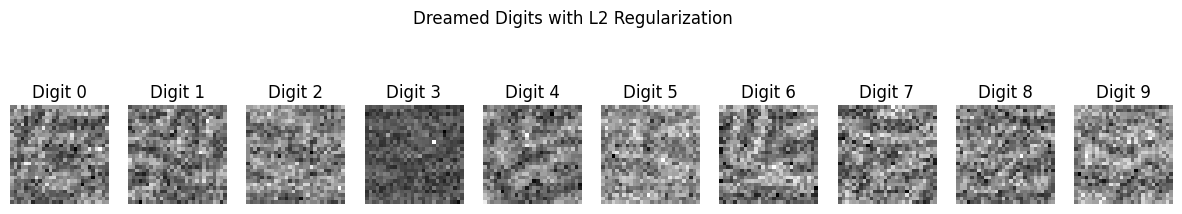

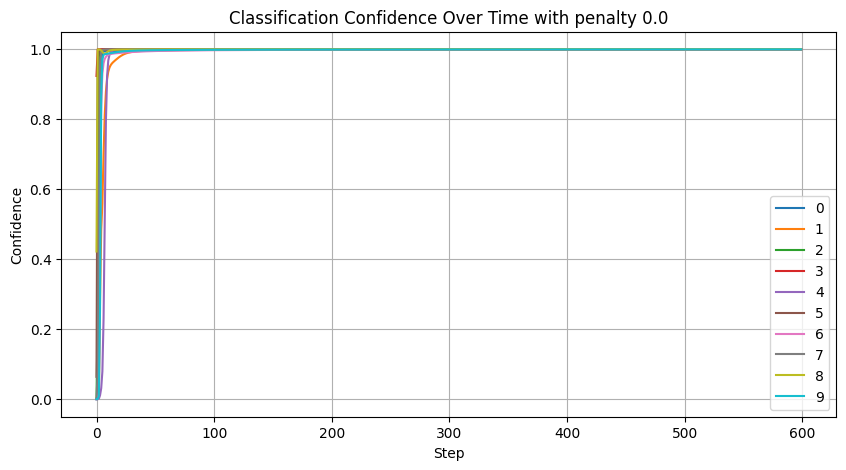

Step 0 | CE Loss: 7.9803 | L2: 1.0114 | Mean Conf: 0.0208
Step 50 | CE Loss: 0.0025 | L2: 1.5370 | Mean Conf: 0.9975
Step 100 | CE Loss: 0.0014 | L2: 1.4771 | Mean Conf: 0.9986
Step 150 | CE Loss: 0.0010 | L2: 1.4006 | Mean Conf: 0.9990
Step 200 | CE Loss: 0.0008 | L2: 1.3228 | Mean Conf: 0.9992
Step 250 | CE Loss: 0.0007 | L2: 1.2457 | Mean Conf: 0.9993
Step 300 | CE Loss: 0.0006 | L2: 1.1706 | Mean Conf: 0.9994
Step 350 | CE Loss: 0.0005 | L2: 1.0980 | Mean Conf: 0.9995
Step 400 | CE Loss: 0.0005 | L2: 1.0285 | Mean Conf: 0.9995
Step 450 | CE Loss: 0.0005 | L2: 0.9623 | Mean Conf: 0.9995
Step 500 | CE Loss: 0.0004 | L2: 0.8994 | Mean Conf: 0.9996
Step 550 | CE Loss: 0.0004 | L2: 0.8399 | Mean Conf: 0.9996
Step 599 | CE Loss: 0.0004 | L2: 0.7849 | Mean Conf: 0.9996


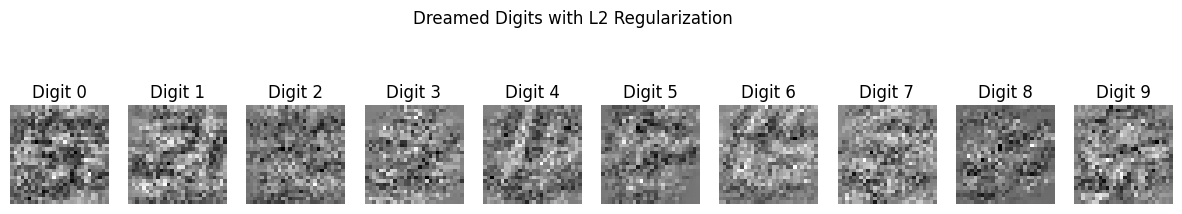

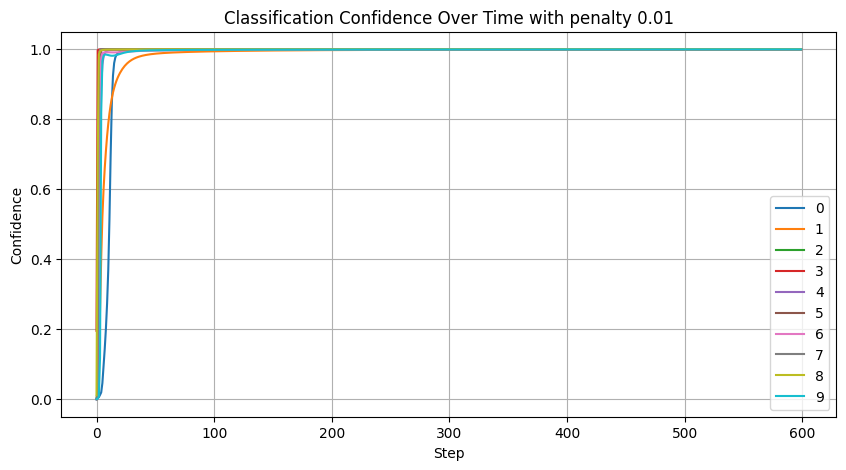

Step 0 | CE Loss: 7.0376 | L2: 1.0230 | Mean Conf: 0.1251
Step 50 | CE Loss: 0.0023 | L2: 1.2656 | Mean Conf: 0.9977
Step 100 | CE Loss: 0.0013 | L2: 1.0289 | Mean Conf: 0.9987
Step 150 | CE Loss: 0.0009 | L2: 0.8218 | Mean Conf: 0.9991
Step 200 | CE Loss: 0.0008 | L2: 0.6545 | Mean Conf: 0.9992
Step 250 | CE Loss: 0.0007 | L2: 0.5208 | Mean Conf: 0.9993
Step 300 | CE Loss: 0.0006 | L2: 0.4142 | Mean Conf: 0.9994
Step 350 | CE Loss: 0.0006 | L2: 0.3295 | Mean Conf: 0.9994
Step 400 | CE Loss: 0.0005 | L2: 0.2622 | Mean Conf: 0.9995
Step 450 | CE Loss: 0.0005 | L2: 0.2087 | Mean Conf: 0.9995
Step 500 | CE Loss: 0.0005 | L2: 0.1664 | Mean Conf: 0.9995
Step 550 | CE Loss: 0.0005 | L2: 0.1330 | Mean Conf: 0.9995
Step 599 | CE Loss: 0.0004 | L2: 0.1071 | Mean Conf: 0.9996


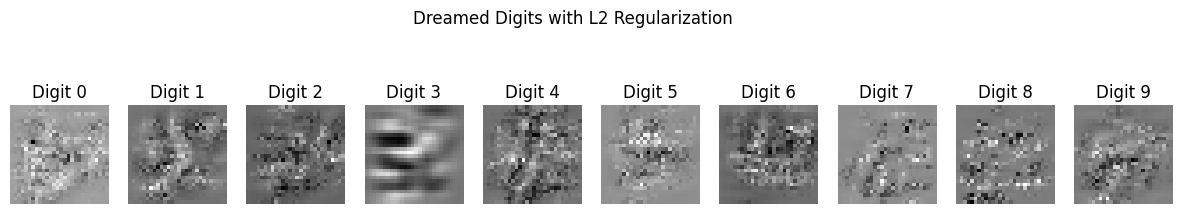

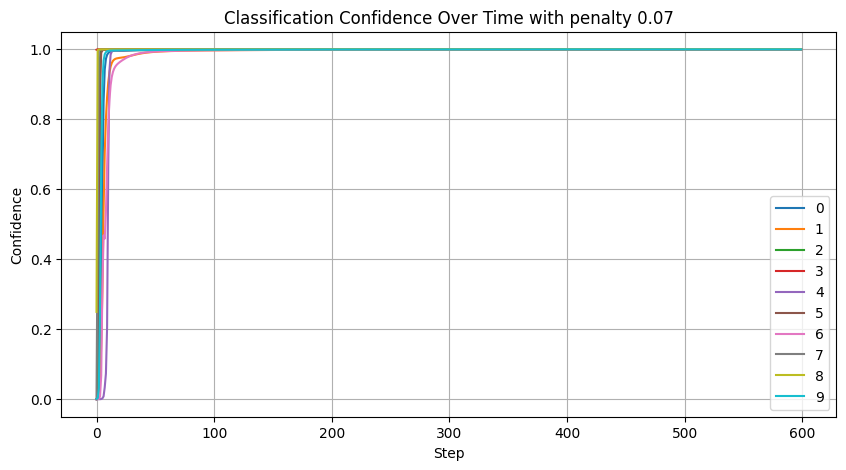

Step 0 | CE Loss: 7.6194 | L2: 0.9599 | Mean Conf: 0.0904
Step 50 | CE Loss: 0.0021 | L2: 1.1847 | Mean Conf: 0.9979
Step 100 | CE Loss: 0.0012 | L2: 0.9052 | Mean Conf: 0.9988
Step 150 | CE Loss: 0.0009 | L2: 0.6811 | Mean Conf: 0.9991
Step 200 | CE Loss: 0.0008 | L2: 0.5110 | Mean Conf: 0.9992
Step 250 | CE Loss: 0.0007 | L2: 0.3831 | Mean Conf: 0.9993
Step 300 | CE Loss: 0.0006 | L2: 0.2873 | Mean Conf: 0.9994
Step 350 | CE Loss: 0.0006 | L2: 0.2157 | Mean Conf: 0.9994
Step 400 | CE Loss: 0.0005 | L2: 0.1624 | Mean Conf: 0.9995
Step 450 | CE Loss: 0.0005 | L2: 0.1228 | Mean Conf: 0.9995
Step 500 | CE Loss: 0.0005 | L2: 0.0935 | Mean Conf: 0.9995
Step 550 | CE Loss: 0.0005 | L2: 0.0719 | Mean Conf: 0.9995
Step 599 | CE Loss: 0.0005 | L2: 0.0562 | Mean Conf: 0.9995


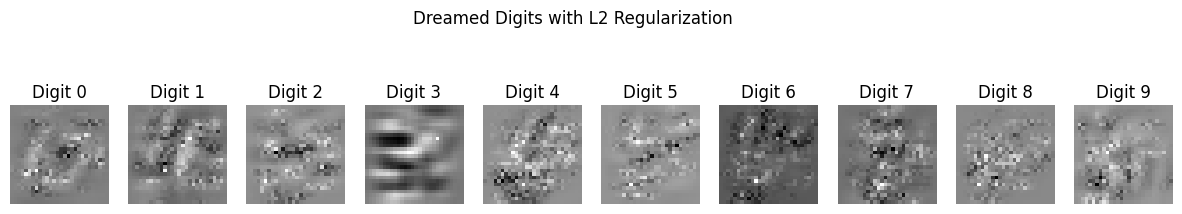

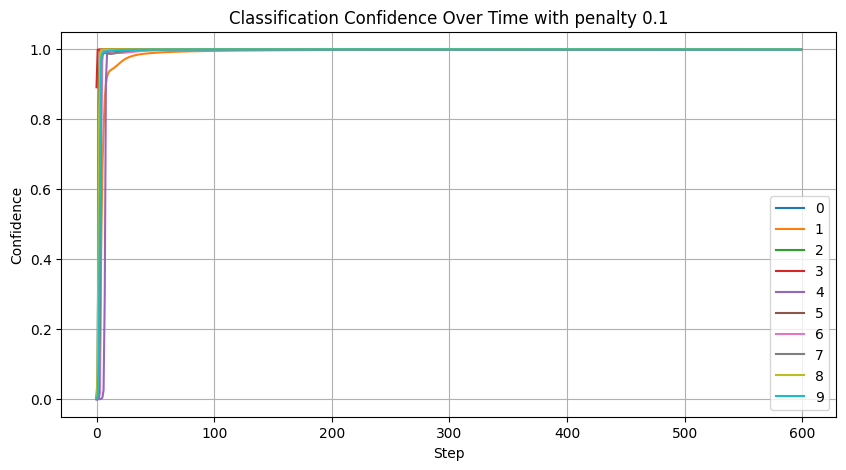

Step 0 | CE Loss: 6.8862 | L2: 0.9895 | Mean Conf: 0.1546
Step 50 | CE Loss: 0.0019 | L2: 0.4244 | Mean Conf: 0.9981
Step 100 | CE Loss: 0.0016 | L2: 0.1141 | Mean Conf: 0.9984
Step 150 | CE Loss: 0.0017 | L2: 0.0369 | Mean Conf: 0.9983
Step 200 | CE Loss: 0.0017 | L2: 0.0172 | Mean Conf: 0.9983
Step 250 | CE Loss: 0.0017 | L2: 0.0114 | Mean Conf: 0.9983
Step 300 | CE Loss: 0.0017 | L2: 0.0096 | Mean Conf: 0.9983
Step 350 | CE Loss: 0.0017 | L2: 0.0089 | Mean Conf: 0.9983
Step 400 | CE Loss: 0.0017 | L2: 0.0086 | Mean Conf: 0.9983
Step 450 | CE Loss: 0.0017 | L2: 0.0085 | Mean Conf: 0.9983
Step 500 | CE Loss: 0.0017 | L2: 0.0085 | Mean Conf: 0.9983
Step 550 | CE Loss: 0.0017 | L2: 0.0084 | Mean Conf: 0.9983
Step 599 | CE Loss: 0.0017 | L2: 0.0084 | Mean Conf: 0.9983


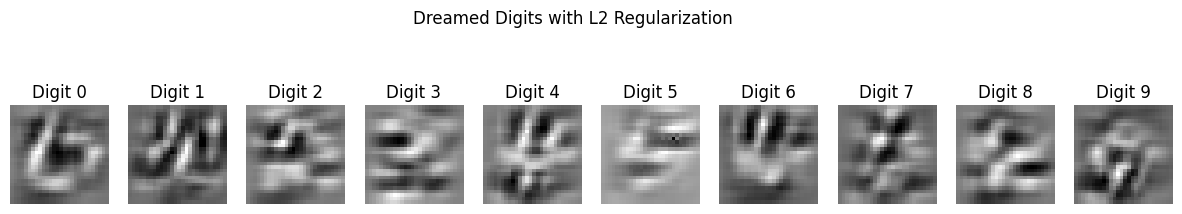

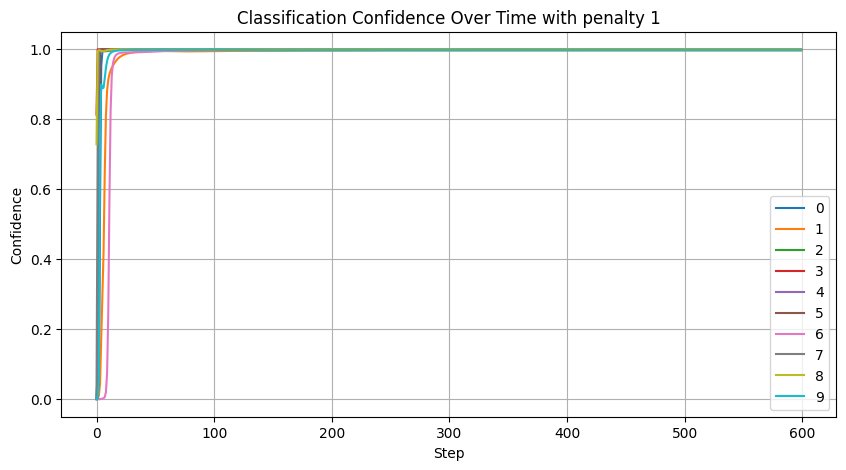

Step 0 | CE Loss: 6.8239 | L2: 0.9994 | Mean Conf: 0.1550
Step 50 | CE Loss: 0.0104 | L2: 0.0136 | Mean Conf: 0.9896
Step 100 | CE Loss: 0.0094 | L2: 0.0061 | Mean Conf: 0.9907
Step 150 | CE Loss: 0.0090 | L2: 0.0060 | Mean Conf: 0.9911
Step 200 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 250 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 300 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 350 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 400 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 450 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 500 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 550 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912
Step 599 | CE Loss: 0.0089 | L2: 0.0060 | Mean Conf: 0.9912


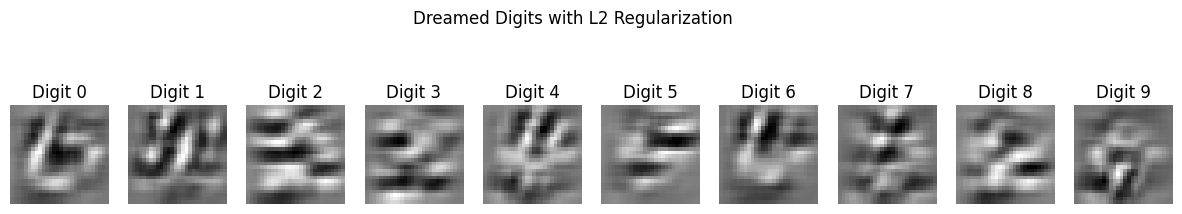

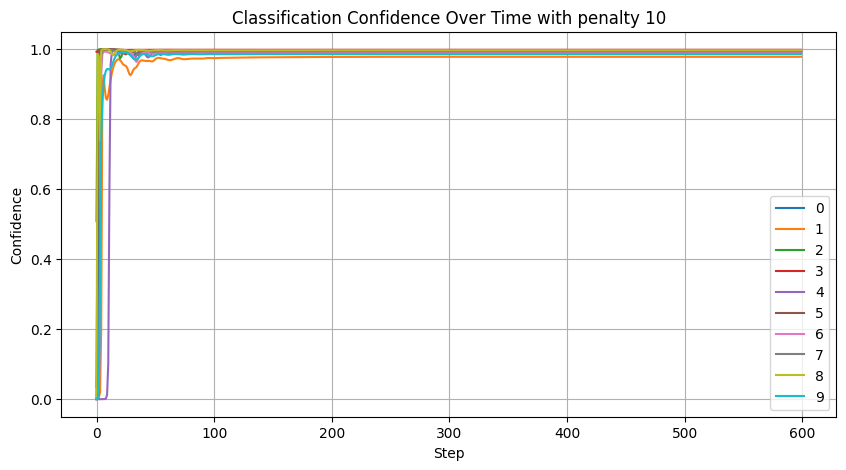

In [32]:
def plot_task3_results(images, history, lambda_l2):

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()


    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title(f"Classification Confidence Over Time with penalty {lambda_l2}")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()
    # test dla różnych kar.
for lam in [0.0, 0.01, 0.07, 0.1, 1, 10]:
  final_images, confidence_history = dream_digits_l2(net, lambda_l2=lam)

  plot_task3_results(final_images, confidence_history, lam)

## 1. Are they more or less readable?

Obrazy uzyskane bez regularyzacji są bardzo nieczytelne, podobnie do tych otrzymanych w pracy 9. MLP za bardzo skupia się na pojedynczych pixelach. Z kolei CNN jest bardziej skomplikowaną siecią która dostrzega większe struktury ale przez jej złożoność i dobre wytrenowanie potrafi klasyfikować do ustalonej klasy już bardzo słabo je widoczne, stąd taki drobne obszary o ustalonym odcieniu jej wystarczają. Niestety regularyzacja w przypadku CNN nie pomaga, przez ich strukturę, która dzięki przemnażaniu przez 'okna' rozprzestrzenia podobne wartości na sąsiednie kierunki. W dodatku wielowarstwowość łączy je w większe struktury, a błędy, które nie przeszkadzają w poprawnej klasyfikacji, ale są obecne we wsp. danej warstwy, dające nienajlepszą, choć dostateczną predykcje są potem powielane w kolejnych warstwach, które często łaczą zauważane fragmenty w większe struktury. Obrazy stają się rozmazane.   

##2. Do they resemble real MNIST digits more closely or less?

Przypominają MNIST w mniejszym stopniu, ze względu na to, że pismo odręczne ma ma wyraźniejsze kontury, nie rozmazuje się, natomiast CNN sprawia że model poprzez filtry które dotyczą wielu komórek naraz, porównuje większe fragmenty obrazów nadając im odpowiednich kształtów przechodząc do bardziej gładkich obrazów. Według mnie za gładkich dla ludzkiego oka.

## 3.Why do you think that happens? Consider the CNN’s inductive biases and architectural properties

Jak wspomniałem wcześniej niedokładności się nakładają, rozbudowany model CNN sobie z nimi radzi, ale ludzkie oko już nie tak dobrze. Poza tym to, że informacje o kształtach poprzez filtry ('okna') mogą być przenoszone w inne miejsce obrazka, to model może nawet nauczyć że obecność danego kształtu jest ważniejsza niż miejsce jego wystąpienia, to jest bardzo mylące dla ludzkiego oka.

# Adwersaryjna część

In [15]:
def generate_adversarial_example(x, y_wrong, model, lambda_l2=0.01, num_steps=40, lr=0.01):

    x = x.clone().detach()
    x = x.to(device)

    delta = torch.zeros_like(x, requires_grad=True).to(device)

    # zamiana nieodpowiedniej klasy na tensor
    y_wrong_tensor = torch.tensor([y_wrong], device=device)

    optimizer = torch.optim.Adam([delta], lr=lr)

    history = []
    for _ in range(num_steps):
        optimizer.zero_grad()

        output = model(x + delta)
        loss = F.cross_entropy(output, y_wrong_tensor) + lambda_l2 * delta.pow(2).mean()

        loss.backward()
        optimizer.step()


        # dopasowanie żeby po dodaniu szumu nie wyjść poza zakres
        delta.data = torch.clamp(x + delta.data, 0, 1) - x
        with torch.no_grad():
            probs = F.softmax(output, dim=1)

            confidence = probs[0, torch.arange(10)].detach().cpu().numpy()
            history.append(confidence)

    x_adv = x + delta.detach()
    return x_adv, y_wrong, history

In [16]:
# do pokazywania obrazów niezaszumionych i po dodaniu zoptymalizowanego szumu w celu wprowadzenia w błąd
def show_images(original, adversarial, orig_pred, adv_pred):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title(f'Original (Pred: {orig_pred})')
    axs[1].imshow(adversarial.squeeze(), cmap='gray')
    axs[1].set_title(f'Adversarial (Pred: {adv_pred})')
    for ax in axs:
        ax.axis('off')

    plt.show()

In [17]:
# do tworzenia wykresów prawdopodobieństw klas od czasu
def plot_confidence_history(conf_history, lambda_l2, y_true, y_wrong):
    plt.figure(figsize=(6, 4))
    plt.plot(conf_history, label=[i for i in range(10)])
    plt.title(f"Confidence in Target Class {y_wrong} (True={y_true})\nLambda={lambda_l2}")
    plt.xlabel("Attack Step")
    plt.ylabel("Confidence in Target Class")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
# do przeprowadzania ataków na zbiorze testowym
def adversarial_on_testset(lambda_l2):
  success_counts= [[0 for i in range(10)] for j in range(10)]
  trials_counts= [[0 for i in range(10)] for j in range(10)]
  j= 0
  for i, (x, y) in enumerate(testloader):
      if i >= 120:
        break
      y_true = y.item()
      x = x.to(device)
      y = y.to(device)

      if net(x).argmax(dim=1).item() != y_true:
          continue
      for y_wrong in range(10):
          if y_wrong == y_true:
              continue

          trials_counts[y_true][y_wrong] +=1
          # Run adversarial generation
          x_adv, _, conf_hist = generate_adversarial_example(x, y_wrong, net, lambda_l2=lambda_l2)

          with torch.no_grad():
              adv_pred = net(x_adv).argmax(dim=1).item()

          if adv_pred == y_wrong:
              success_counts[y_true][y_wrong]+=1

              if success_counts[y_true] [y_wrong] == 1:

                print(f"Found adversarial example for True={y_true}, Target={y_wrong}")
                show_images(x.squeeze().detach().cpu().numpy(), x_adv.squeeze().detach().cpu().numpy(), y_true, y_wrong)
                j+=1
                if j % 5 == 0:
                  plot_confidence_history(conf_hist, lambda_l2, y_true, y_wrong)

  success_counts, trials_counts = np.array(success_counts), np.array(trials_counts)
  return success_counts, trials_counts




testy wraz z wynikami dla poszczególnych kar i różnych klas prawdziwych i docelowych. Mapy ciepła należy czytać następująco: W miejscu i,j takiej macierzy znajduje się odsetek skuteczności ataków mylących model, by przypisał cyfrę j zamiast i.

Zaczynamy od lambda = 0.01

Found adversarial example for True=7, Target=0


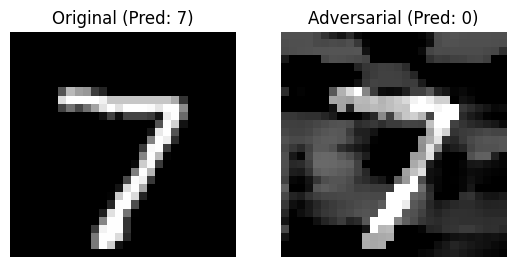

Found adversarial example for True=7, Target=2


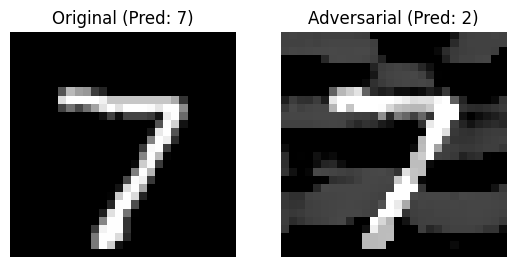

Found adversarial example for True=7, Target=3


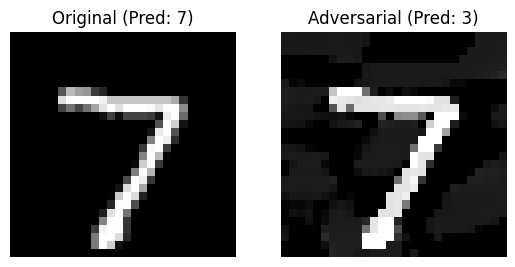

Found adversarial example for True=7, Target=5


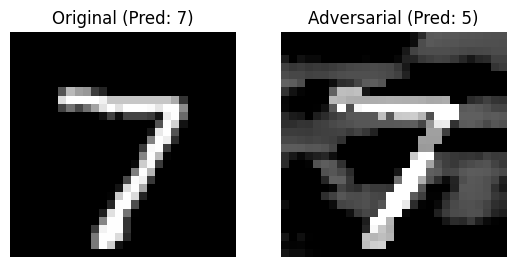

Found adversarial example for True=7, Target=8


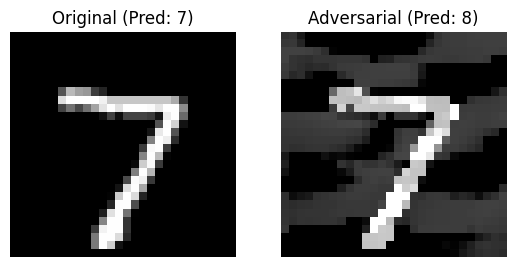

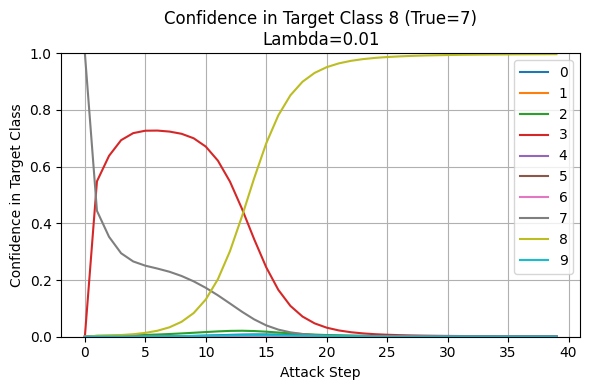

Found adversarial example for True=7, Target=9


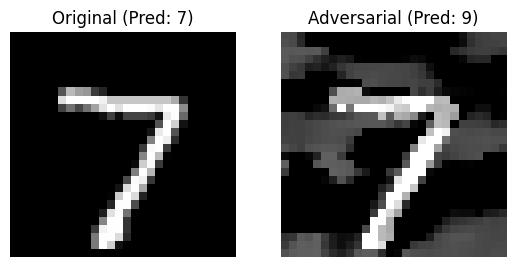

Found adversarial example for True=2, Target=0


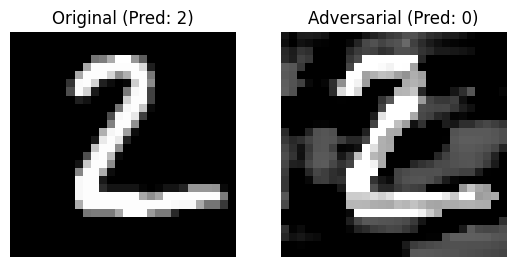

Found adversarial example for True=2, Target=3


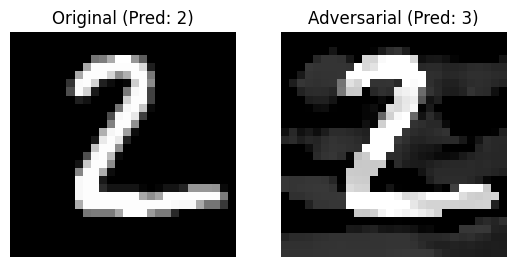

Found adversarial example for True=2, Target=5


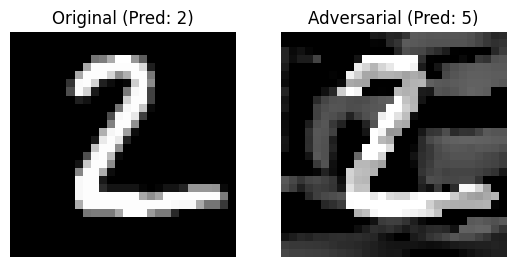

Found adversarial example for True=2, Target=7


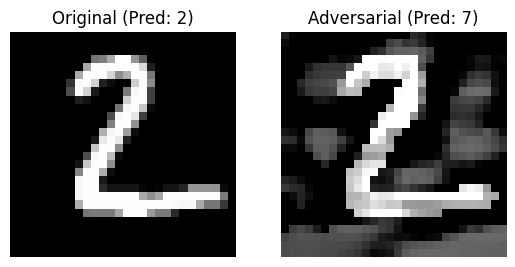

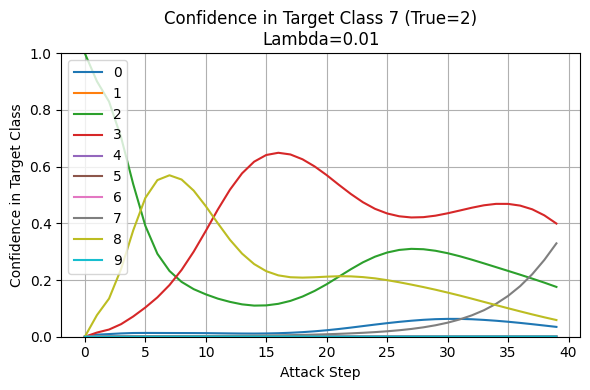

Found adversarial example for True=2, Target=8


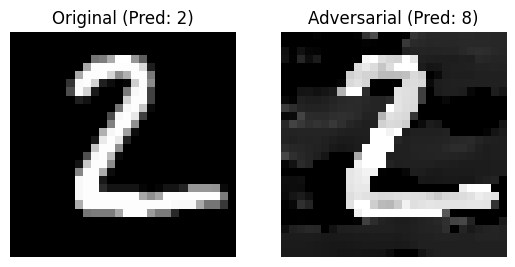

Found adversarial example for True=1, Target=0


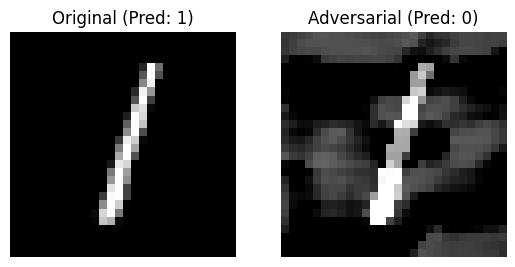

Found adversarial example for True=1, Target=2


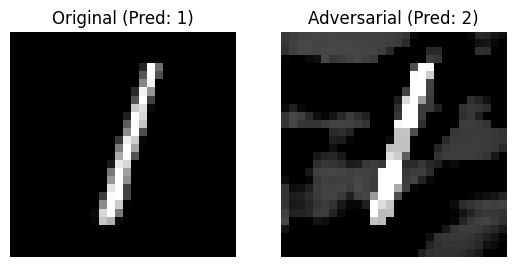

Found adversarial example for True=1, Target=3


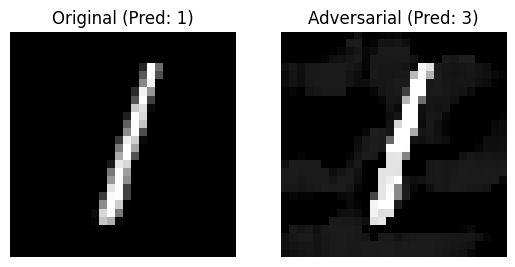

Found adversarial example for True=1, Target=4


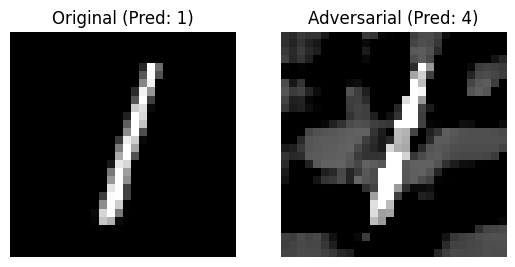

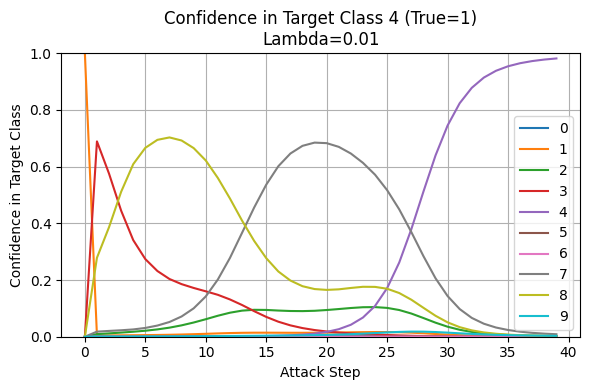

Found adversarial example for True=1, Target=5


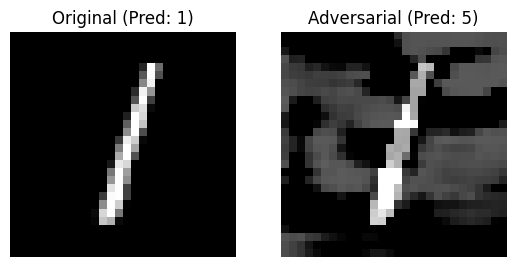

Found adversarial example for True=1, Target=6


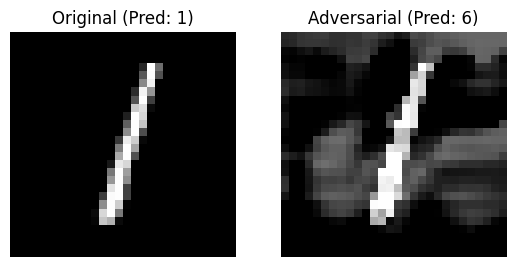

Found adversarial example for True=1, Target=7


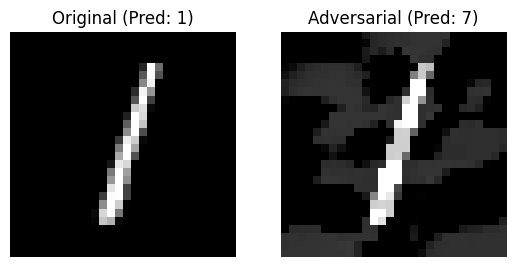

Found adversarial example for True=1, Target=8


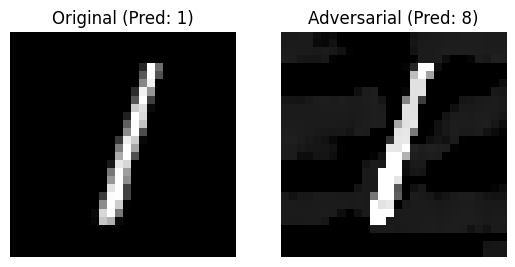

Found adversarial example for True=1, Target=9


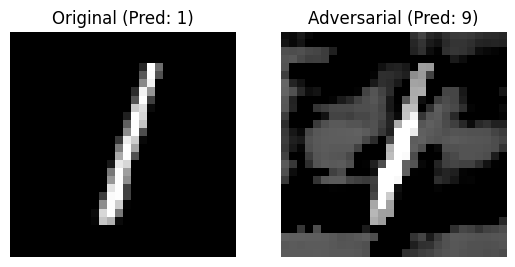

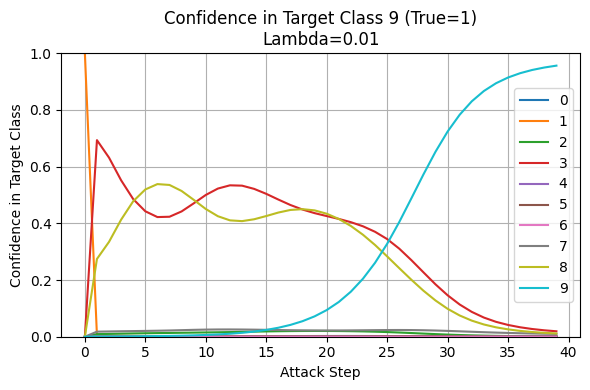

Found adversarial example for True=0, Target=2


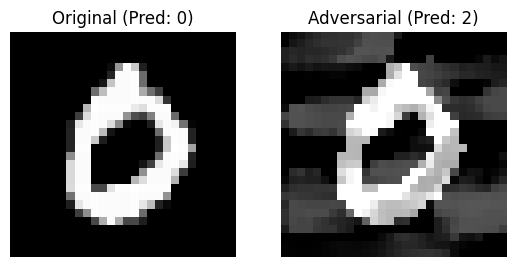

Found adversarial example for True=0, Target=3


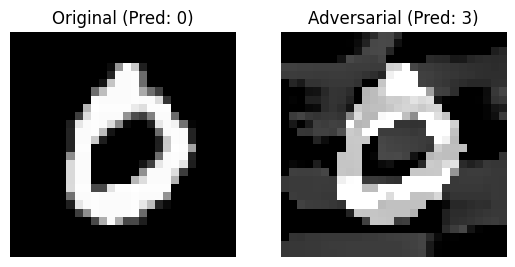

Found adversarial example for True=0, Target=4


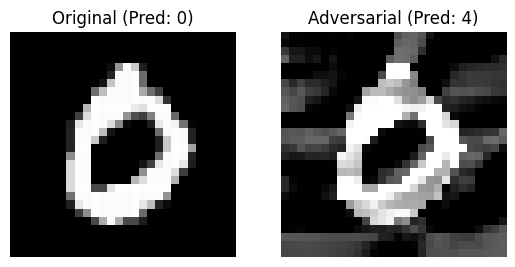

Found adversarial example for True=0, Target=5


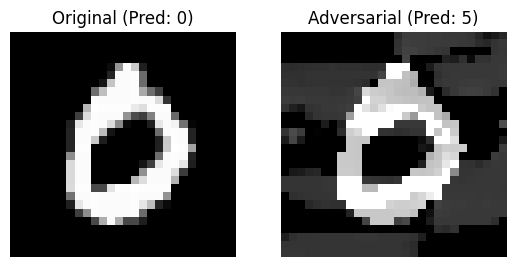

Found adversarial example for True=0, Target=6


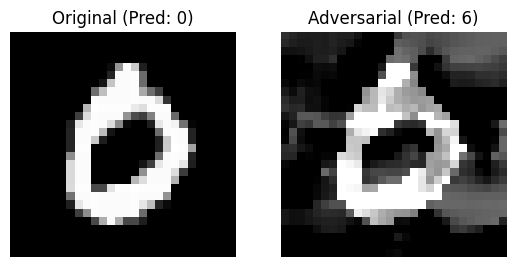

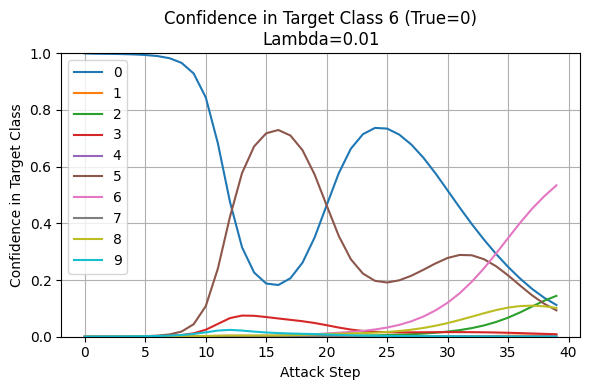

Found adversarial example for True=0, Target=7


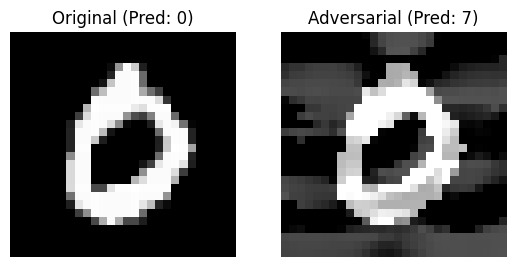

Found adversarial example for True=0, Target=8


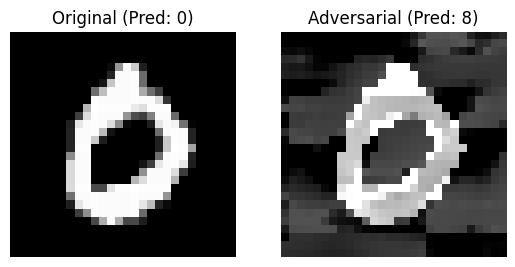

Found adversarial example for True=0, Target=9


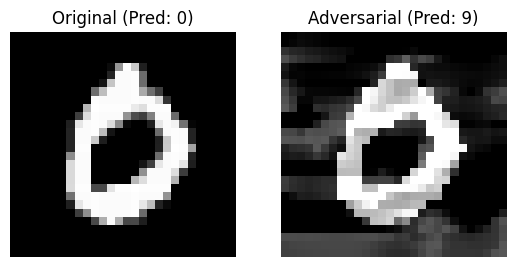

Found adversarial example for True=4, Target=0


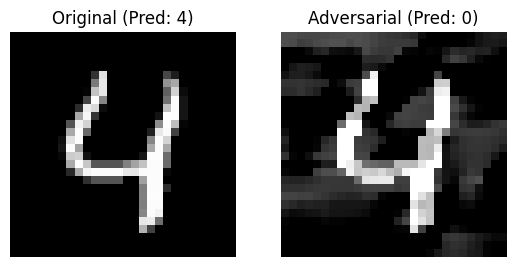

Found adversarial example for True=4, Target=1


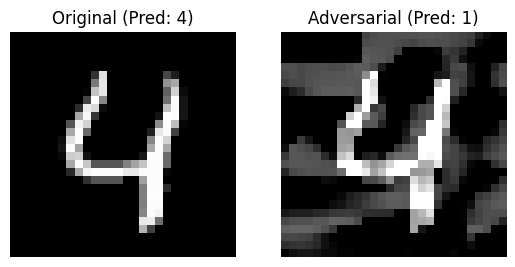

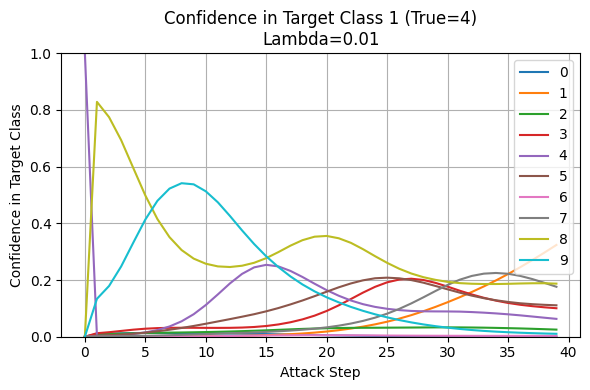

Found adversarial example for True=4, Target=2


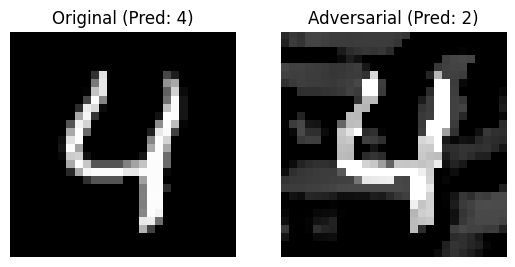

Found adversarial example for True=4, Target=3


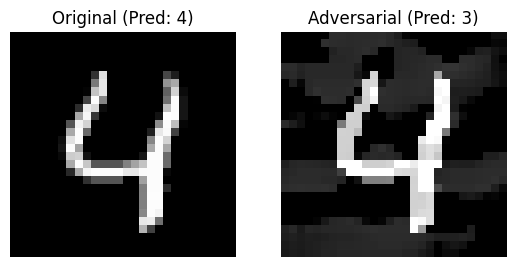

Found adversarial example for True=4, Target=5


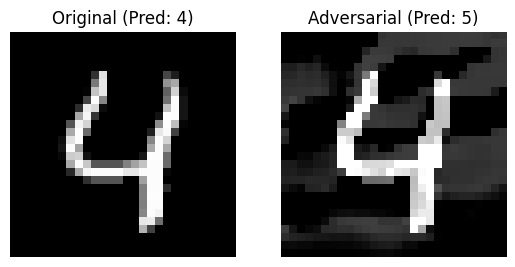

Found adversarial example for True=4, Target=6


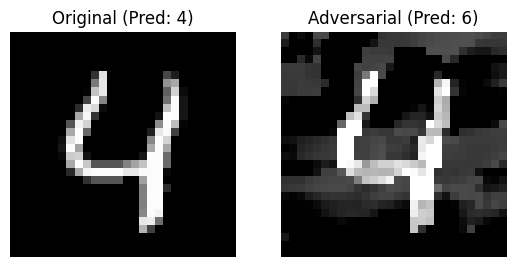

Found adversarial example for True=4, Target=7


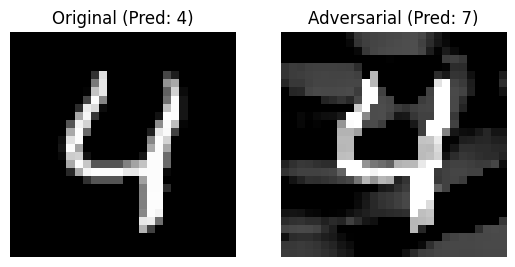

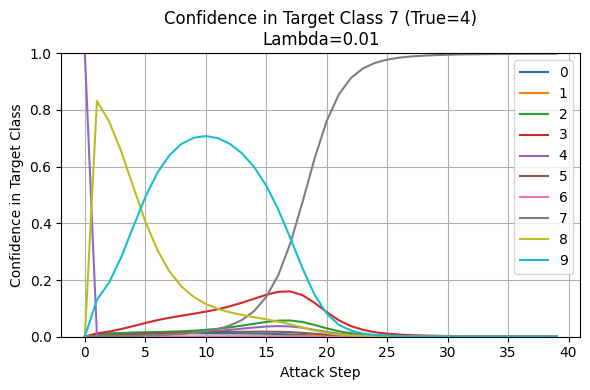

Found adversarial example for True=4, Target=8


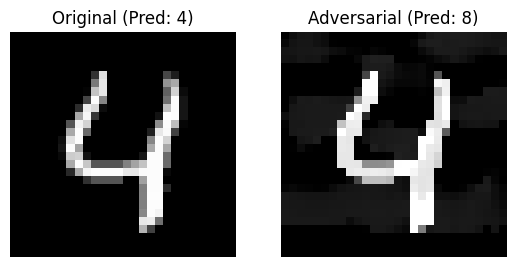

Found adversarial example for True=4, Target=9


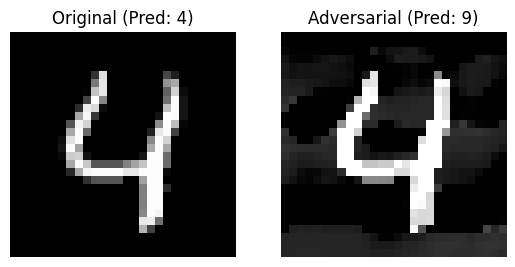

Found adversarial example for True=9, Target=1


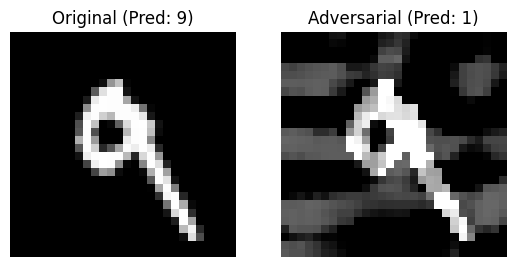

Found adversarial example for True=9, Target=3


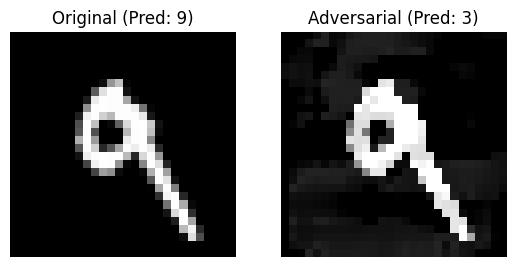

Found adversarial example for True=9, Target=4


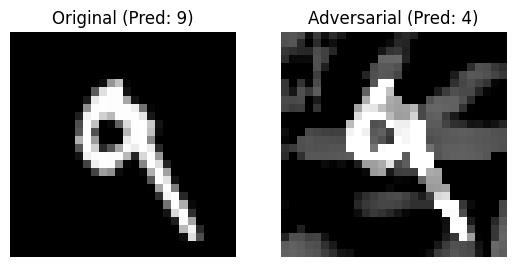

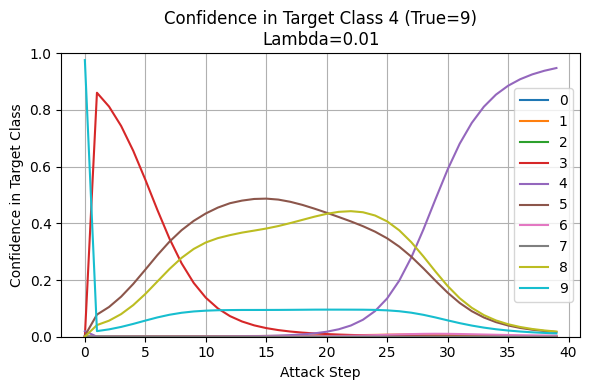

Found adversarial example for True=9, Target=5


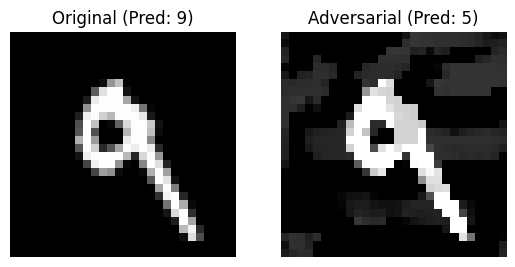

Found adversarial example for True=9, Target=6


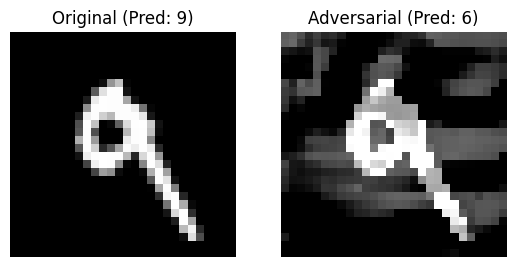

Found adversarial example for True=9, Target=7


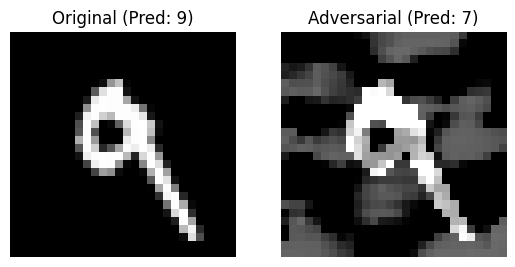

Found adversarial example for True=9, Target=8


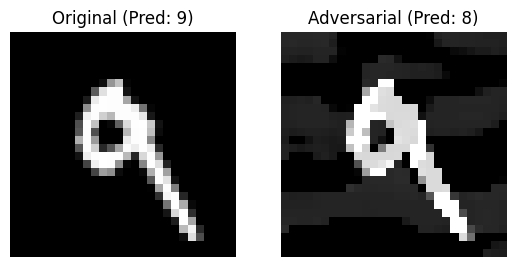

Found adversarial example for True=5, Target=0


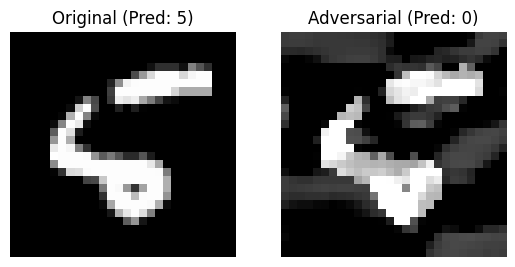

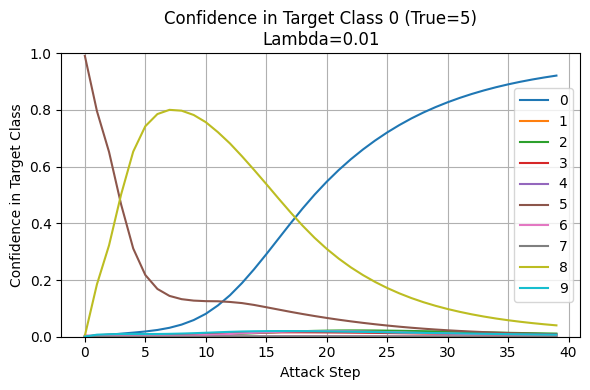

Found adversarial example for True=5, Target=2


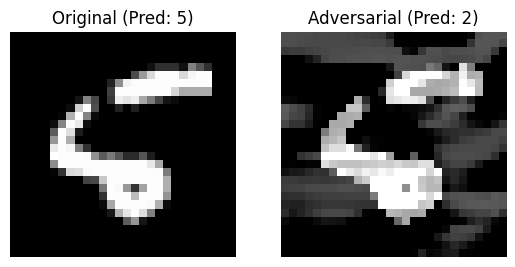

Found adversarial example for True=5, Target=3


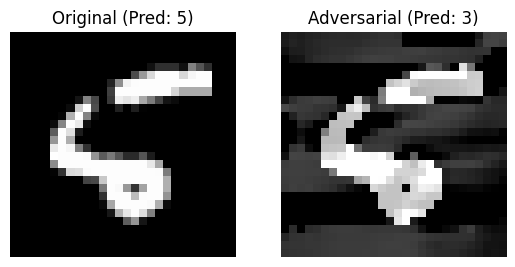

Found adversarial example for True=5, Target=6


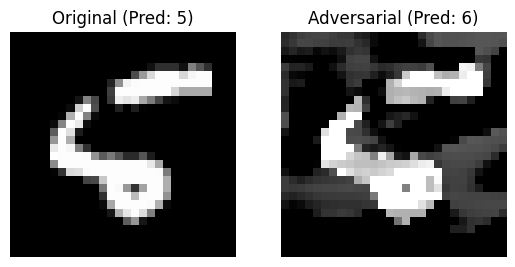

Found adversarial example for True=5, Target=7


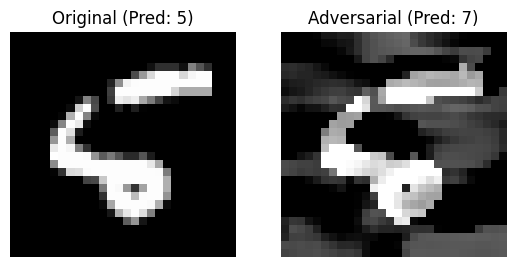

Found adversarial example for True=5, Target=8


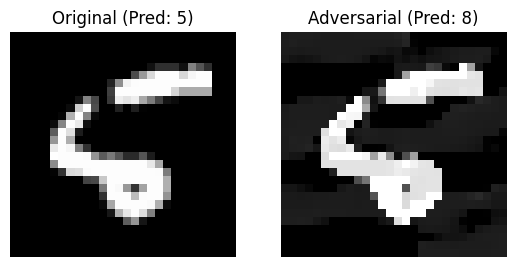

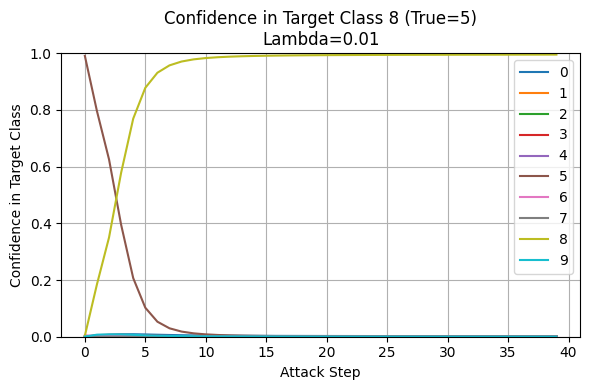

Found adversarial example for True=5, Target=9


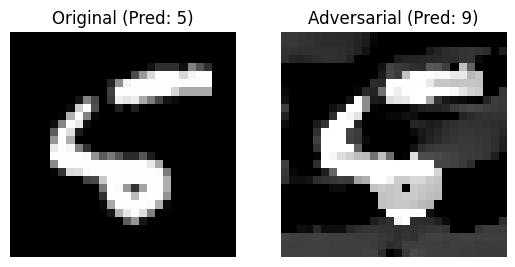

Found adversarial example for True=9, Target=0


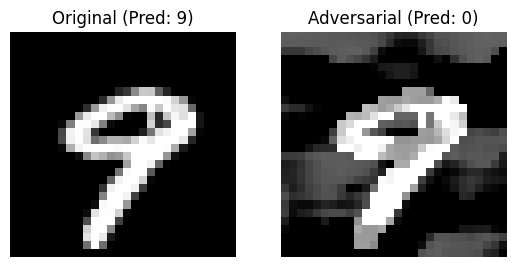

Found adversarial example for True=9, Target=2


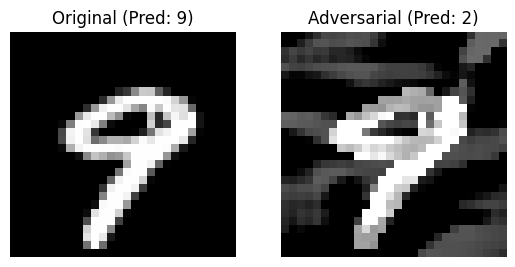

Found adversarial example for True=6, Target=0


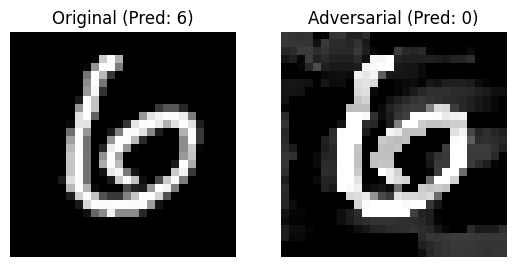

Found adversarial example for True=6, Target=2


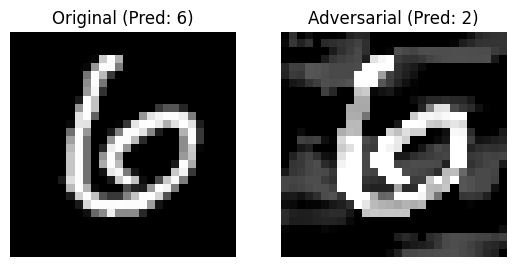

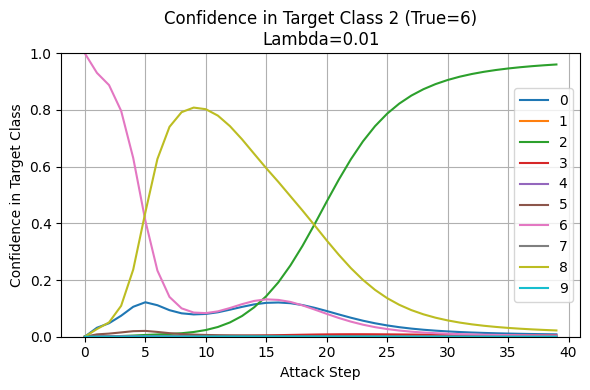

Found adversarial example for True=6, Target=3


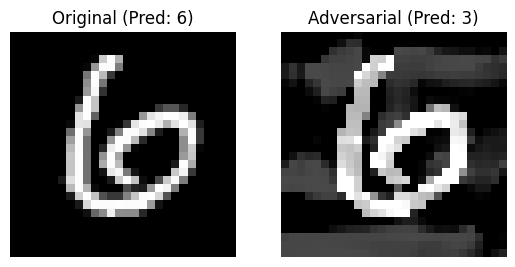

Found adversarial example for True=6, Target=4


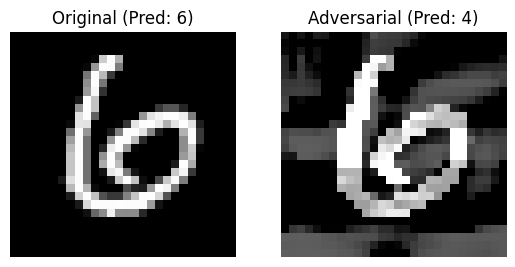

Found adversarial example for True=6, Target=5


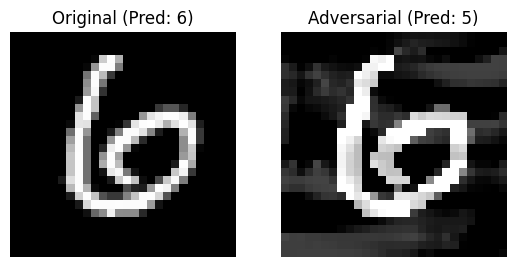

Found adversarial example for True=6, Target=7


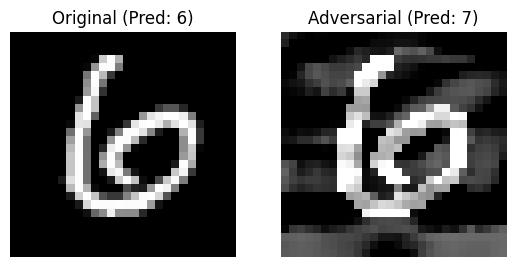

Found adversarial example for True=6, Target=8


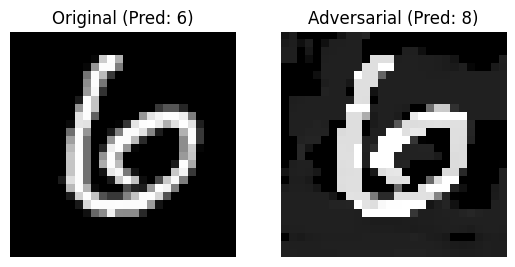

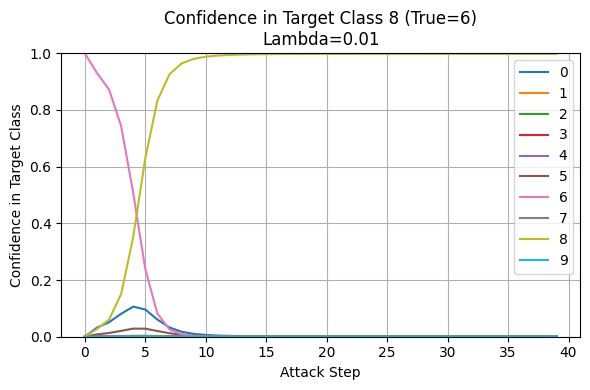

Found adversarial example for True=6, Target=9


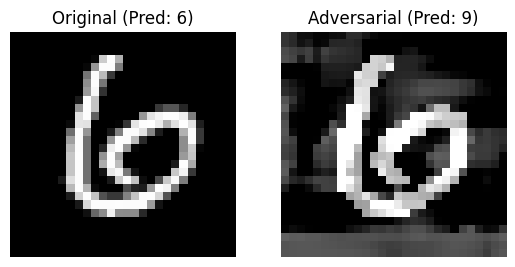

Found adversarial example for True=3, Target=0


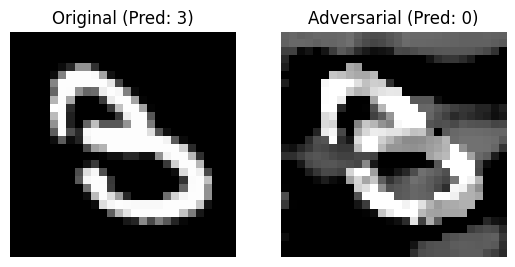

Found adversarial example for True=3, Target=1


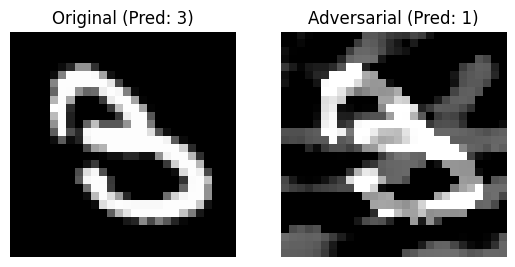

Found adversarial example for True=3, Target=2


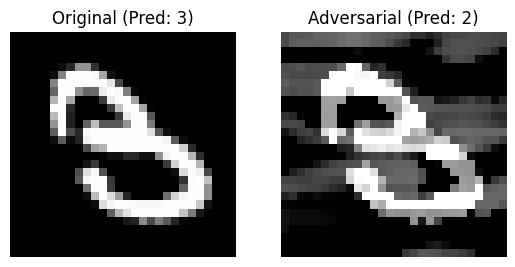

Found adversarial example for True=3, Target=5


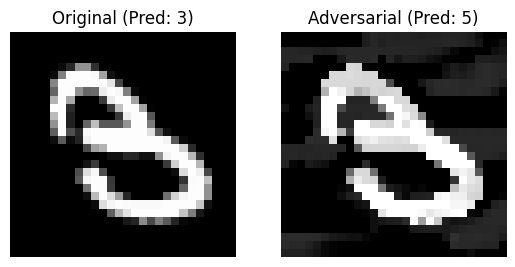

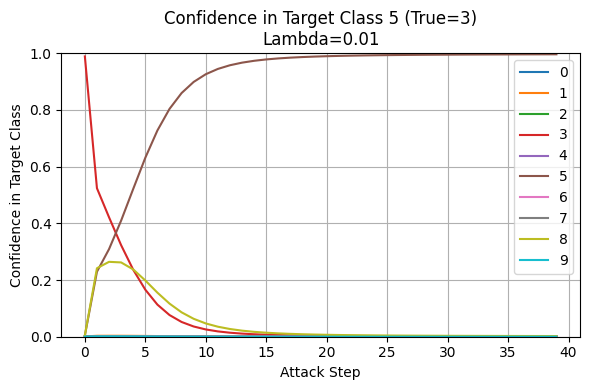

Found adversarial example for True=3, Target=6


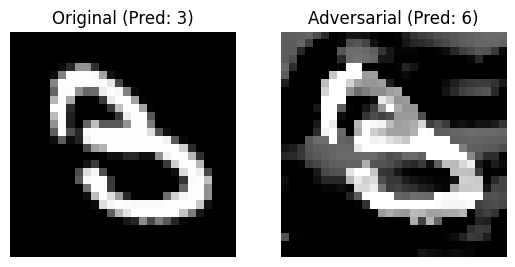

Found adversarial example for True=3, Target=7


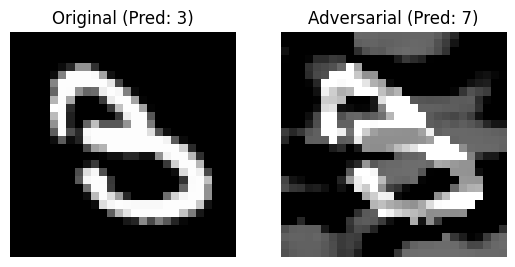

Found adversarial example for True=3, Target=8


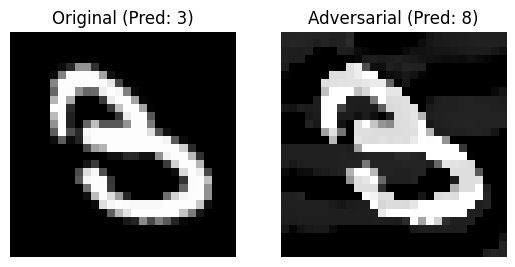

Found adversarial example for True=3, Target=9


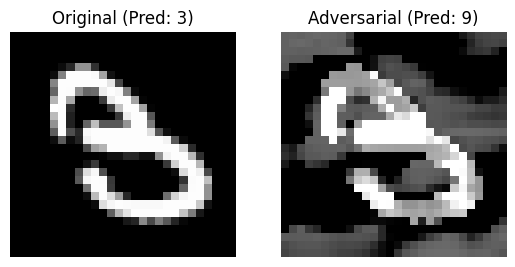

Found adversarial example for True=6, Target=1


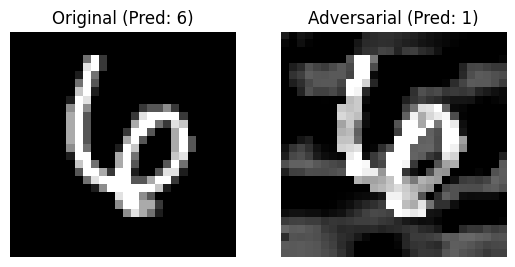

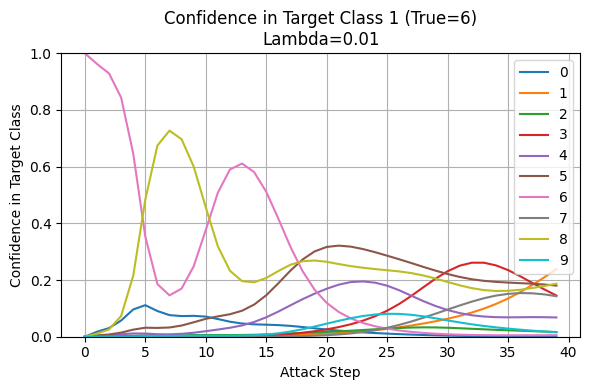

Found adversarial example for True=7, Target=1


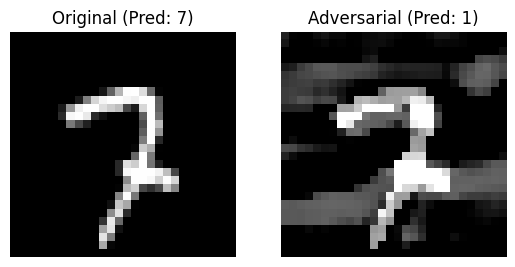

Found adversarial example for True=5, Target=4


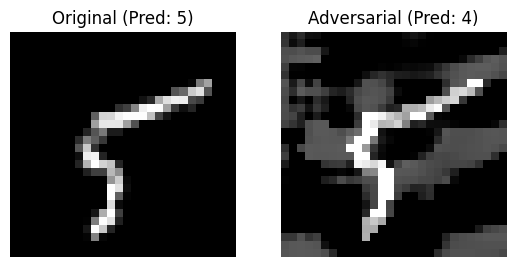

Found adversarial example for True=8, Target=0


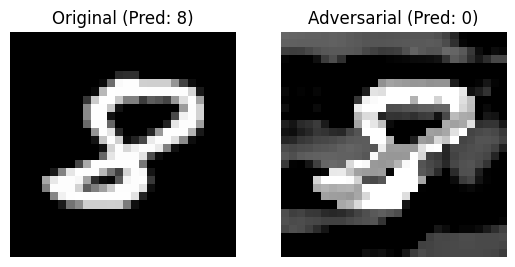

Found adversarial example for True=8, Target=2


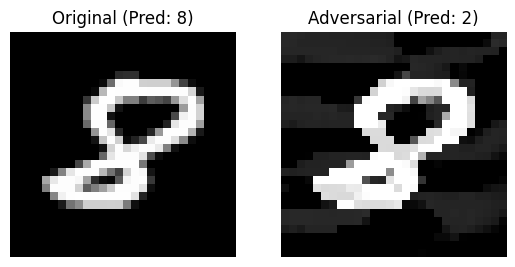

Found adversarial example for True=8, Target=3


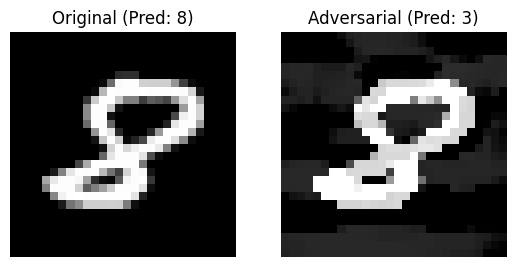

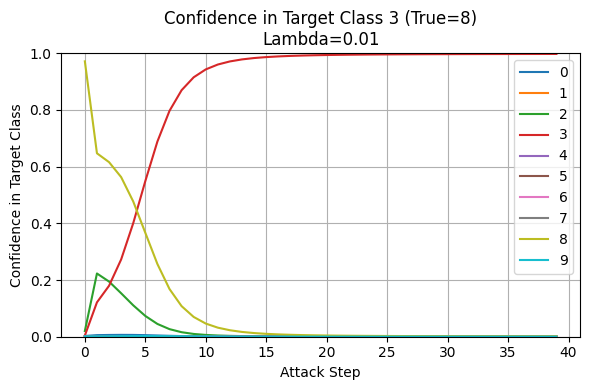

Found adversarial example for True=8, Target=5


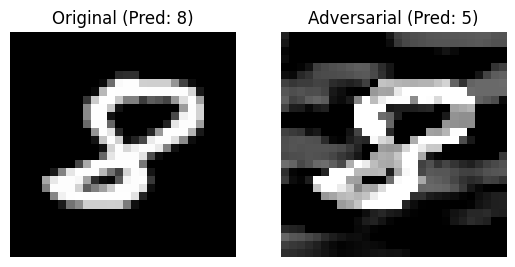

Found adversarial example for True=8, Target=7


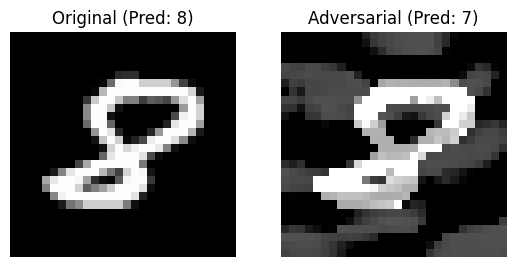

Found adversarial example for True=8, Target=9


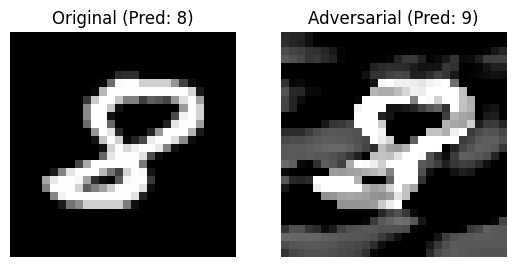

Found adversarial example for True=2, Target=1


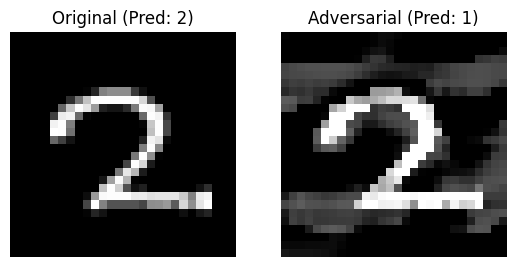

Found adversarial example for True=2, Target=9


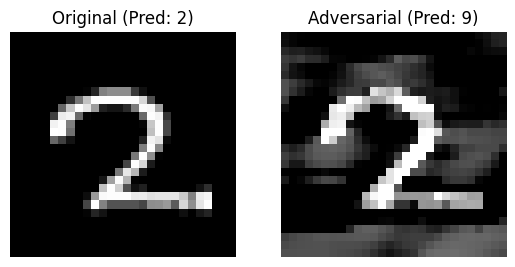

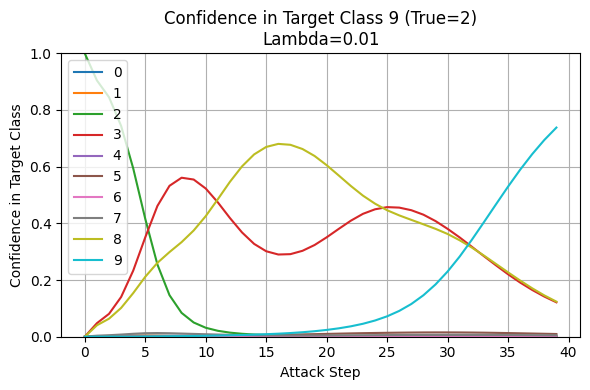

Found adversarial example for True=7, Target=4


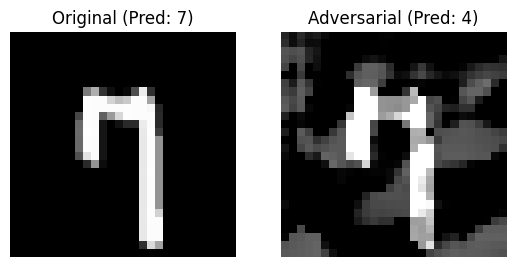

In [23]:
suc_cnt_1, trial_cnt_1 = adversarial_on_testset(0.01)

<ipython-input-24-4d0b85d718a5>:2: RuntimeWarning: invalid value encountered in divide
  rates = suc_cnt_1/trial_cnt_1


<Axes: >

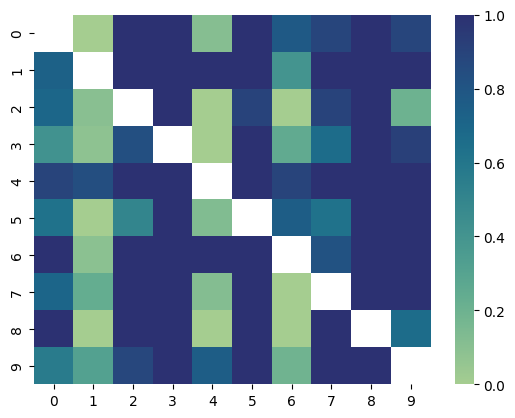

In [24]:
import seaborn as sns
rates = suc_cnt_1/trial_cnt_1
sns.heatmap(rates,cmap="crest")

teraz lambda= 0.1

Found adversarial example for True=7, Target=0


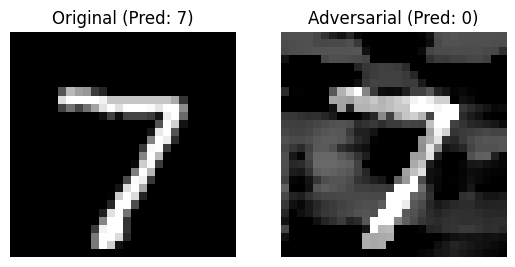

Found adversarial example for True=7, Target=2


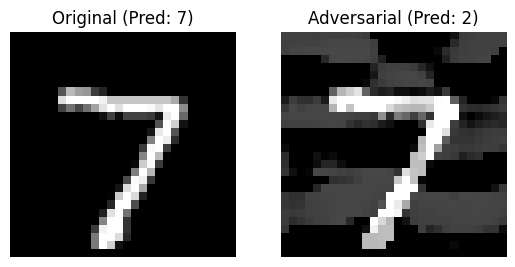

Found adversarial example for True=7, Target=3


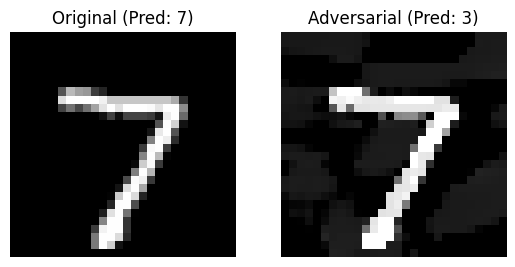

Found adversarial example for True=7, Target=5


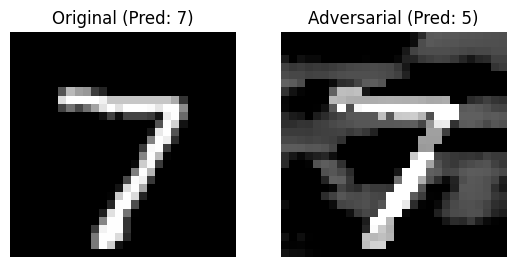

Found adversarial example for True=7, Target=8


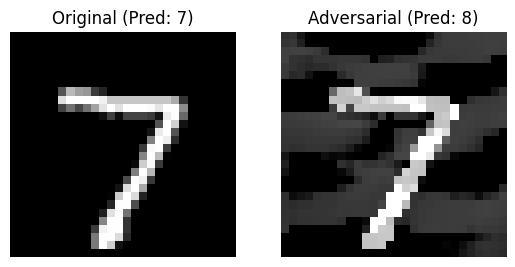

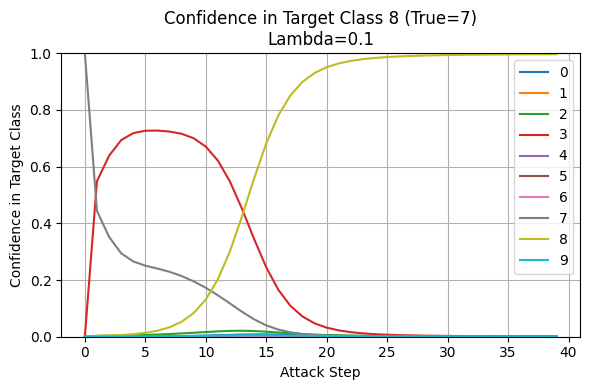

Found adversarial example for True=7, Target=9


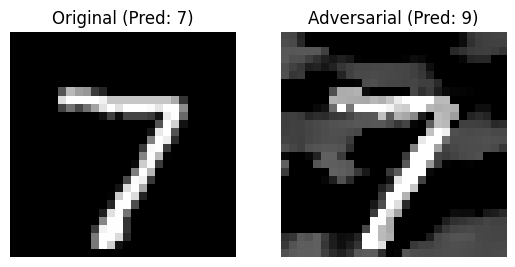

Found adversarial example for True=2, Target=0


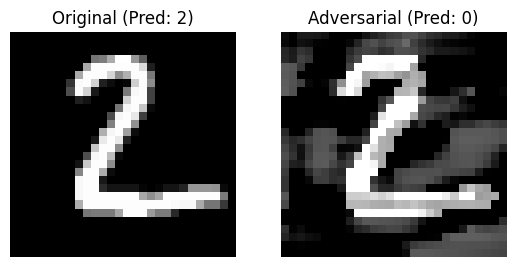

Found adversarial example for True=2, Target=3


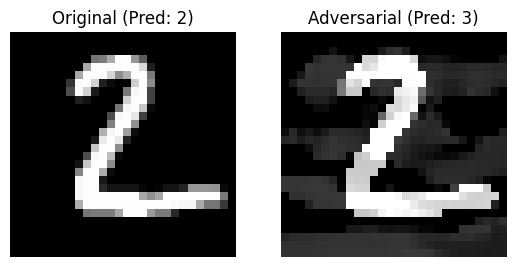

Found adversarial example for True=2, Target=5


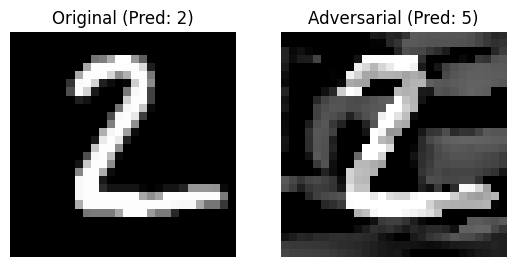

Found adversarial example for True=2, Target=7


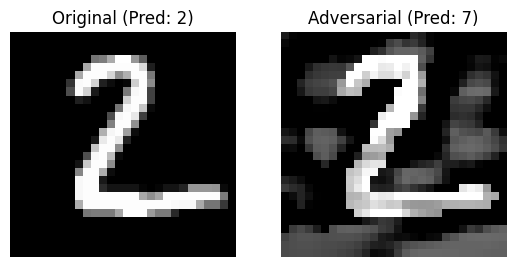

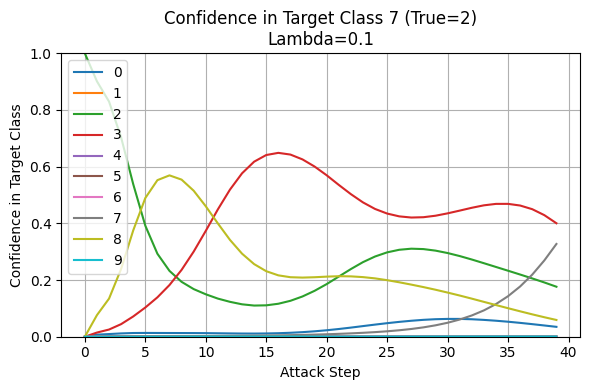

Found adversarial example for True=2, Target=8


Found adversarial example for True=1, Target=0


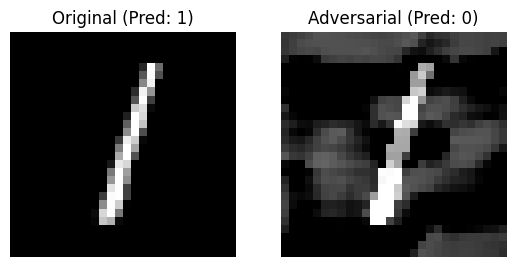

Found adversarial example for True=1, Target=2


Found adversarial example for True=1, Target=3


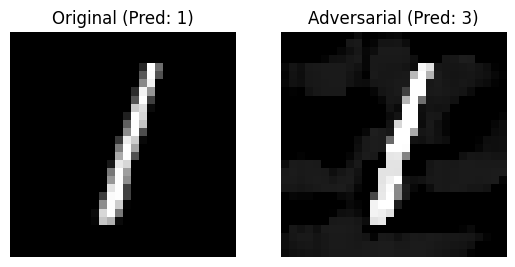

Found adversarial example for True=1, Target=4


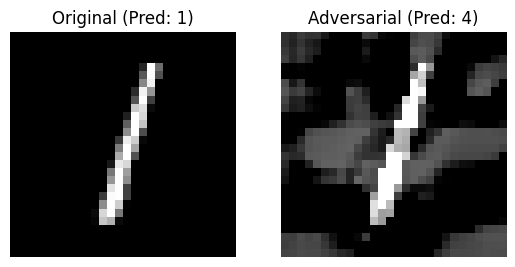

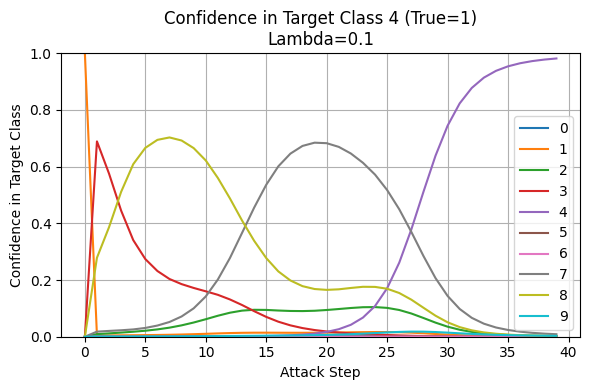

Found adversarial example for True=1, Target=5


Found adversarial example for True=1, Target=6


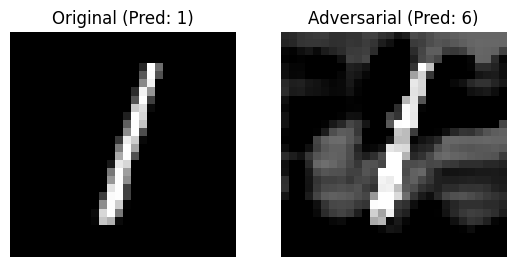

Found adversarial example for True=1, Target=7


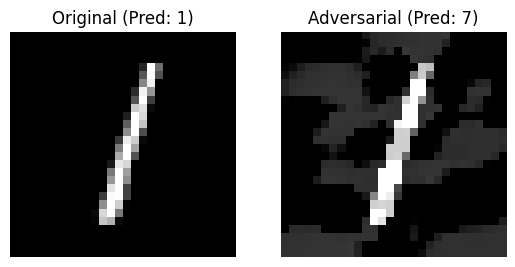

Found adversarial example for True=1, Target=8


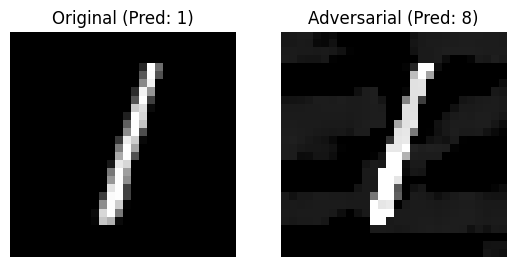

Found adversarial example for True=1, Target=9


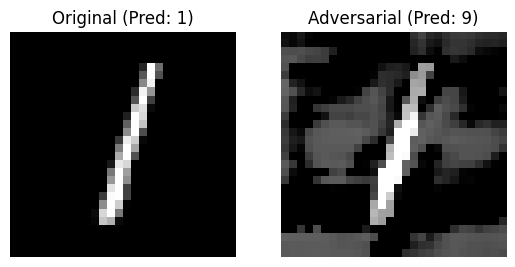

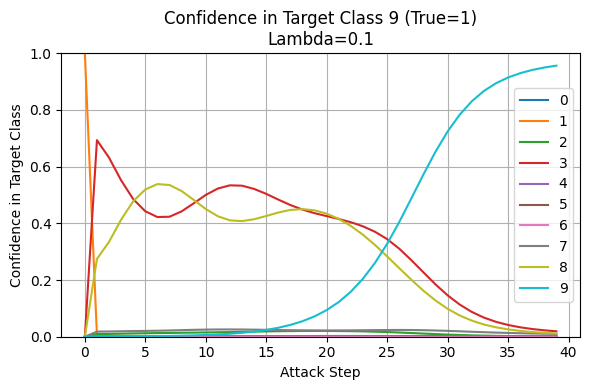

Found adversarial example for True=0, Target=2


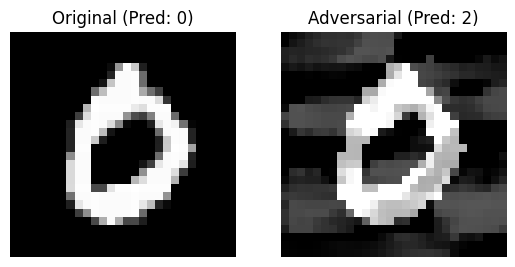

Found adversarial example for True=0, Target=3


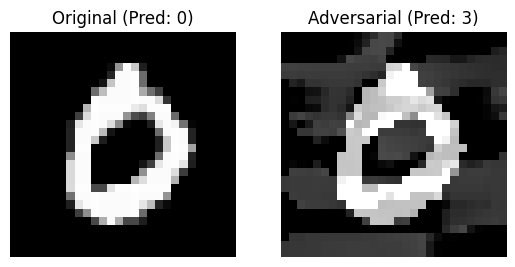

Found adversarial example for True=0, Target=4


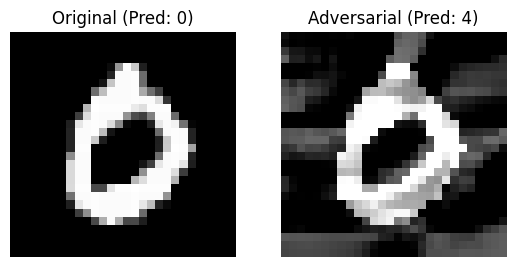

Found adversarial example for True=0, Target=5


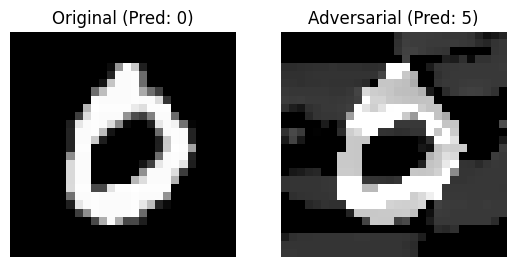

Found adversarial example for True=0, Target=6


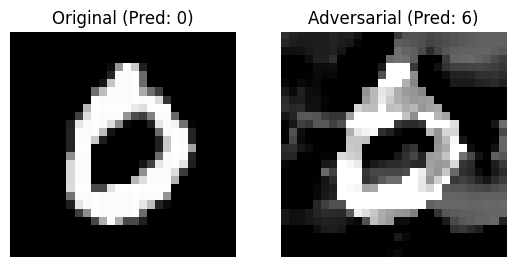

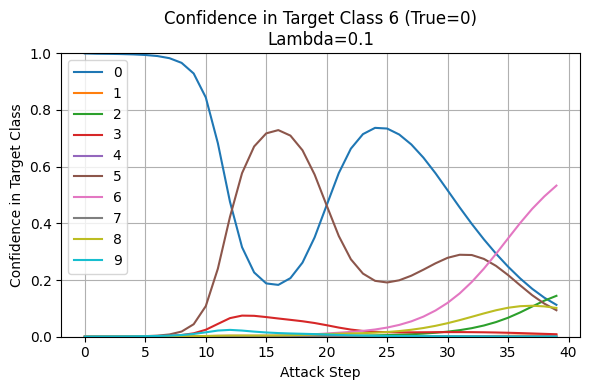

Found adversarial example for True=0, Target=7


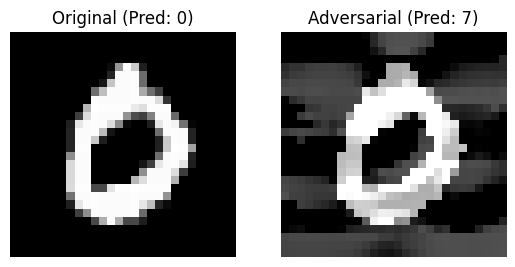

Found adversarial example for True=0, Target=8


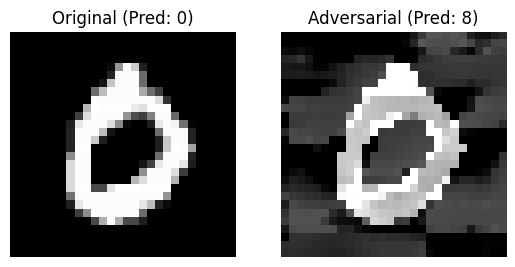

Found adversarial example for True=0, Target=9


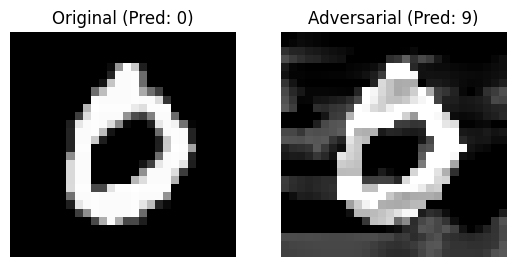

Found adversarial example for True=4, Target=0


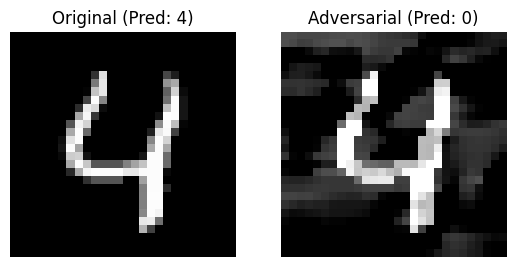

Found adversarial example for True=4, Target=1


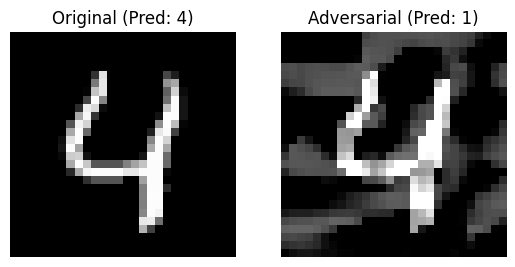

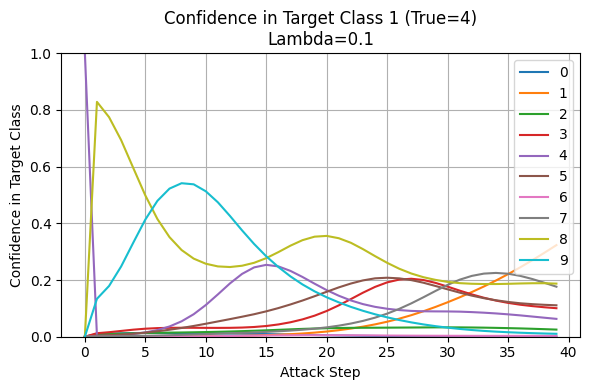

Found adversarial example for True=4, Target=2


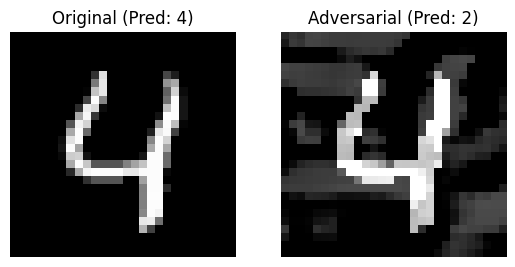

Found adversarial example for True=4, Target=3


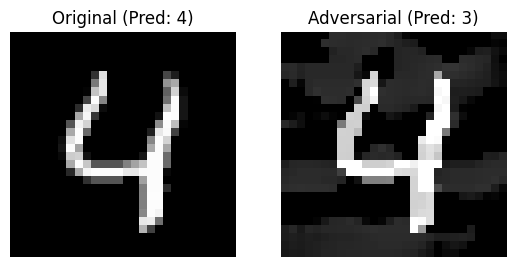

Found adversarial example for True=4, Target=5


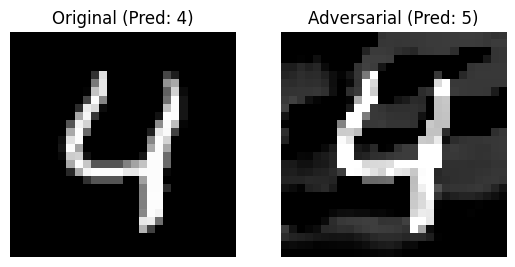

Found adversarial example for True=4, Target=6


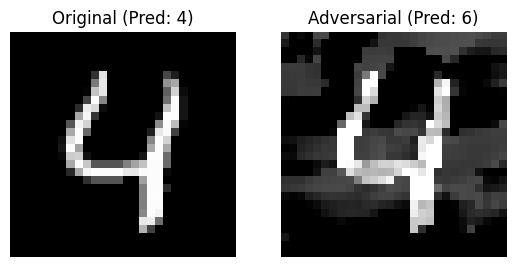

Found adversarial example for True=4, Target=7


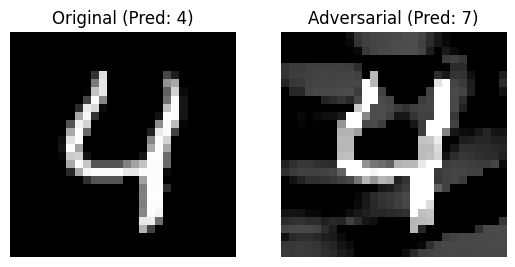

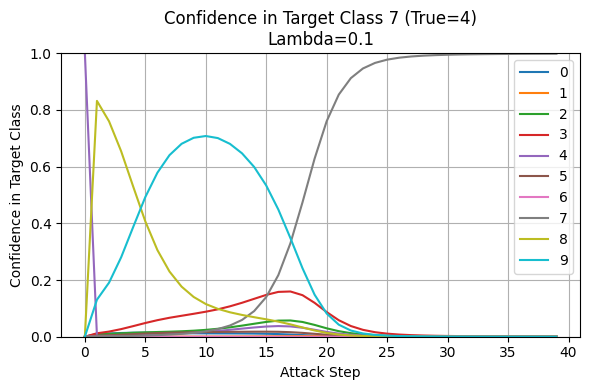

Found adversarial example for True=4, Target=8


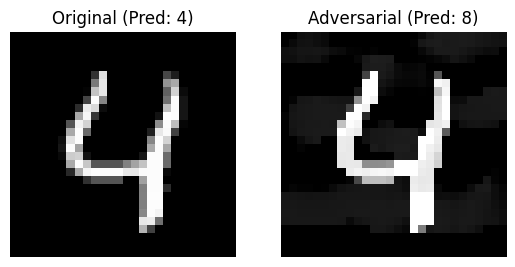

Found adversarial example for True=4, Target=9


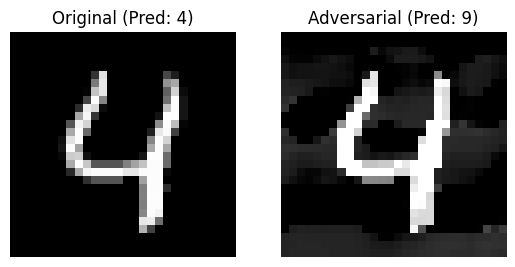

Found adversarial example for True=9, Target=1


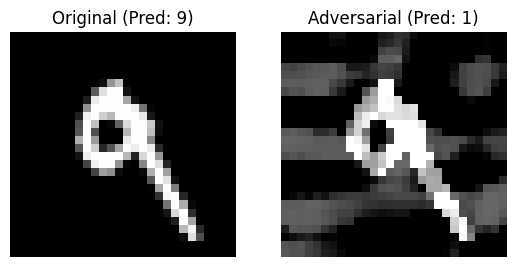

Found adversarial example for True=9, Target=3


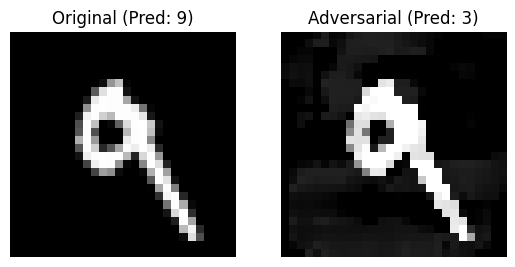

Found adversarial example for True=9, Target=4


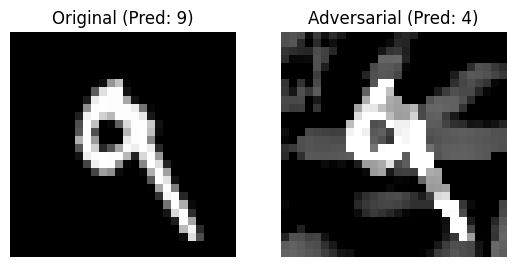

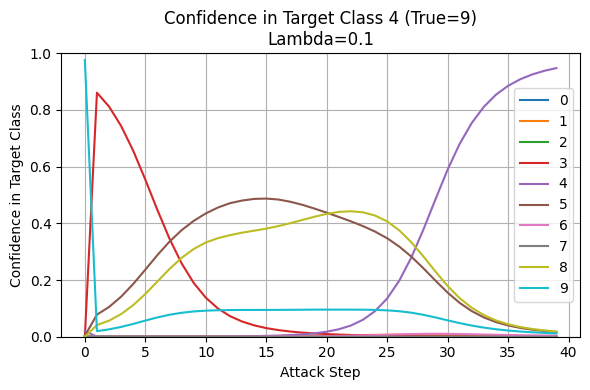

Found adversarial example for True=9, Target=5


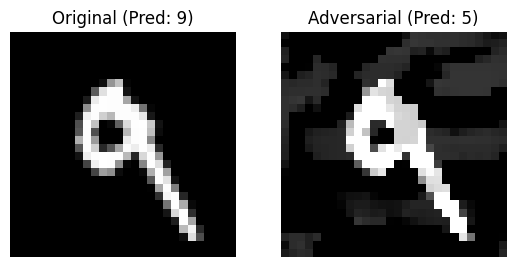

Found adversarial example for True=9, Target=6


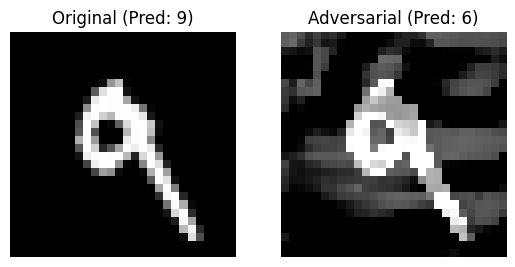

Found adversarial example for True=9, Target=7


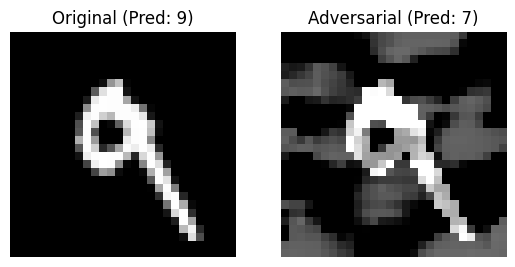

Found adversarial example for True=9, Target=8


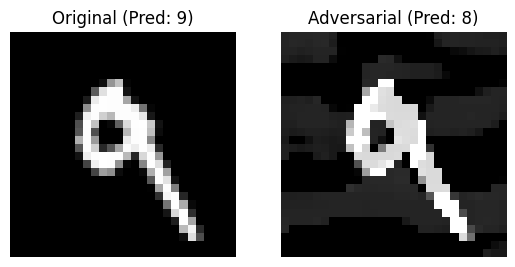

Found adversarial example for True=5, Target=0


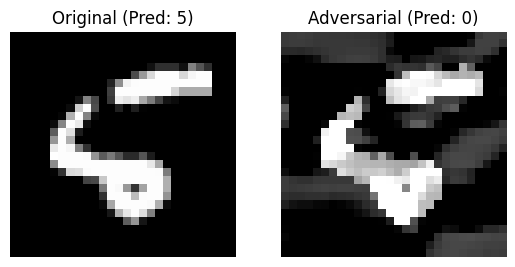

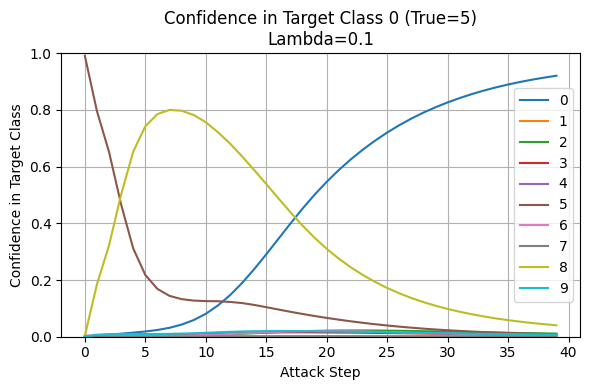

Found adversarial example for True=5, Target=2


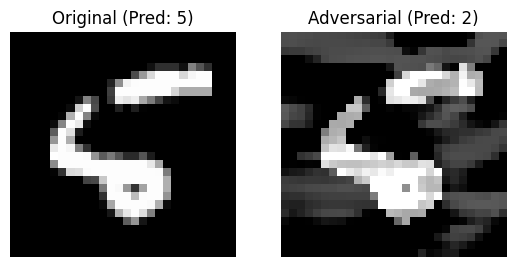

Found adversarial example for True=5, Target=3


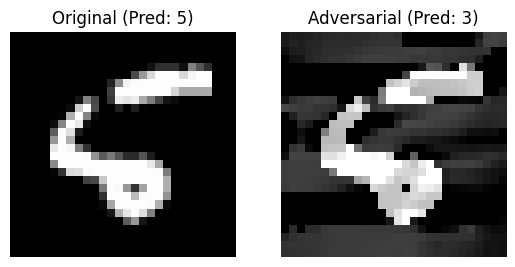

Found adversarial example for True=5, Target=6


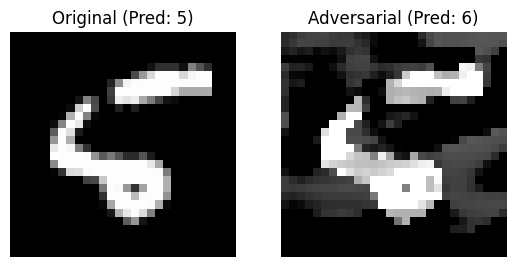

Found adversarial example for True=5, Target=7


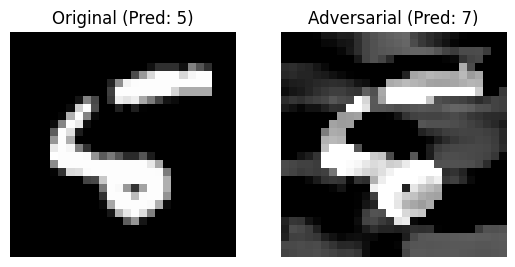

Found adversarial example for True=5, Target=8


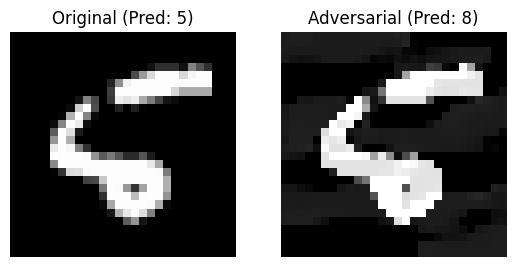

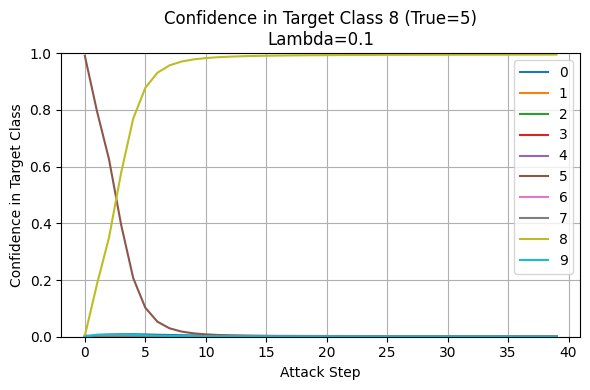

Found adversarial example for True=5, Target=9


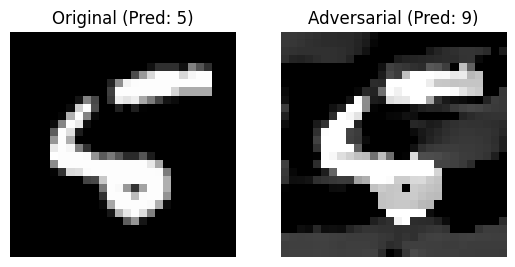

Found adversarial example for True=9, Target=0


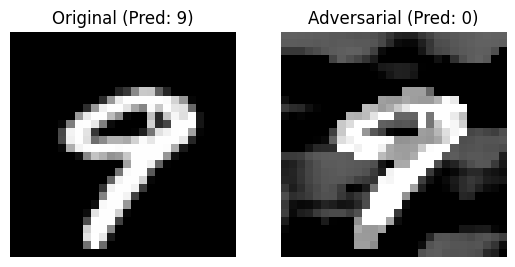

Found adversarial example for True=9, Target=2


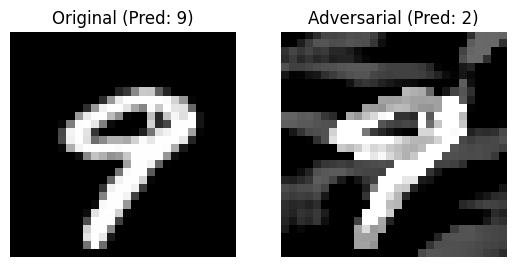

Found adversarial example for True=6, Target=0


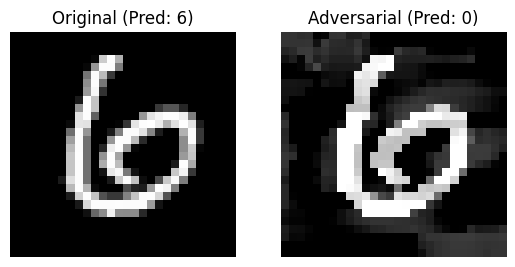

Found adversarial example for True=6, Target=2


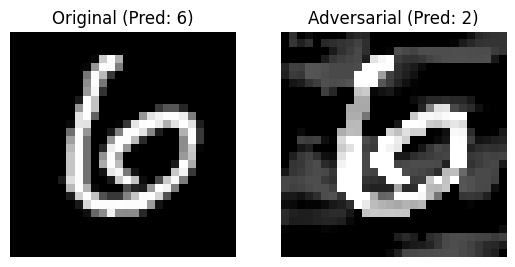

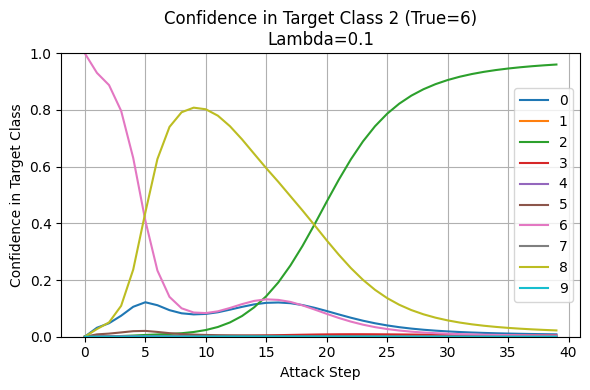

Found adversarial example for True=6, Target=3


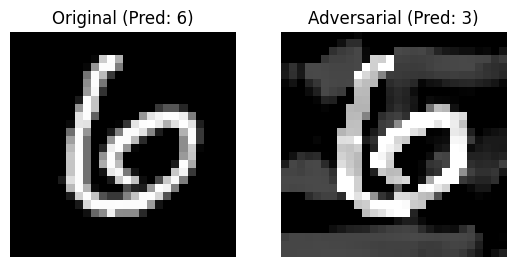

Found adversarial example for True=6, Target=4


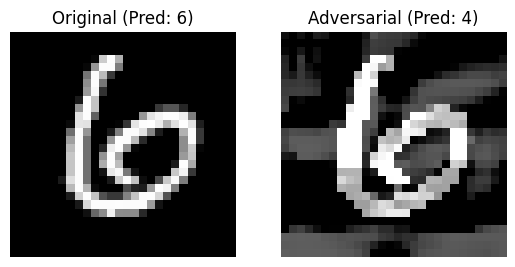

Found adversarial example for True=6, Target=5


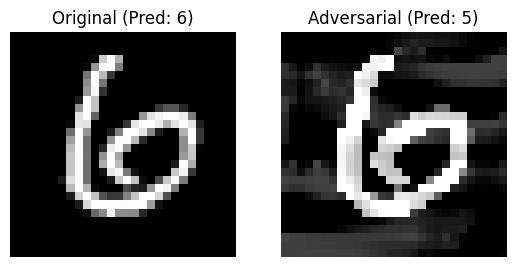

Found adversarial example for True=6, Target=7


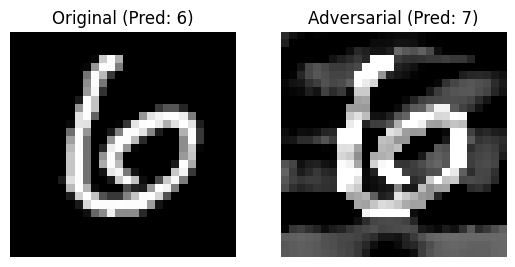

Found adversarial example for True=6, Target=8


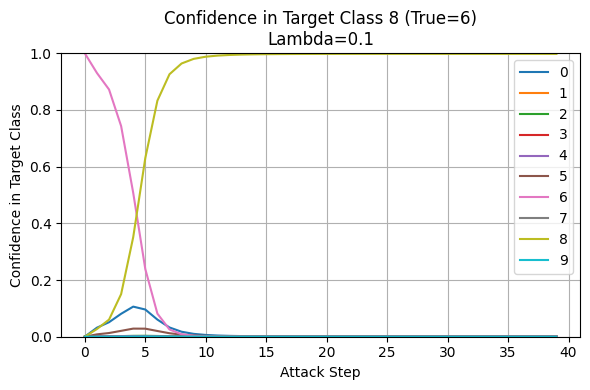

Found adversarial example for True=6, Target=9


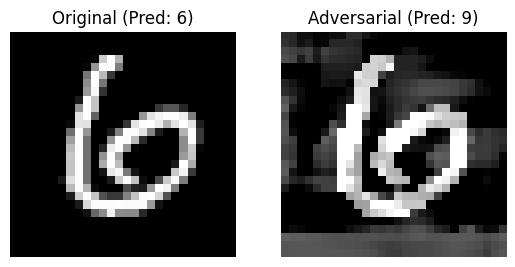

Found adversarial example for True=3, Target=0


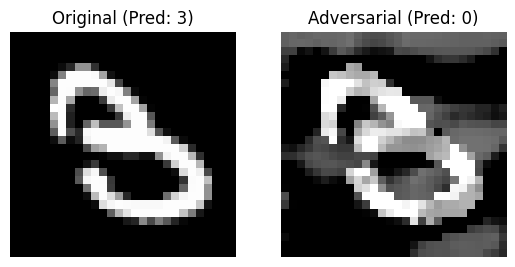

Found adversarial example for True=3, Target=1


Found adversarial example for True=3, Target=2


Found adversarial example for True=3, Target=5


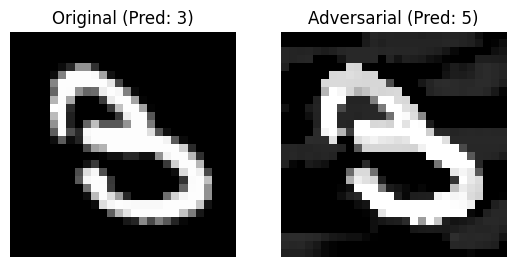

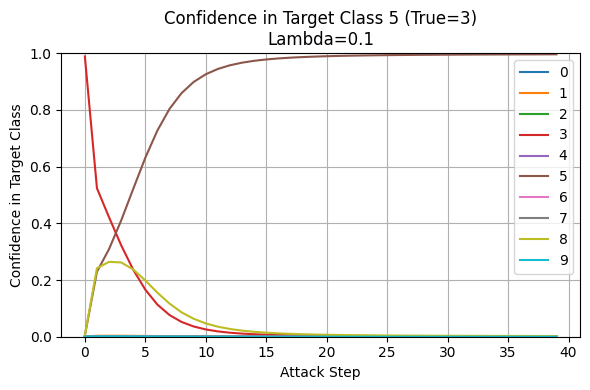

Found adversarial example for True=3, Target=6


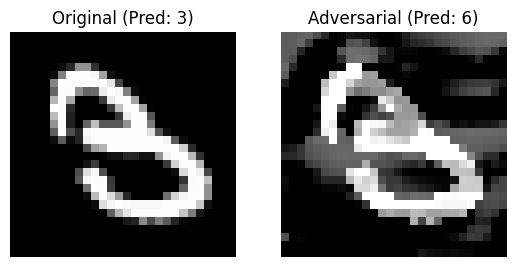

Found adversarial example for True=3, Target=7


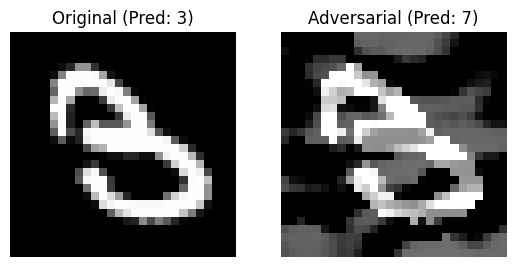

Found adversarial example for True=3, Target=8


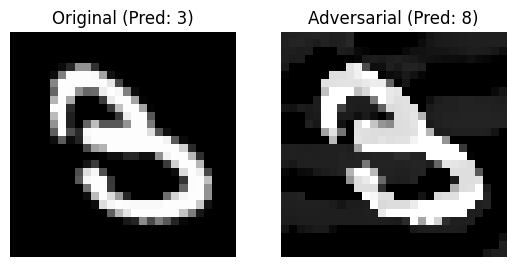

Found adversarial example for True=3, Target=9


Found adversarial example for True=6, Target=1


Found adversarial example for True=7, Target=1


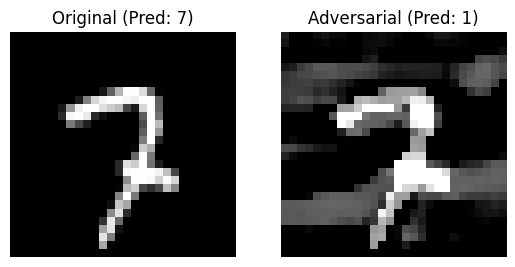

Found adversarial example for True=5, Target=4


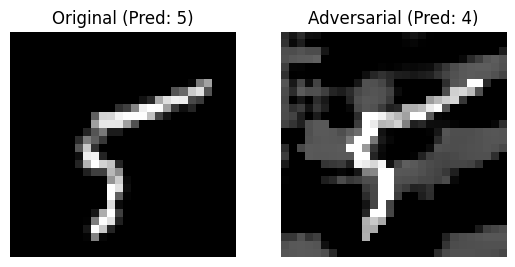

Found adversarial example for True=8, Target=0


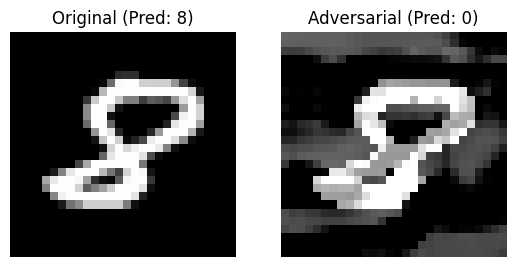

Found adversarial example for True=8, Target=2


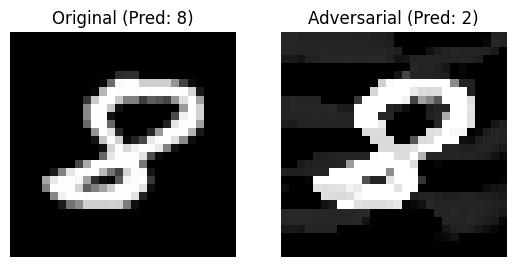

Found adversarial example for True=8, Target=3


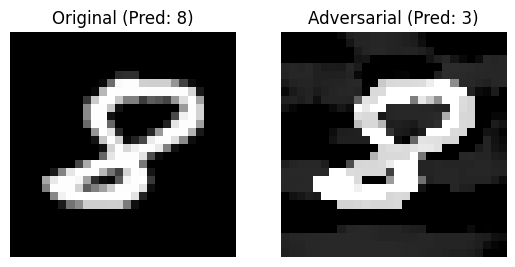

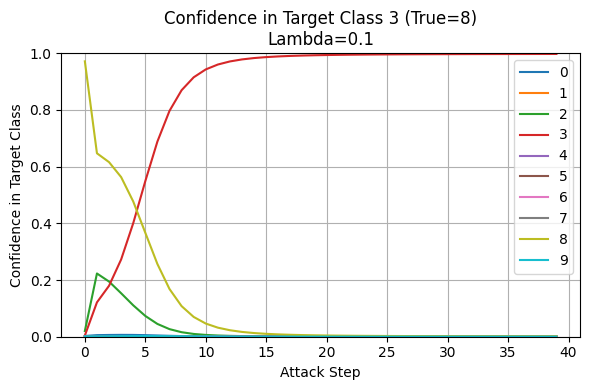

Found adversarial example for True=8, Target=5


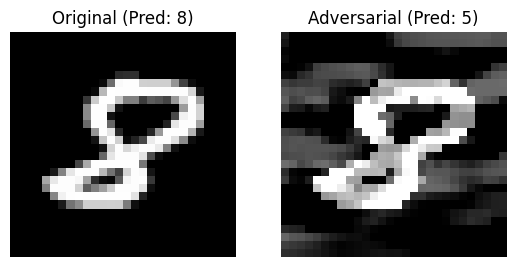

Found adversarial example for True=8, Target=7


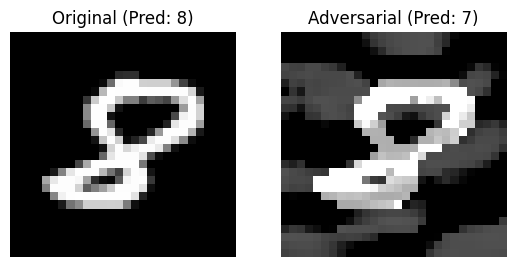

Found adversarial example for True=8, Target=9


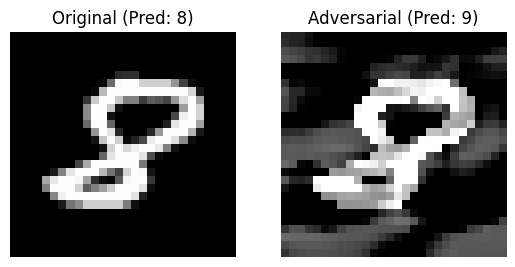

Found adversarial example for True=2, Target=1


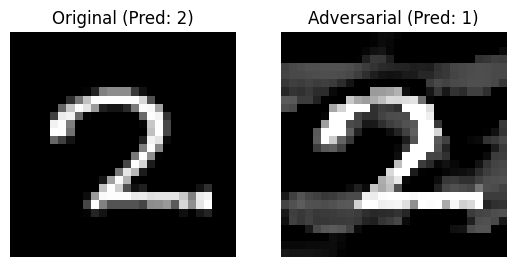

Found adversarial example for True=2, Target=9


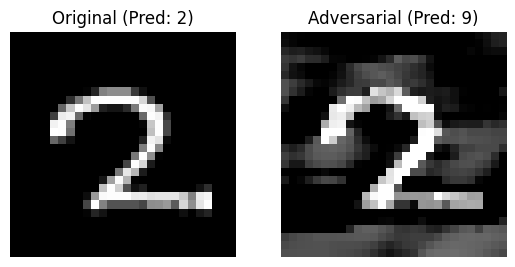

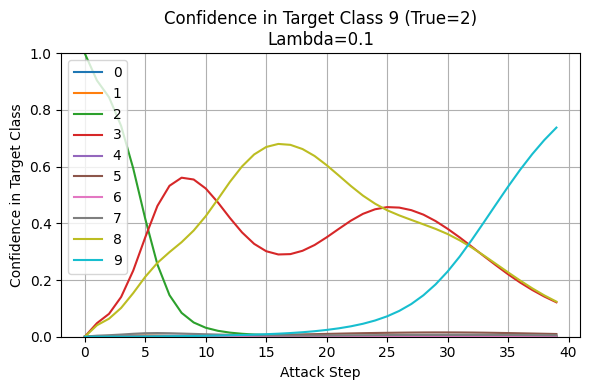

Found adversarial example for True=7, Target=4


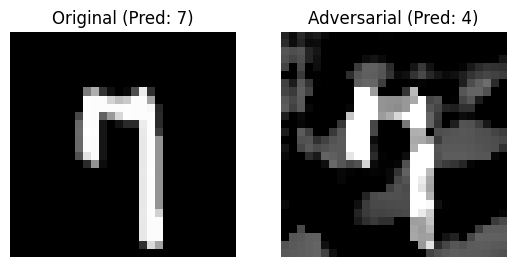

In [25]:
suc_cnt_2, trial_cnt_2 = adversarial_on_testset(0.1)

<ipython-input-26-97a4815b1558>:1: RuntimeWarning: invalid value encountered in divide
  rates = suc_cnt_2/trial_cnt_2


<Axes: >

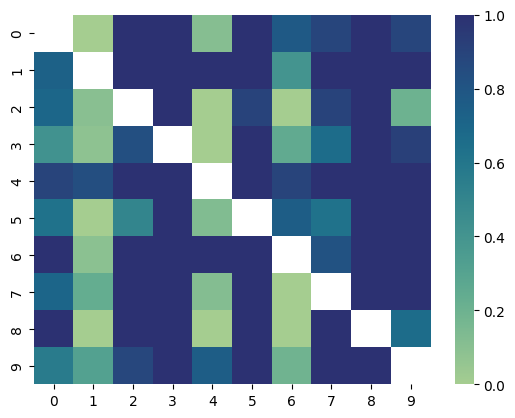

In [26]:
rates = suc_cnt_2/trial_cnt_2
sns.heatmap(rates,cmap="crest")

następnie lambda =1

Found adversarial example for True=7, Target=0


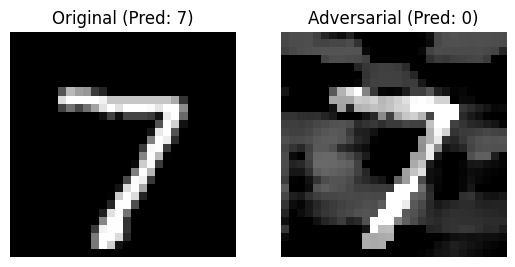

Found adversarial example for True=7, Target=2


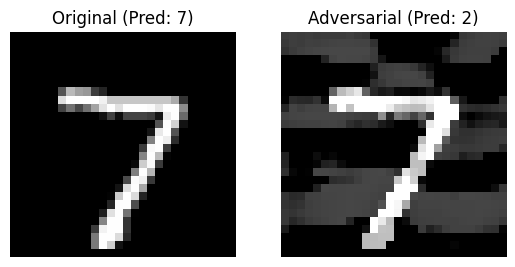

Found adversarial example for True=7, Target=3


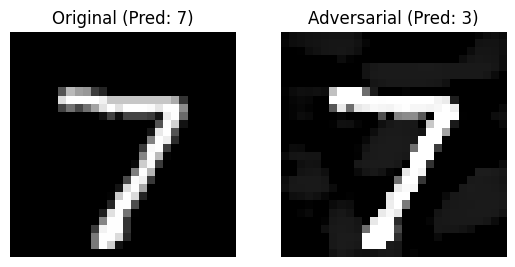

Found adversarial example for True=7, Target=5


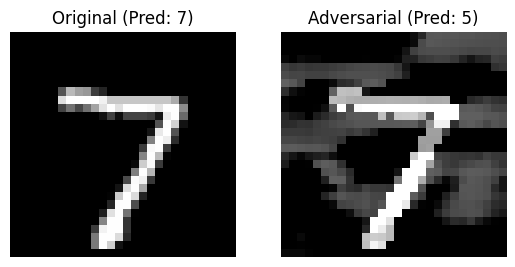

Found adversarial example for True=7, Target=8


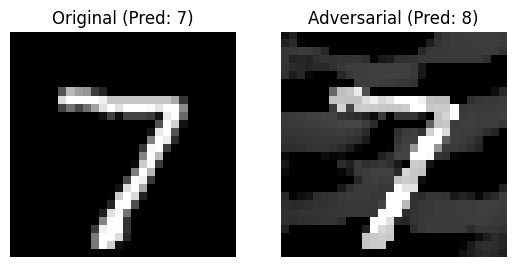

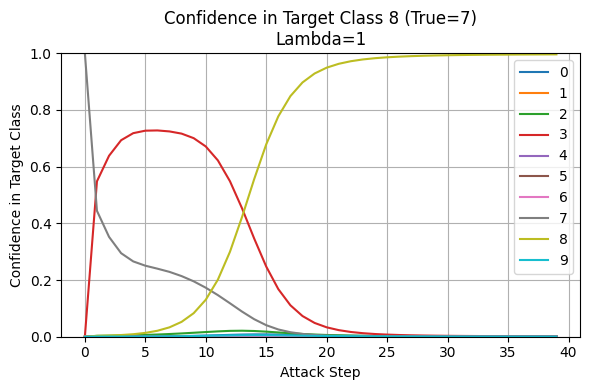

Found adversarial example for True=7, Target=9


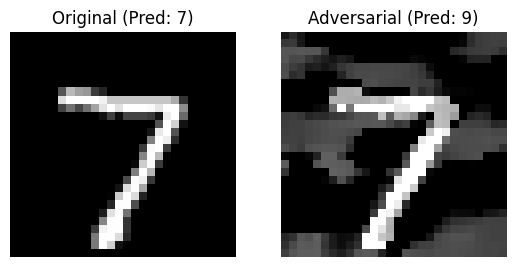

Found adversarial example for True=2, Target=0


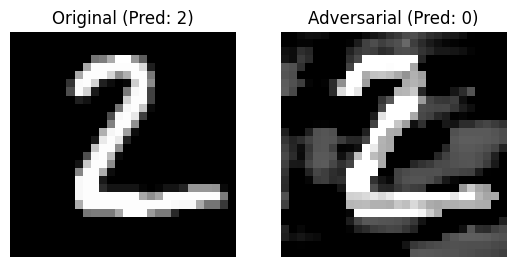

Found adversarial example for True=2, Target=3


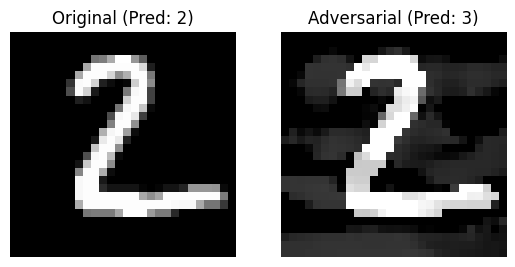

Found adversarial example for True=2, Target=5


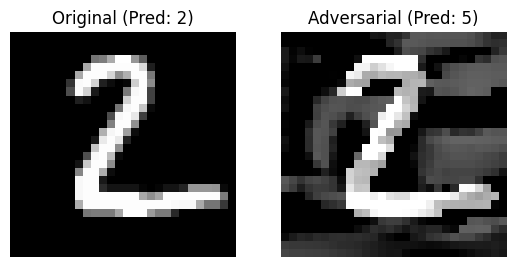

Found adversarial example for True=2, Target=8


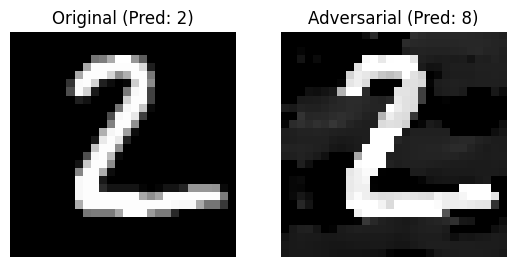

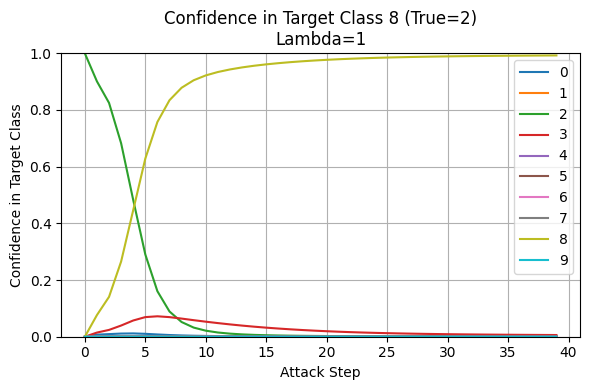

Found adversarial example for True=1, Target=0


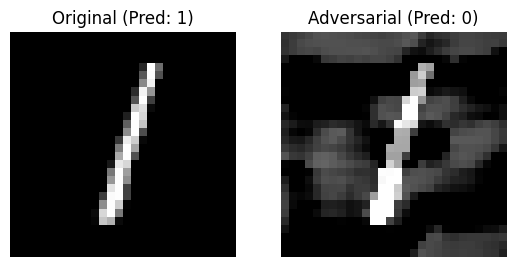

Found adversarial example for True=1, Target=2


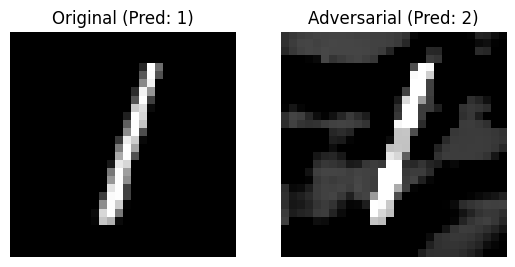

Found adversarial example for True=1, Target=3


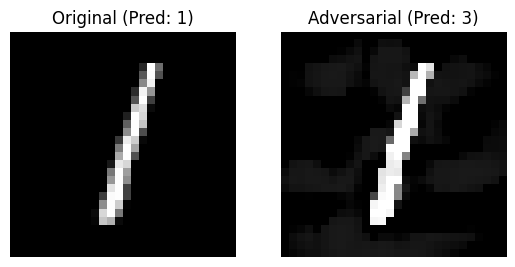

Found adversarial example for True=1, Target=4


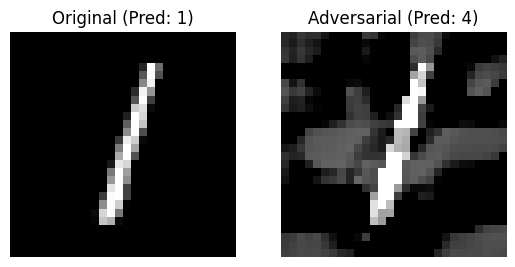

Found adversarial example for True=1, Target=5


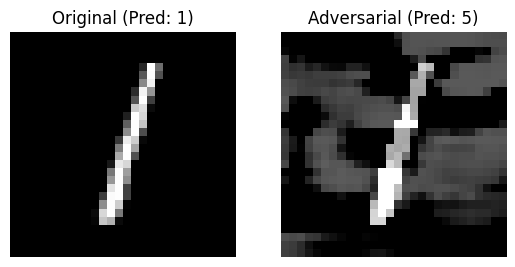

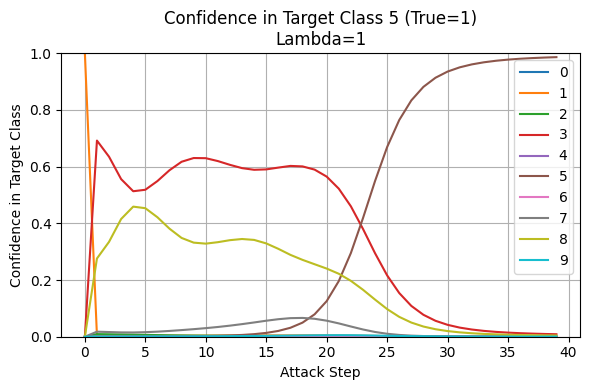

Found adversarial example for True=1, Target=6


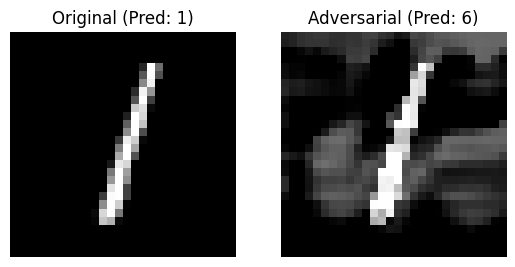

Found adversarial example for True=1, Target=7


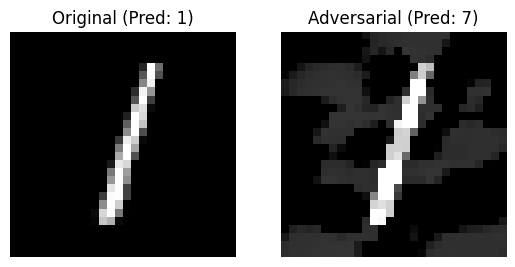

Found adversarial example for True=1, Target=8


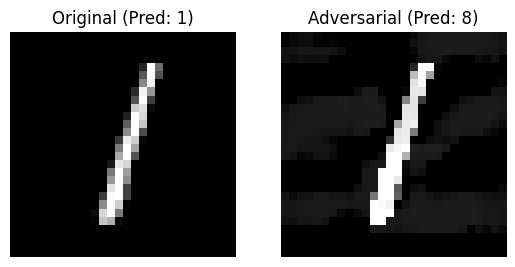

Found adversarial example for True=1, Target=9


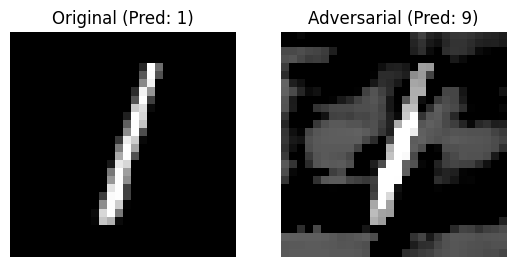

Found adversarial example for True=0, Target=2


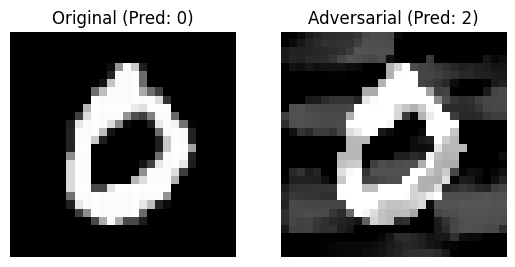

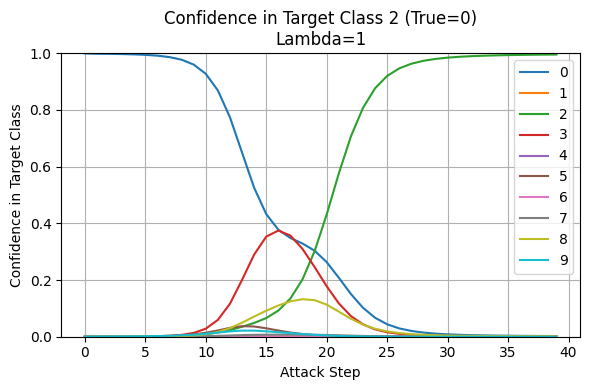

Found adversarial example for True=0, Target=3


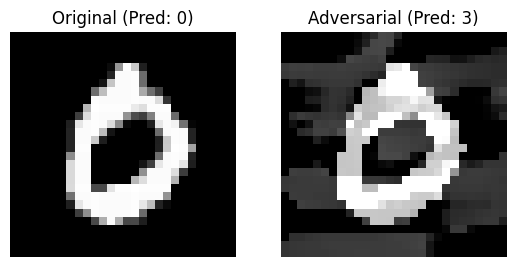

Found adversarial example for True=0, Target=4


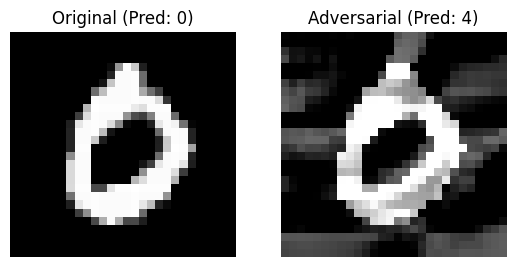

Found adversarial example for True=0, Target=5


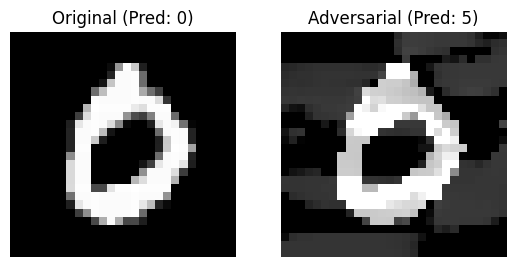

Found adversarial example for True=0, Target=6


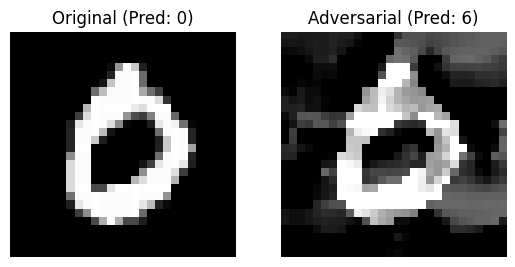

Found adversarial example for True=0, Target=7


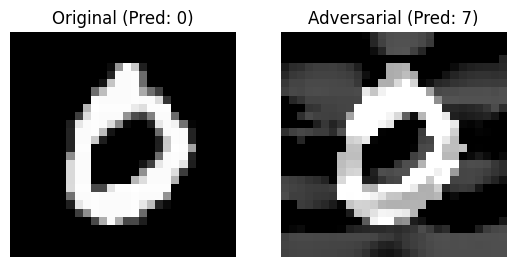

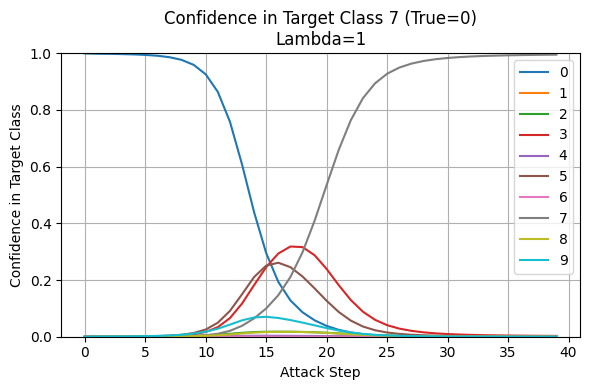

Found adversarial example for True=0, Target=8


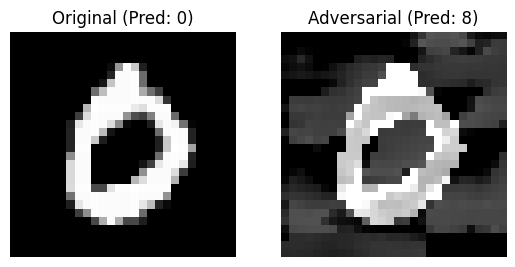

Found adversarial example for True=0, Target=9


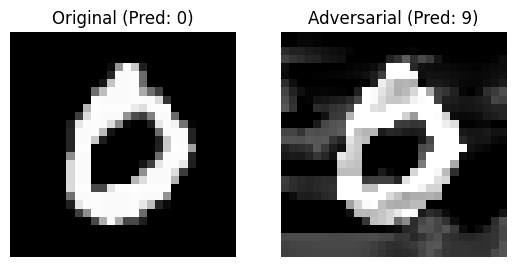

Found adversarial example for True=4, Target=0


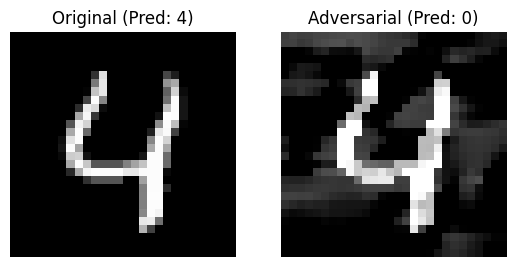

Found adversarial example for True=4, Target=1


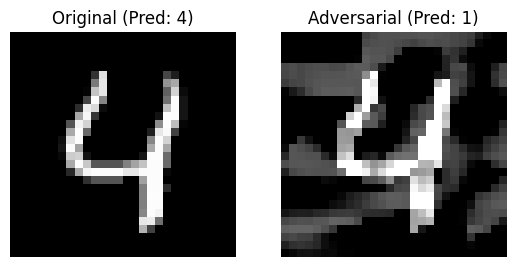

Found adversarial example for True=4, Target=2


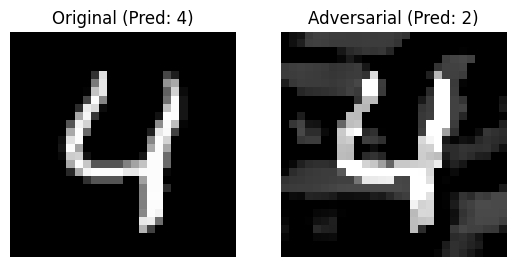

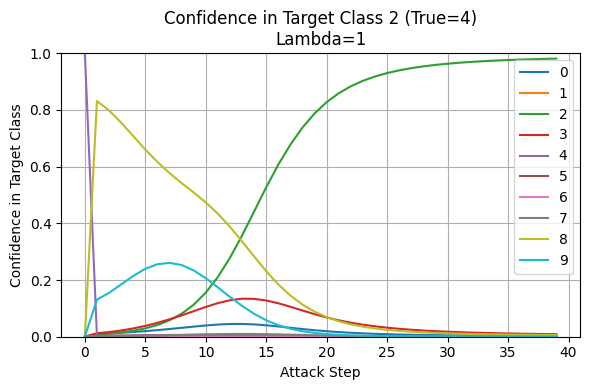

Found adversarial example for True=4, Target=3


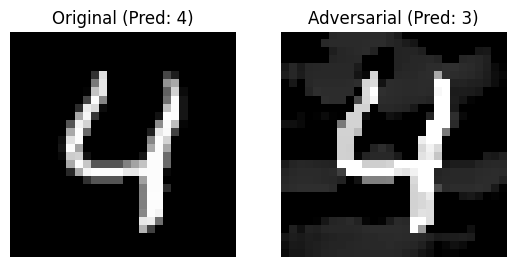

Found adversarial example for True=4, Target=5


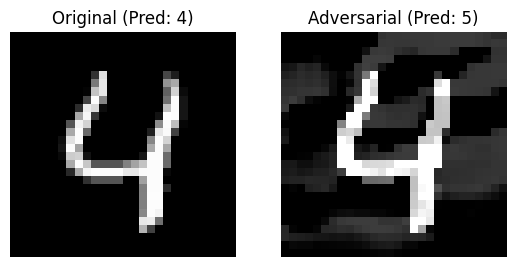

Found adversarial example for True=4, Target=6


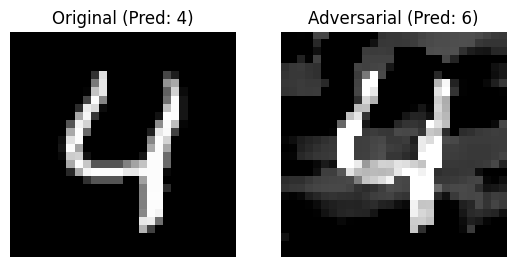

Found adversarial example for True=4, Target=7


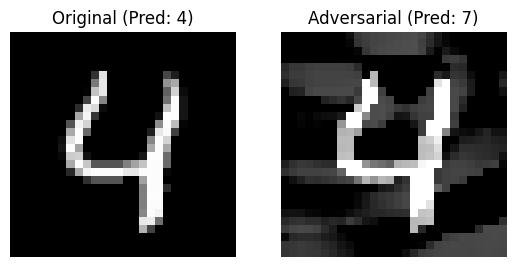

Found adversarial example for True=4, Target=8


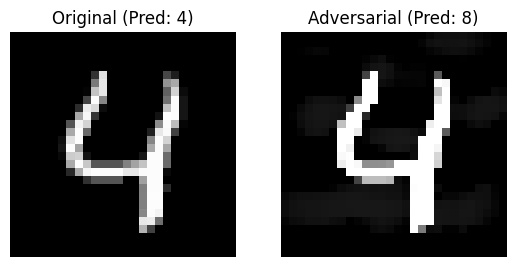

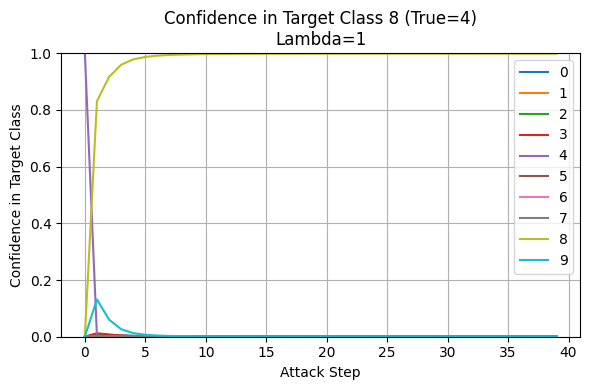

Found adversarial example for True=4, Target=9


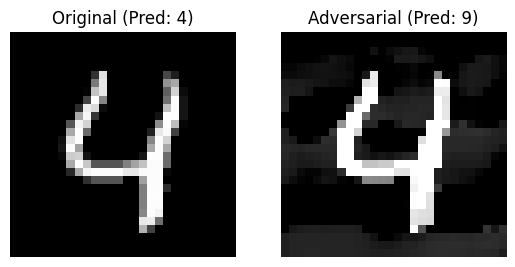

Found adversarial example for True=9, Target=1


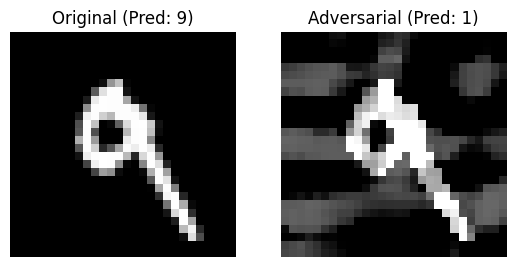

Found adversarial example for True=9, Target=3


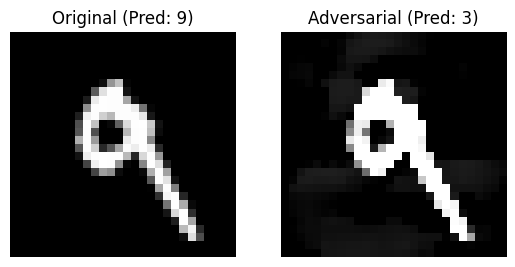

Found adversarial example for True=9, Target=4


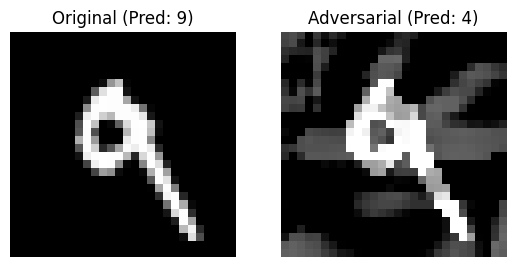

Found adversarial example for True=9, Target=5


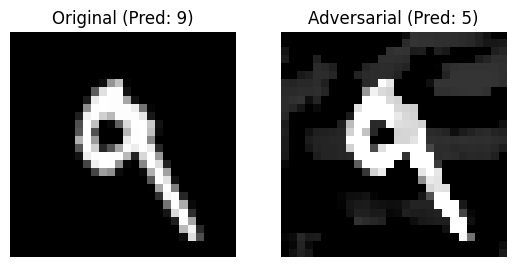

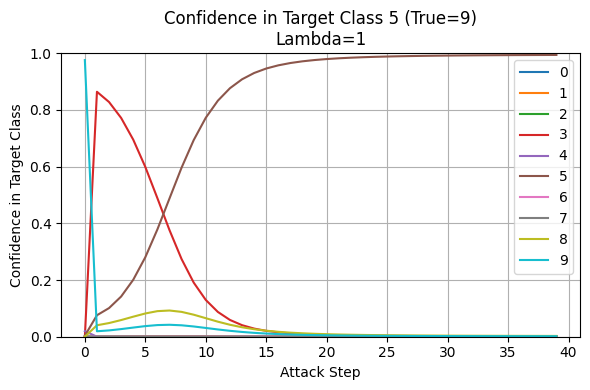

Found adversarial example for True=9, Target=6


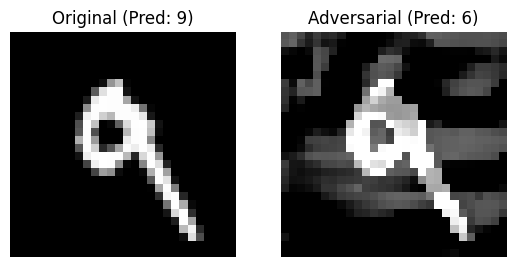

Found adversarial example for True=9, Target=7


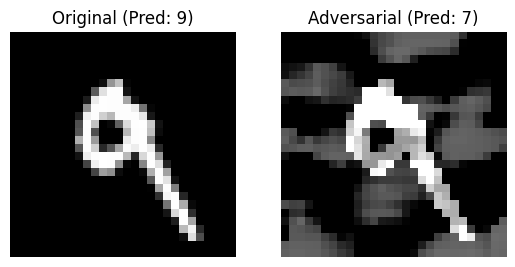

Found adversarial example for True=9, Target=8


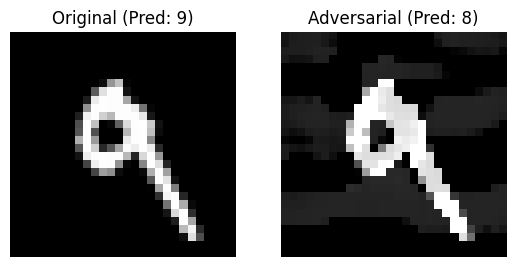

Found adversarial example for True=5, Target=0


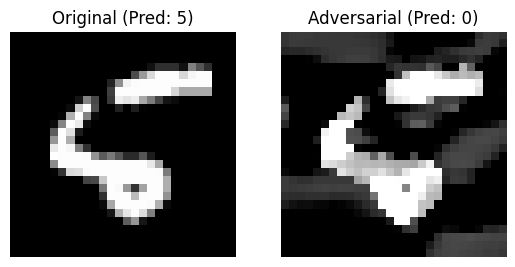

Found adversarial example for True=5, Target=2


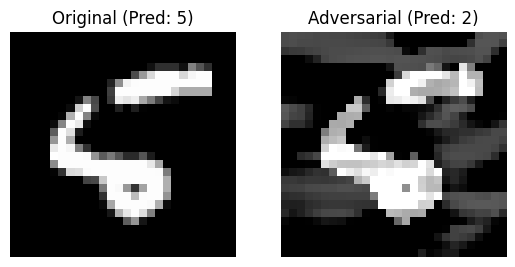

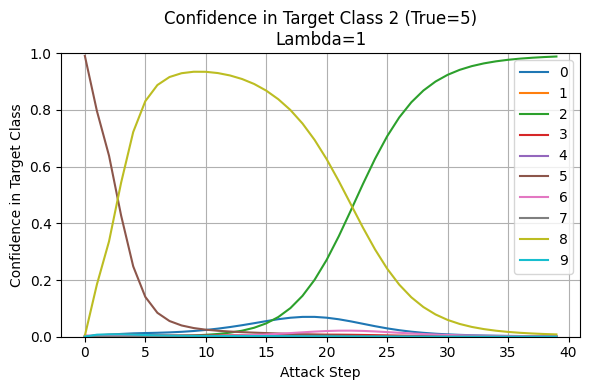

Found adversarial example for True=5, Target=3


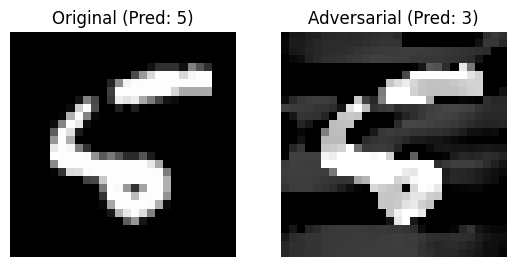

Found adversarial example for True=5, Target=6


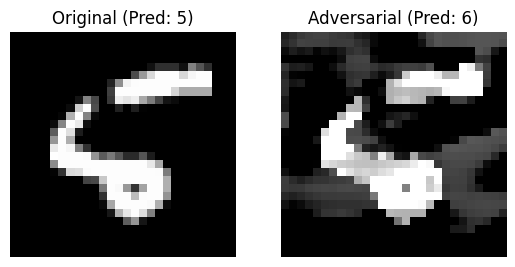

Found adversarial example for True=5, Target=7


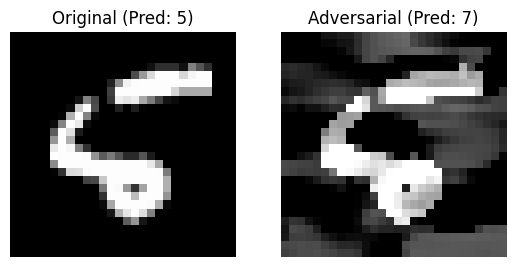

Found adversarial example for True=5, Target=8


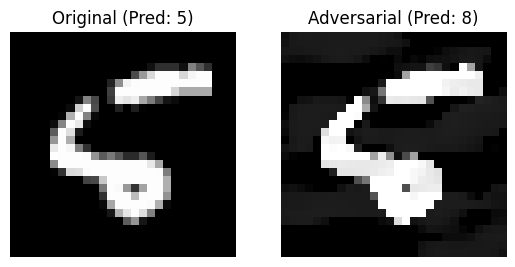

Found adversarial example for True=5, Target=9


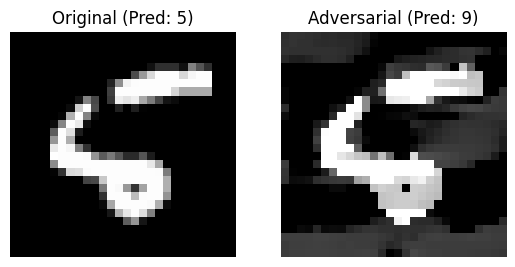

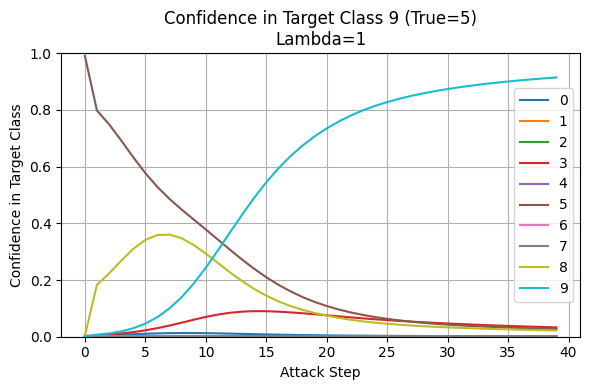

Found adversarial example for True=9, Target=0


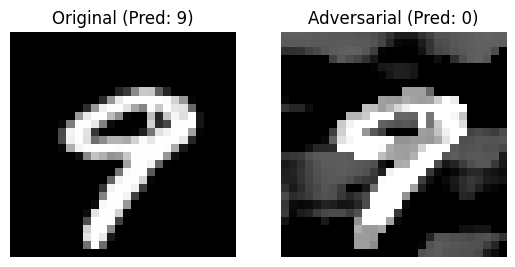

Found adversarial example for True=9, Target=2


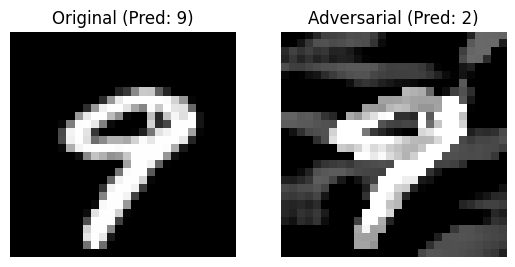

Found adversarial example for True=6, Target=0


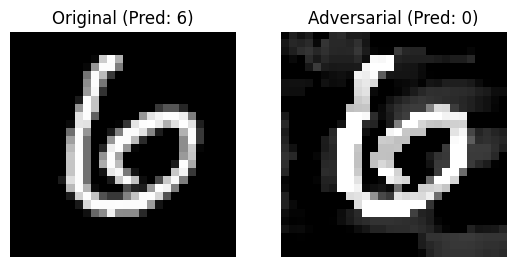

Found adversarial example for True=6, Target=2


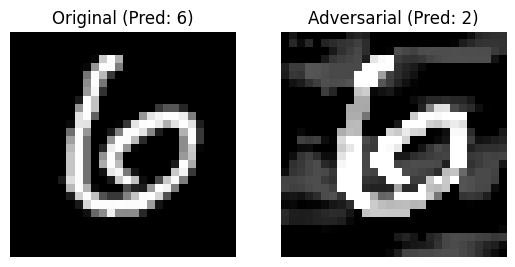

Found adversarial example for True=6, Target=3


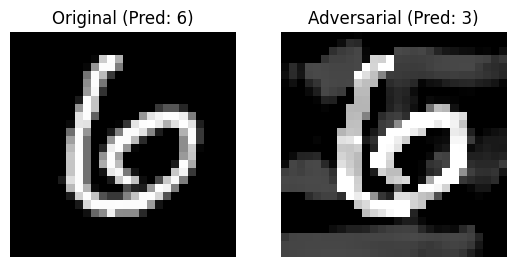

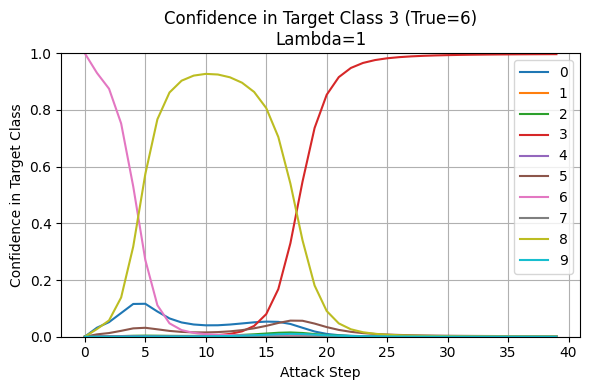

Found adversarial example for True=6, Target=4


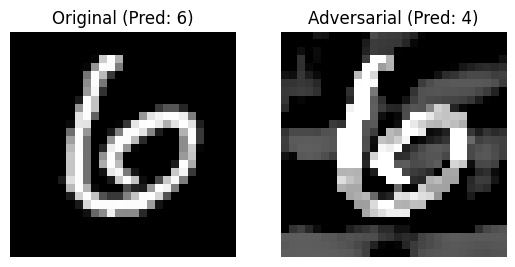

Found adversarial example for True=6, Target=5


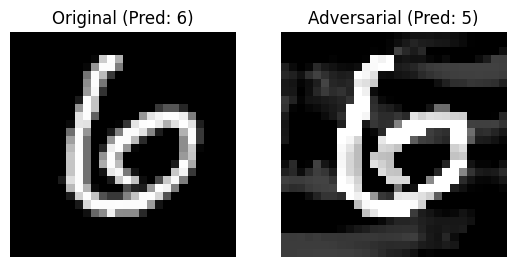

Found adversarial example for True=6, Target=7


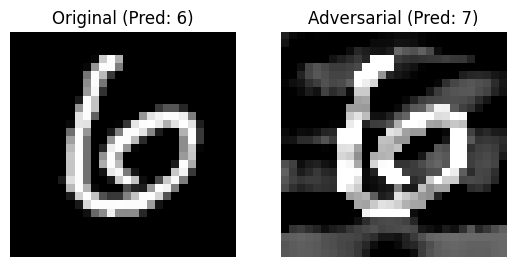

Found adversarial example for True=6, Target=8


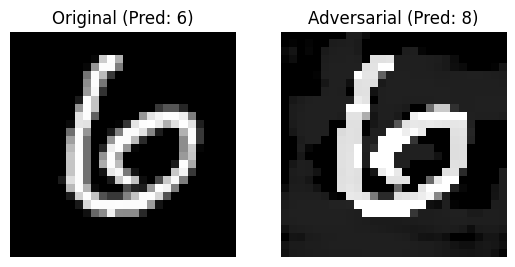

Found adversarial example for True=6, Target=9


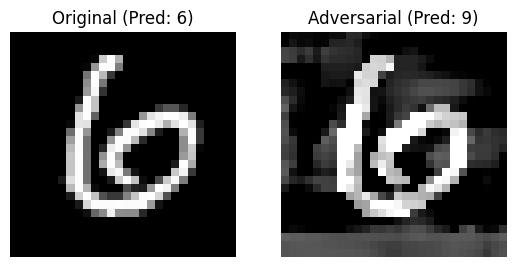

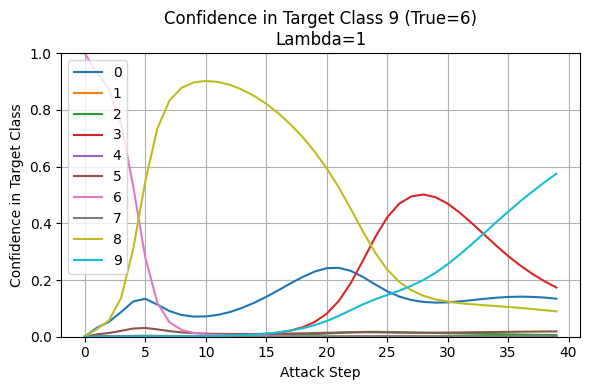

Found adversarial example for True=3, Target=0


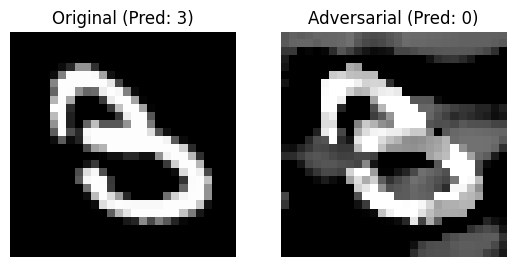

Found adversarial example for True=3, Target=1


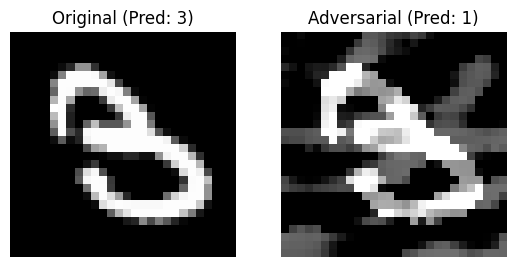

Found adversarial example for True=3, Target=2


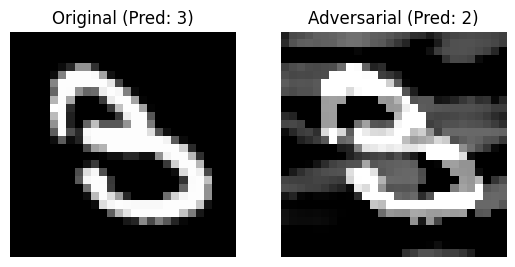

Found adversarial example for True=3, Target=5


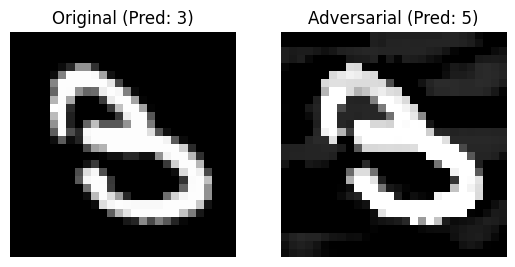

Found adversarial example for True=3, Target=7


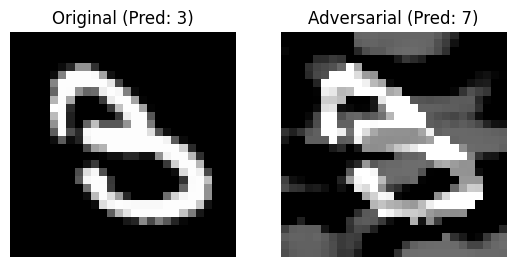

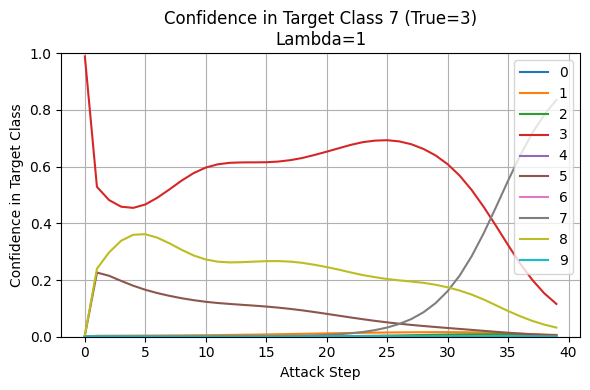

Found adversarial example for True=3, Target=8


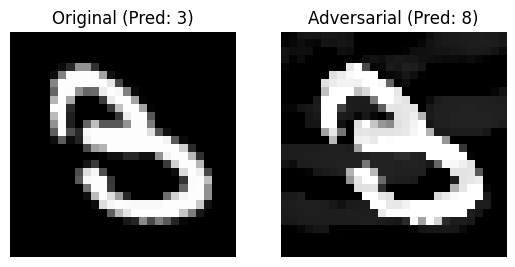

Found adversarial example for True=3, Target=9


Found adversarial example for True=6, Target=1


Found adversarial example for True=2, Target=7


Found adversarial example for True=7, Target=1


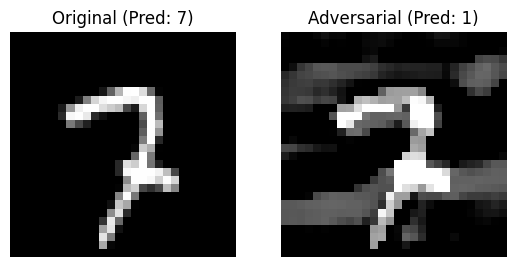

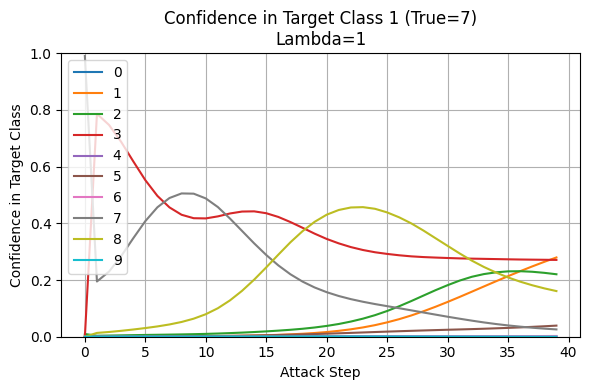

Found adversarial example for True=3, Target=6


Found adversarial example for True=5, Target=4


Found adversarial example for True=8, Target=0


Found adversarial example for True=8, Target=2


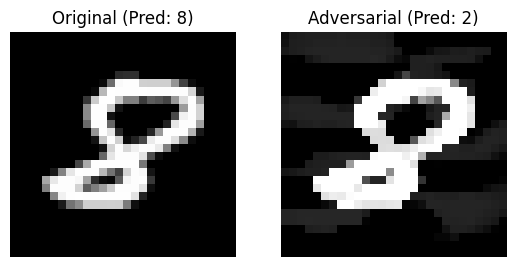

Found adversarial example for True=8, Target=3


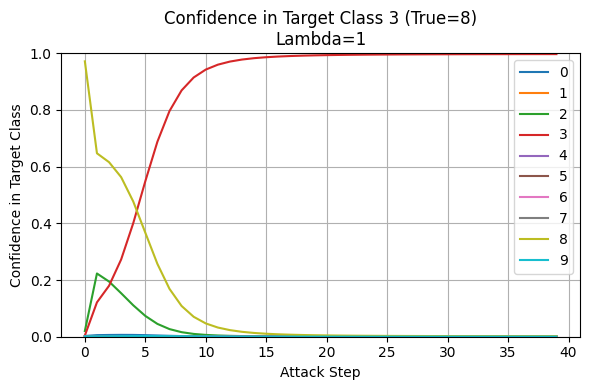

Found adversarial example for True=8, Target=5


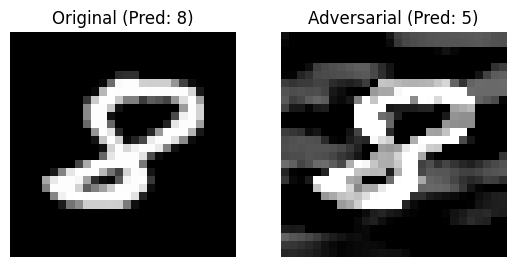

Found adversarial example for True=8, Target=7


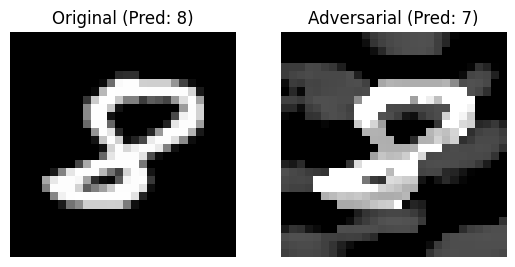

Found adversarial example for True=8, Target=9


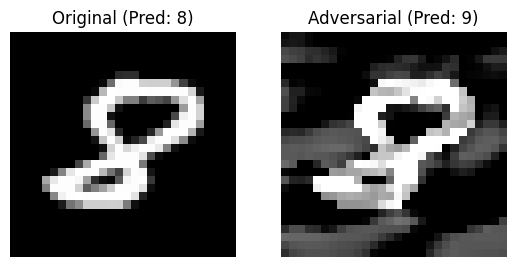

Found adversarial example for True=2, Target=1


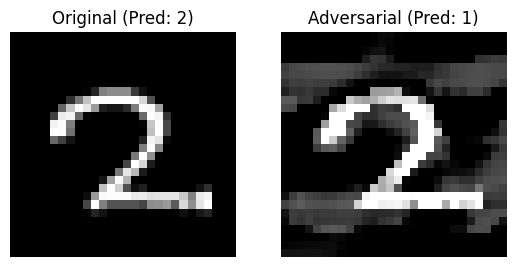

Found adversarial example for True=2, Target=9


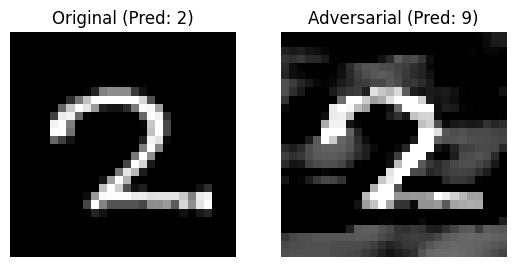

Found adversarial example for True=7, Target=4


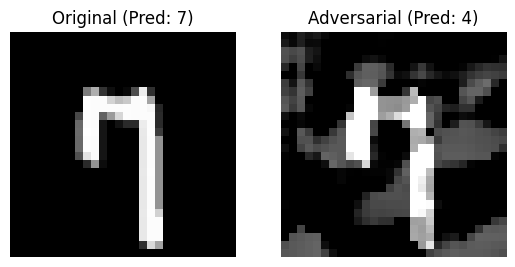

In [27]:
suc_cnt_3, trial_cnt_3 = adversarial_on_testset(1)

<ipython-input-28-daca195873e5>:1: RuntimeWarning: invalid value encountered in divide
  rates = suc_cnt_3/trial_cnt_3


<Axes: >

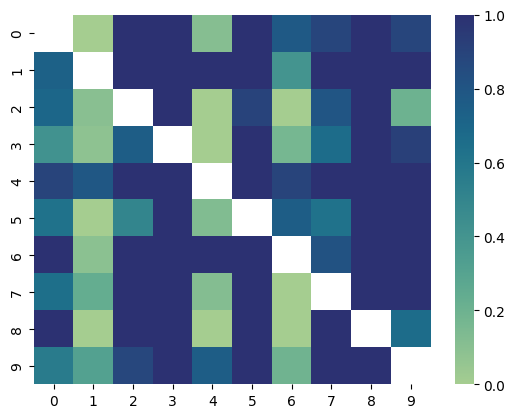

In [28]:
rates = suc_cnt_3/trial_cnt_3
sns.heatmap(rates,cmap="crest")

Na koniec lambda = 10

Found adversarial example for True=7, Target=0


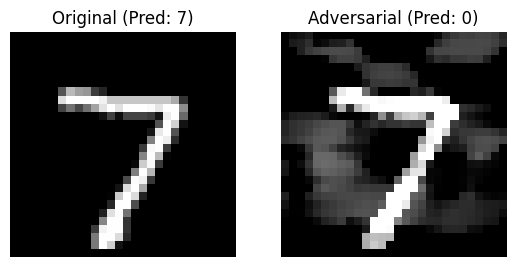

Found adversarial example for True=7, Target=2


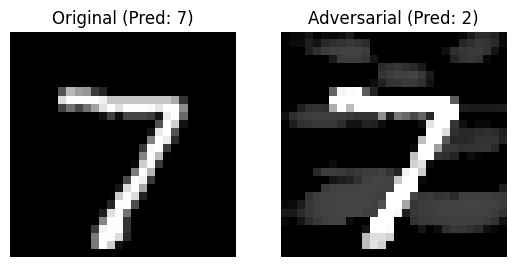

Found adversarial example for True=7, Target=3


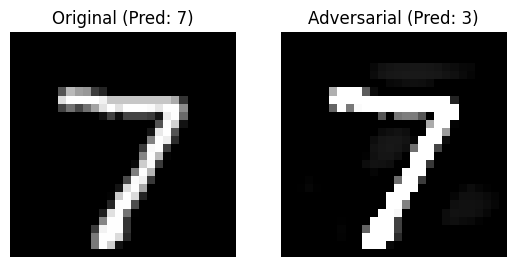

Found adversarial example for True=7, Target=5


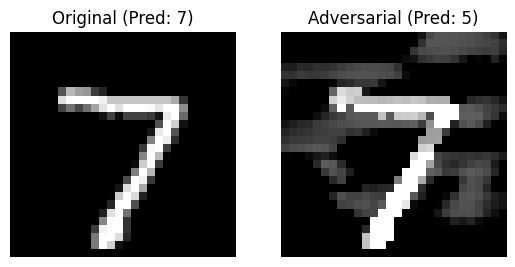

Found adversarial example for True=7, Target=8


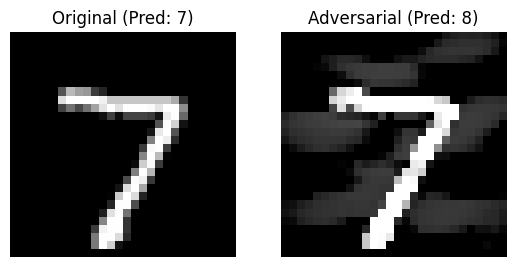

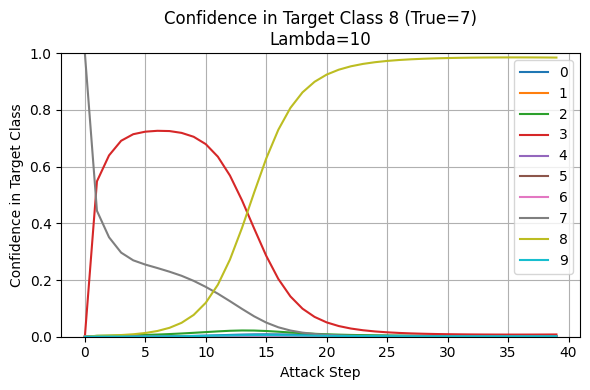

Found adversarial example for True=7, Target=9


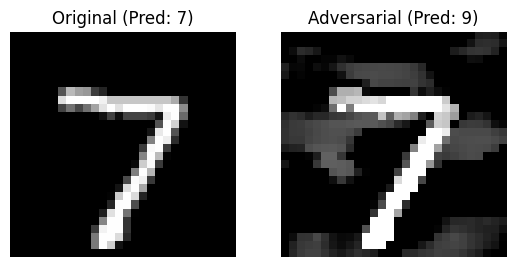

Found adversarial example for True=2, Target=0


Found adversarial example for True=2, Target=3


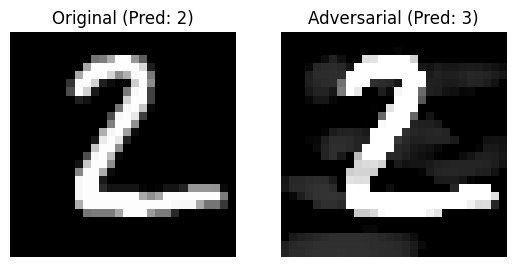

Found adversarial example for True=2, Target=5


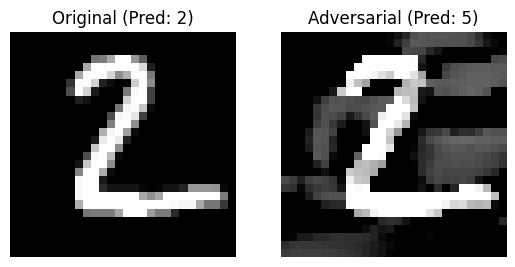

Found adversarial example for True=2, Target=8


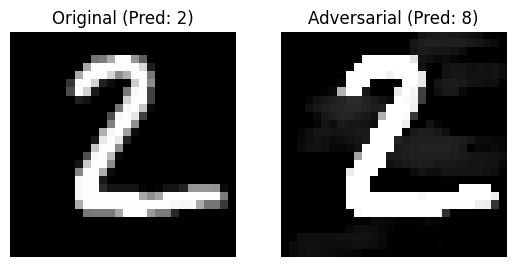

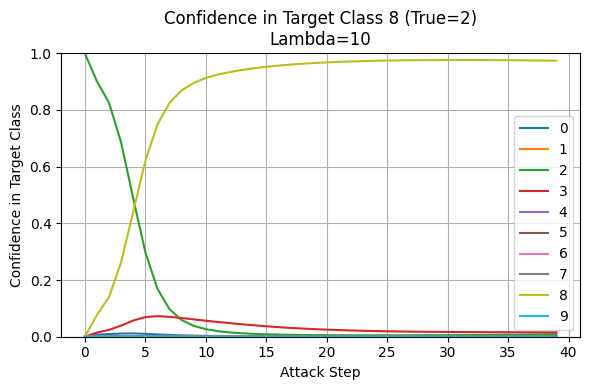

Found adversarial example for True=1, Target=0


Found adversarial example for True=1, Target=2


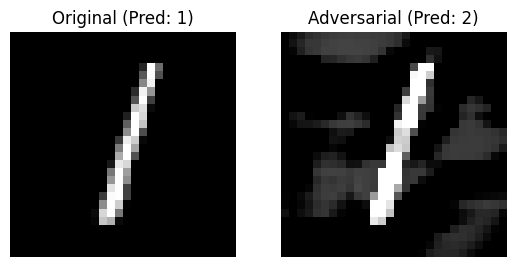

Found adversarial example for True=1, Target=3


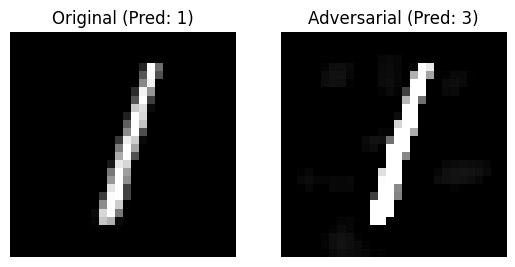

Found adversarial example for True=1, Target=4


Found adversarial example for True=1, Target=5


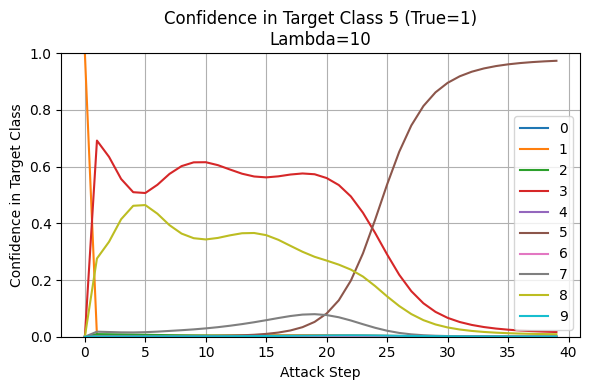

Found adversarial example for True=1, Target=7


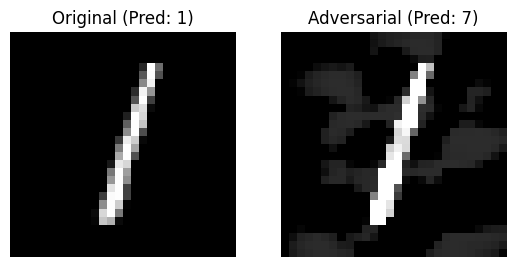

Found adversarial example for True=1, Target=8


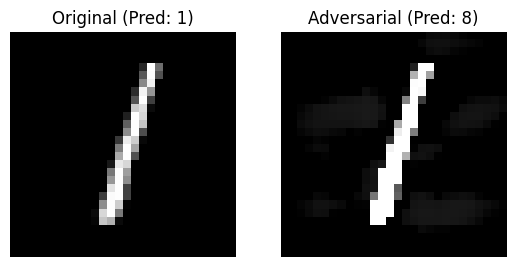

Found adversarial example for True=1, Target=9


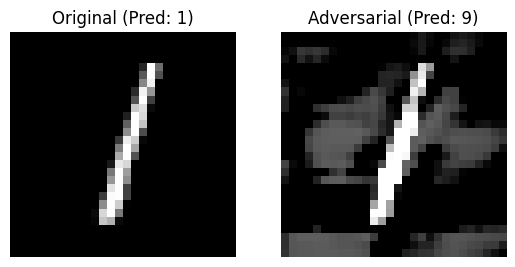

Found adversarial example for True=0, Target=2


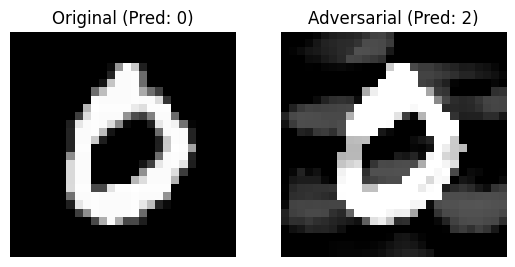

Found adversarial example for True=0, Target=3


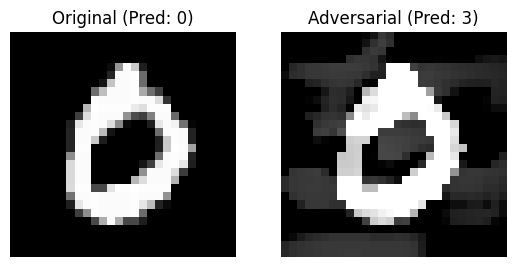

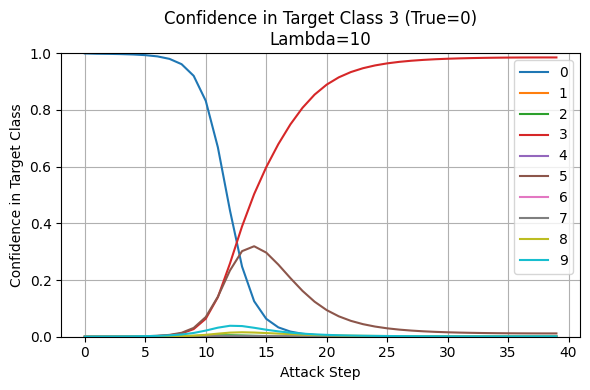

Found adversarial example for True=0, Target=4


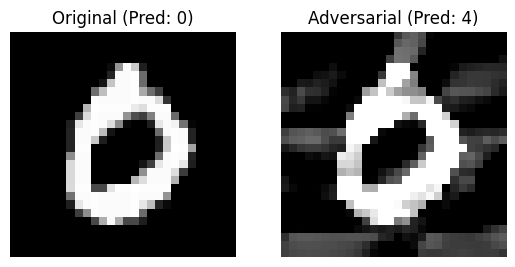

Found adversarial example for True=0, Target=5


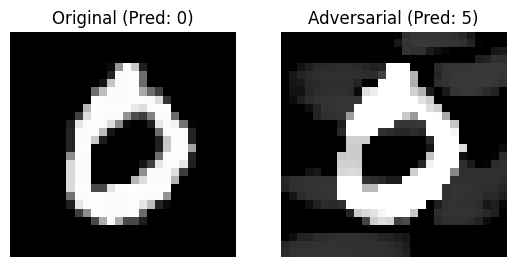

Found adversarial example for True=0, Target=6


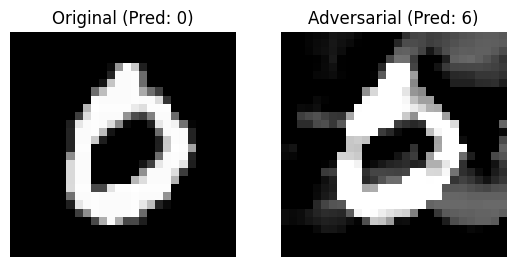

Found adversarial example for True=0, Target=7


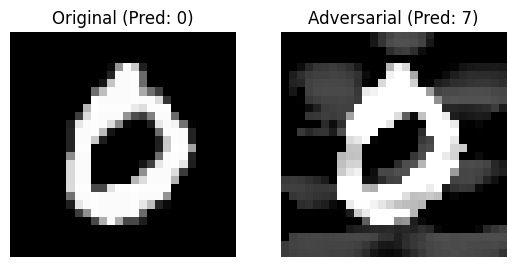

Found adversarial example for True=0, Target=8


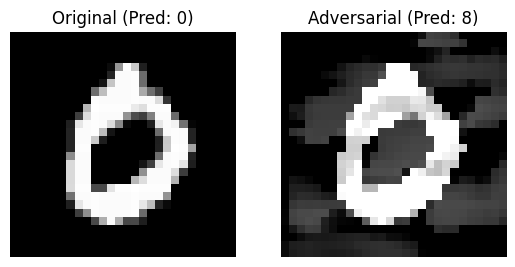

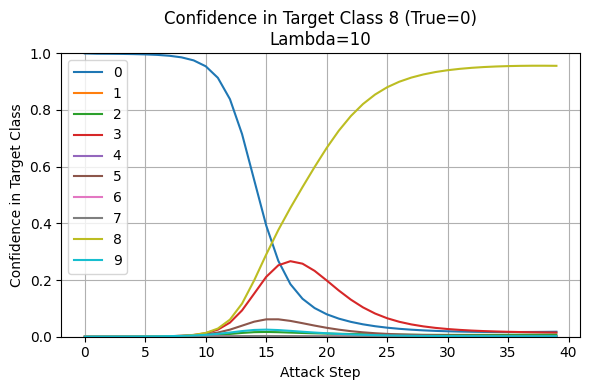

Found adversarial example for True=0, Target=9


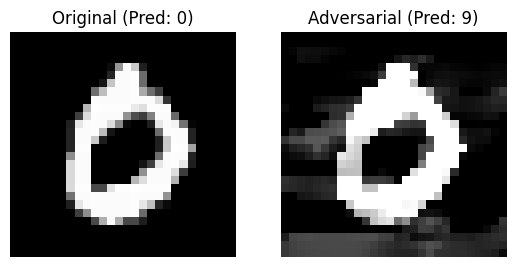

Found adversarial example for True=4, Target=0


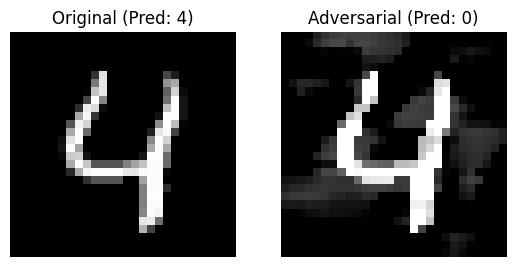

Found adversarial example for True=4, Target=1


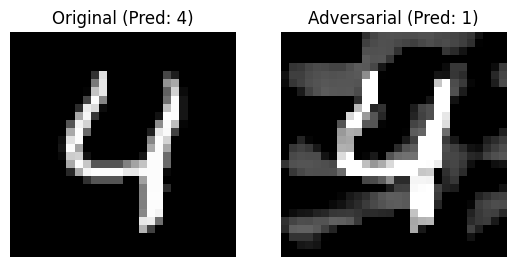

Found adversarial example for True=4, Target=2


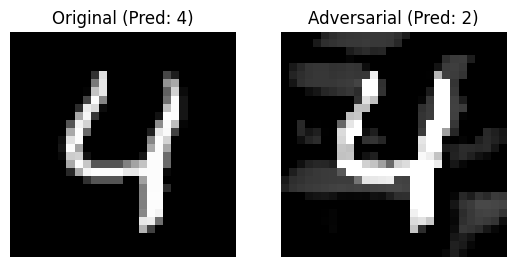

Found adversarial example for True=4, Target=3


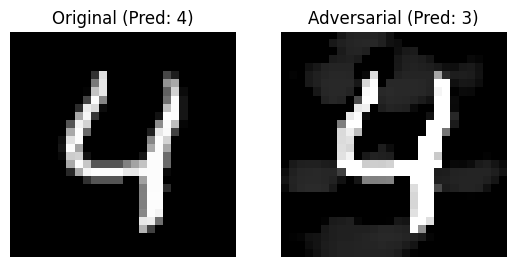

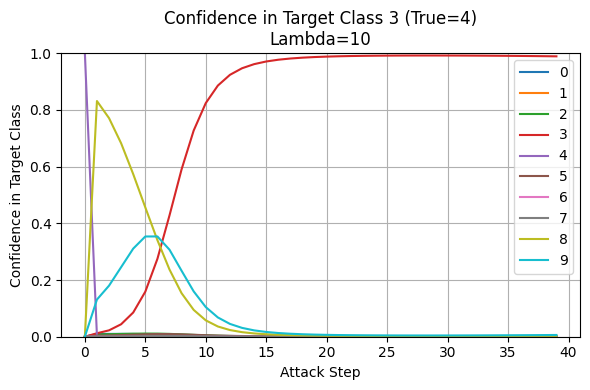

Found adversarial example for True=4, Target=5


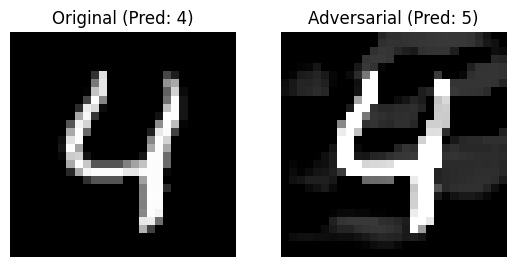

Found adversarial example for True=4, Target=6


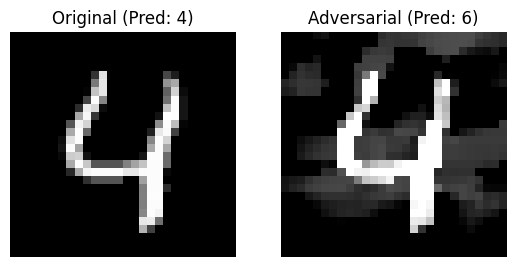

Found adversarial example for True=4, Target=7


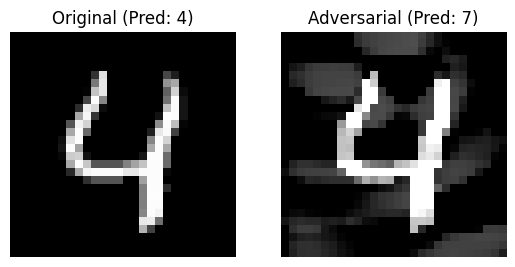

Found adversarial example for True=4, Target=8


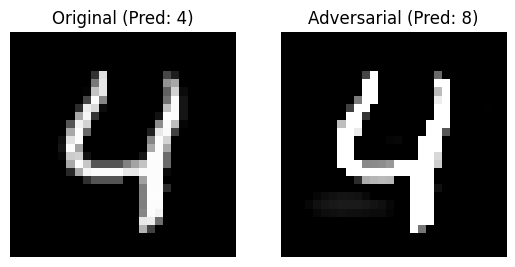

Found adversarial example for True=4, Target=9


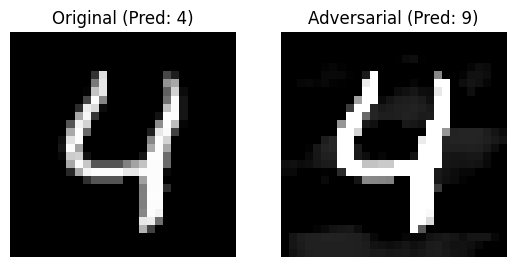

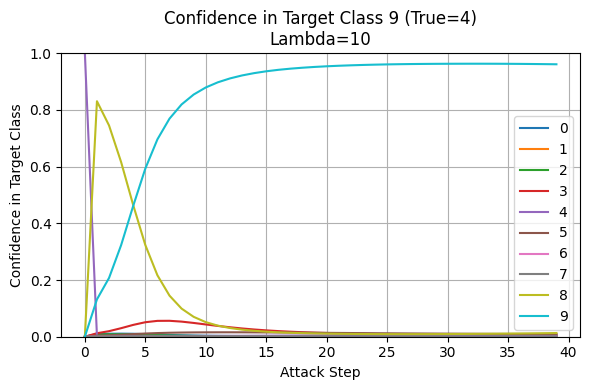

Found adversarial example for True=9, Target=3


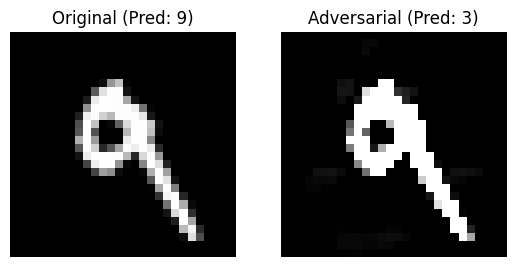

Found adversarial example for True=9, Target=4


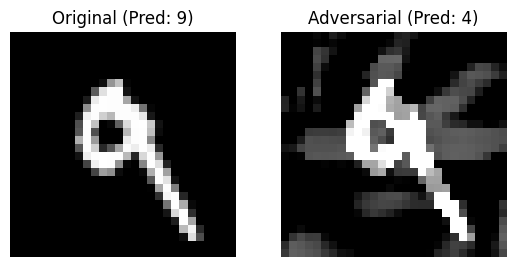

Found adversarial example for True=9, Target=5


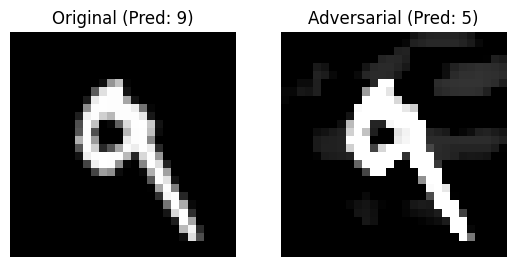

Found adversarial example for True=9, Target=7


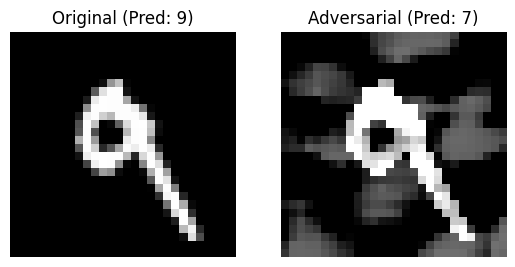

Found adversarial example for True=9, Target=8


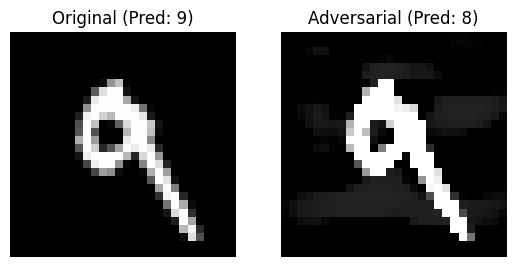

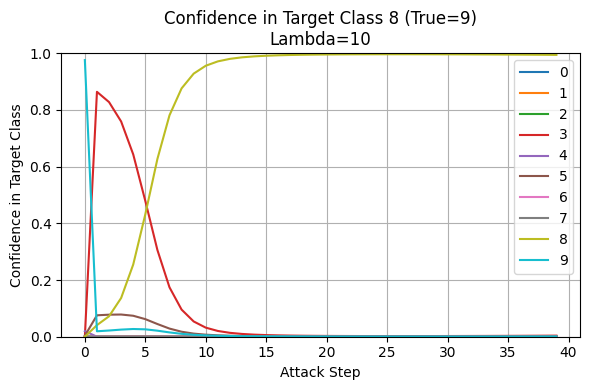

Found adversarial example for True=5, Target=0


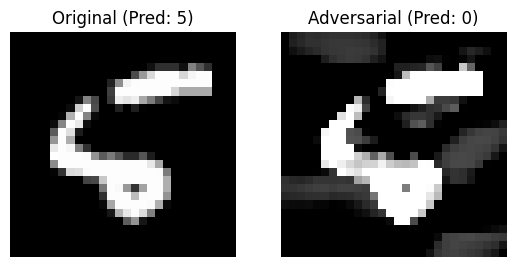

Found adversarial example for True=5, Target=2


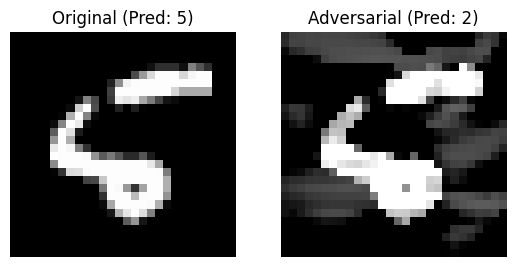

Found adversarial example for True=5, Target=3


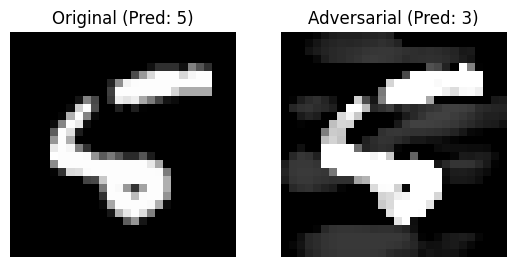

Found adversarial example for True=5, Target=6


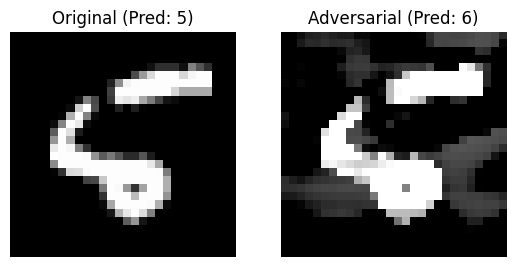

Found adversarial example for True=5, Target=7


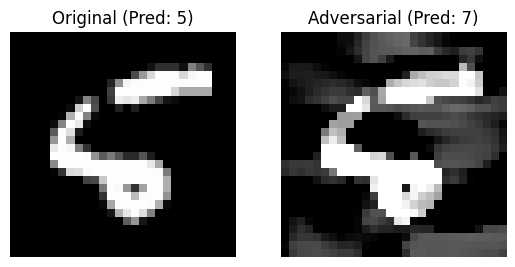

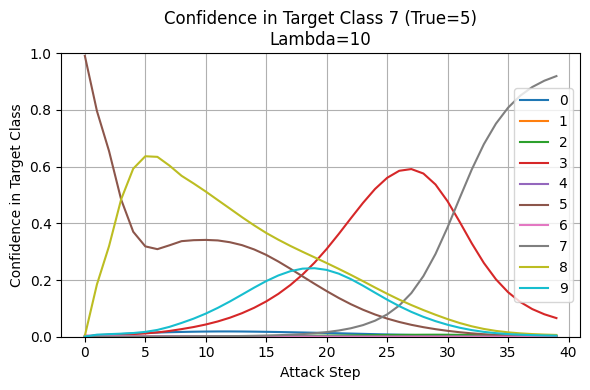

Found adversarial example for True=5, Target=8


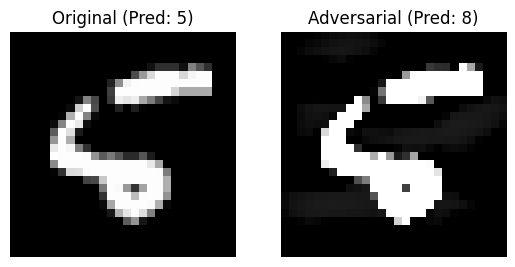

Found adversarial example for True=5, Target=9


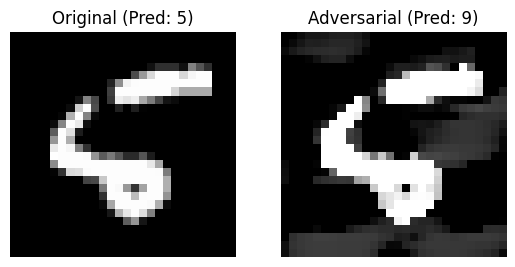

Found adversarial example for True=9, Target=0


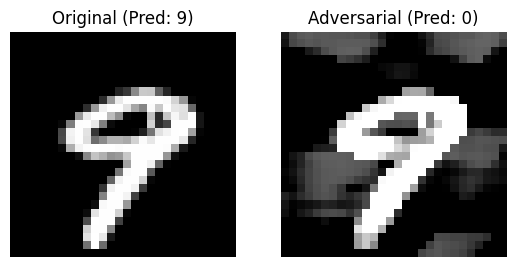

Found adversarial example for True=9, Target=2


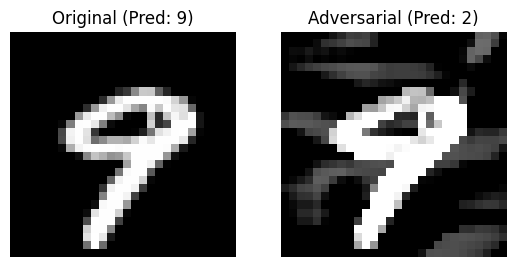

Found adversarial example for True=6, Target=0


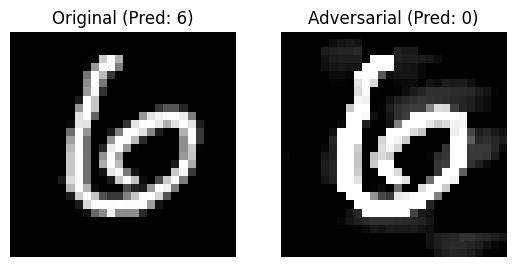

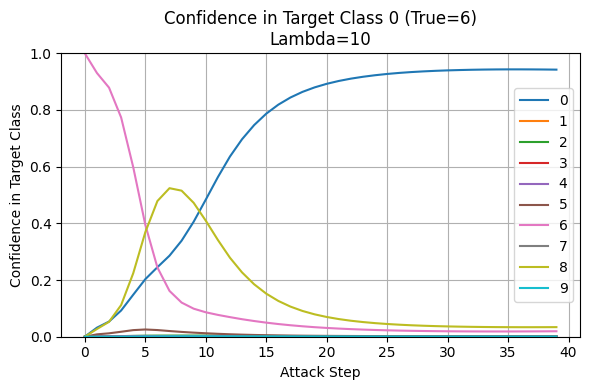

Found adversarial example for True=6, Target=2


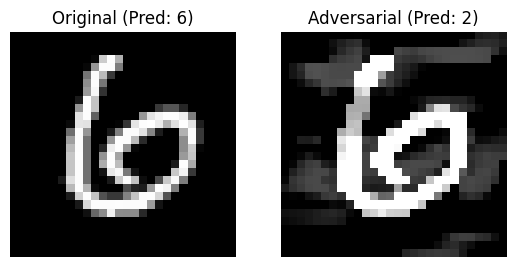

Found adversarial example for True=6, Target=3


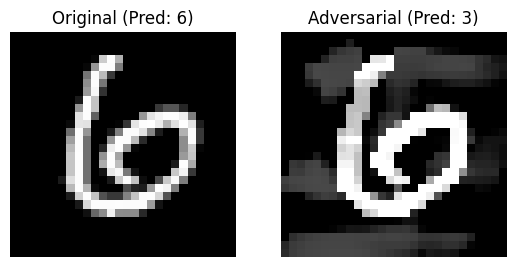

Found adversarial example for True=6, Target=4


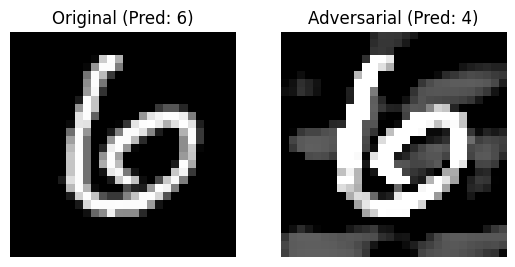

Found adversarial example for True=6, Target=5


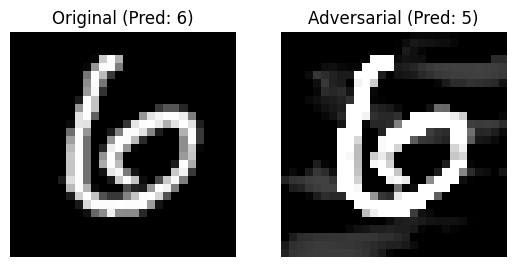

Found adversarial example for True=6, Target=7


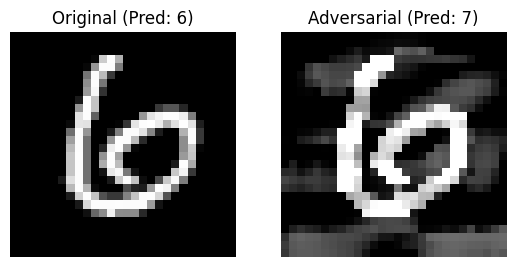

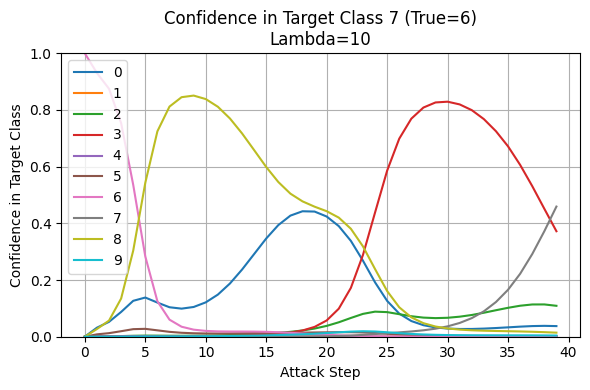

Found adversarial example for True=6, Target=8


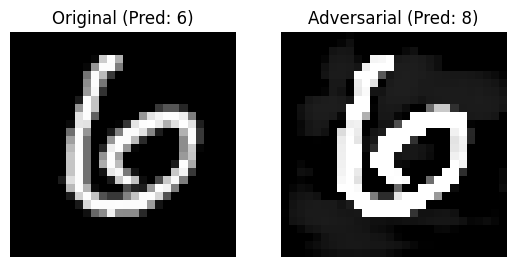

Found adversarial example for True=6, Target=9


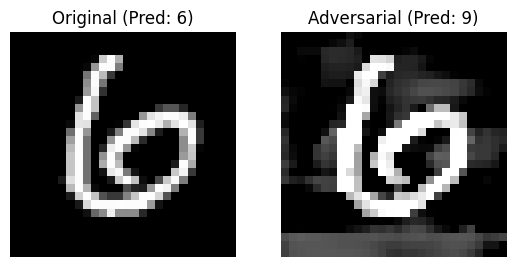

Found adversarial example for True=3, Target=5


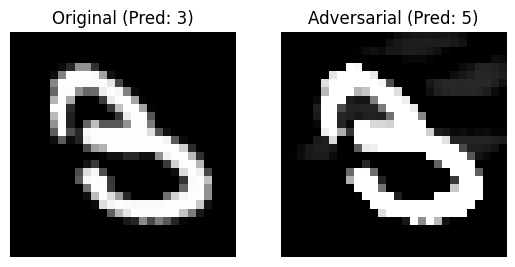

Found adversarial example for True=3, Target=7


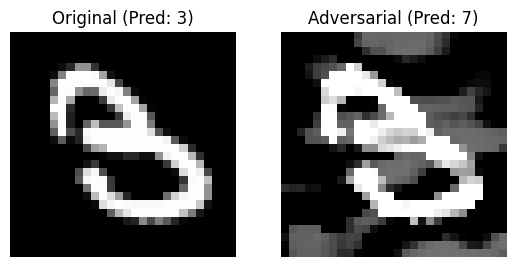

Found adversarial example for True=3, Target=8


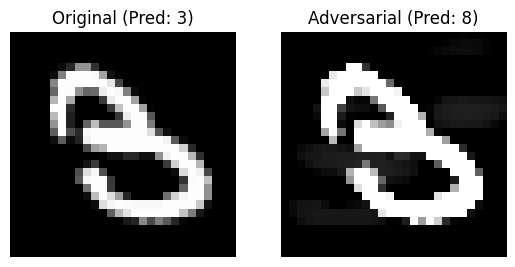

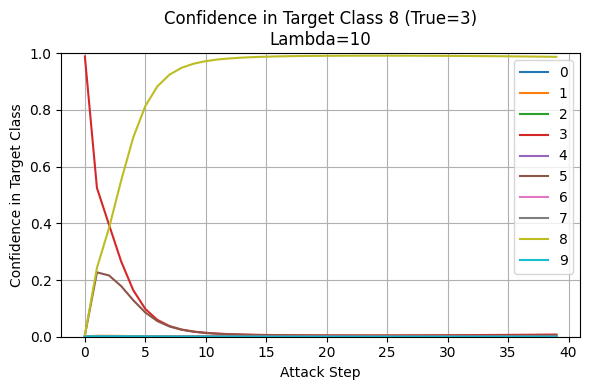

Found adversarial example for True=3, Target=9


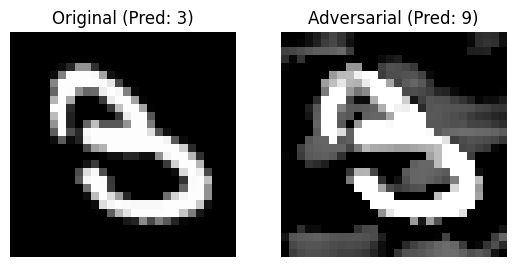

Found adversarial example for True=1, Target=6


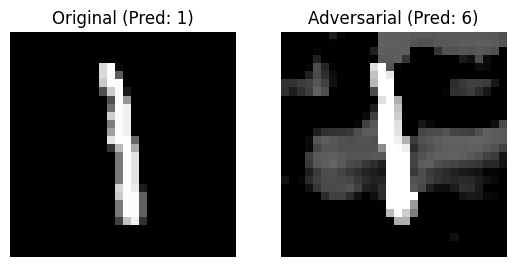

Found adversarial example for True=2, Target=7


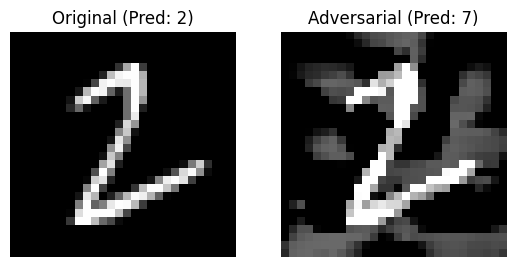

Found adversarial example for True=3, Target=2


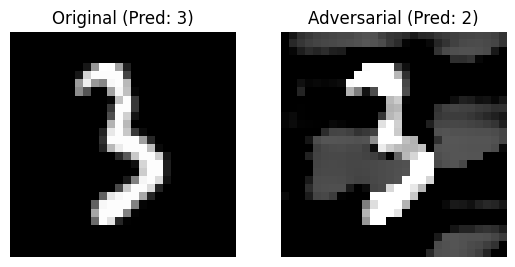

Found adversarial example for True=3, Target=6


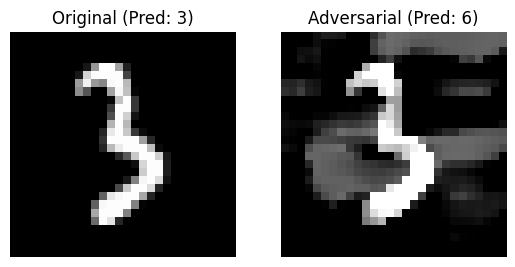

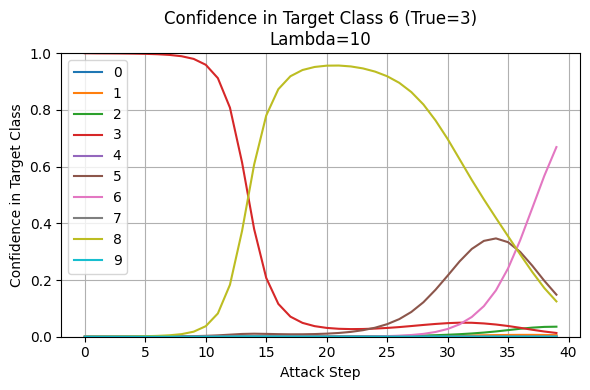

Found adversarial example for True=5, Target=4


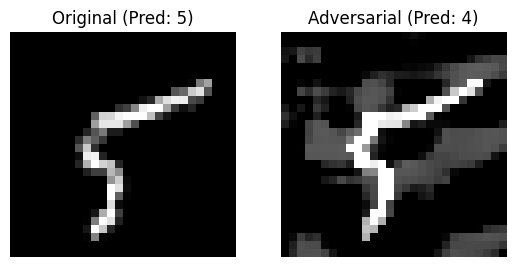

Found adversarial example for True=8, Target=2


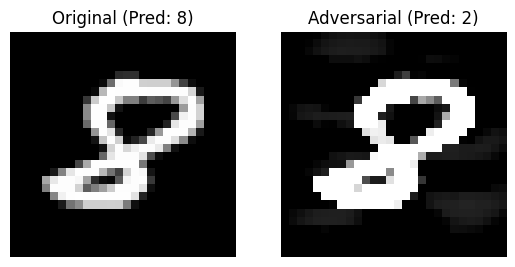

Found adversarial example for True=8, Target=3


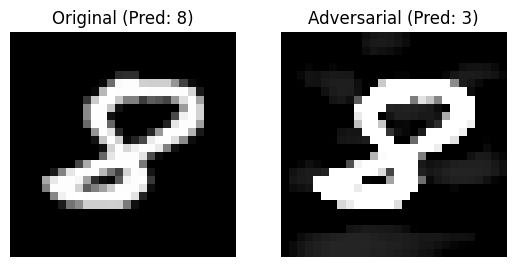

Found adversarial example for True=8, Target=5


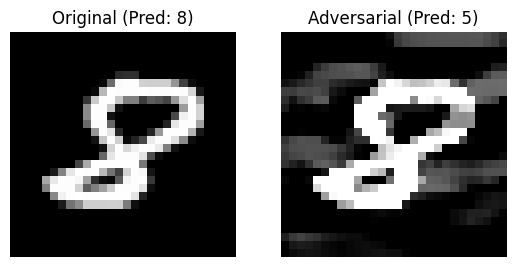

Found adversarial example for True=8, Target=7


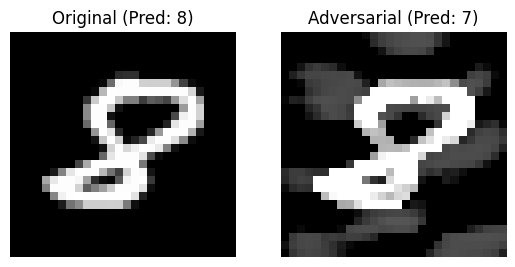

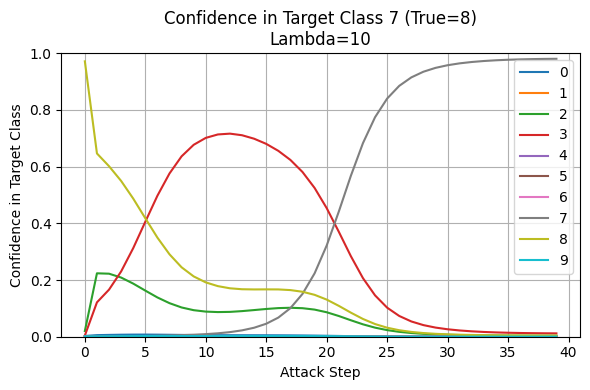

Found adversarial example for True=9, Target=6


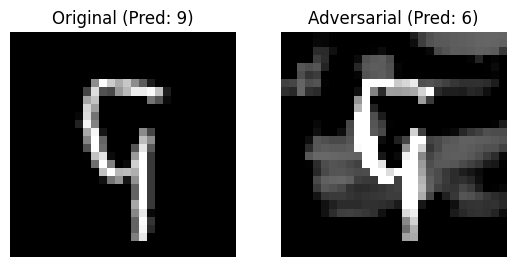

Found adversarial example for True=2, Target=1


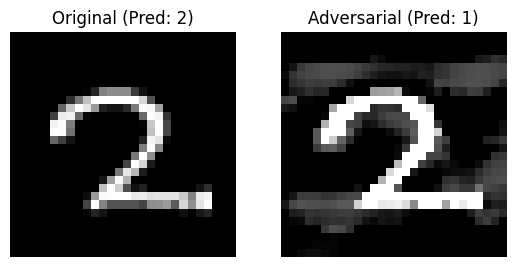

Found adversarial example for True=2, Target=9


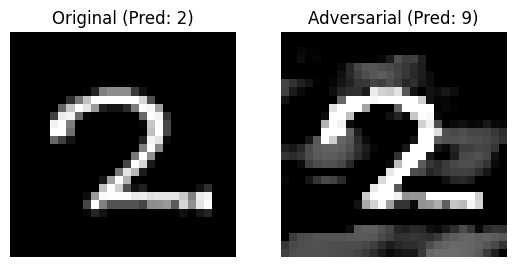

Found adversarial example for True=9, Target=1


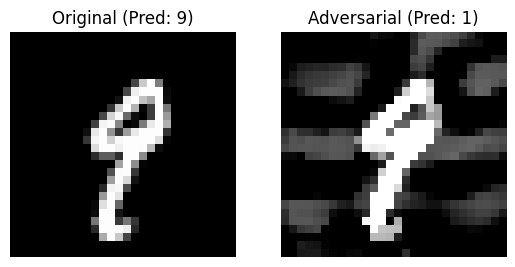

Found adversarial example for True=7, Target=4


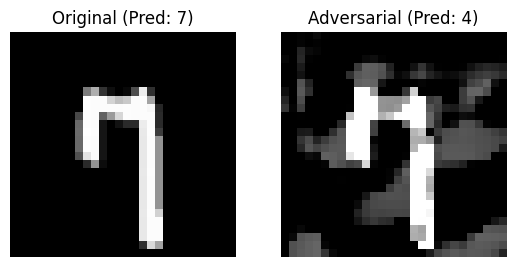

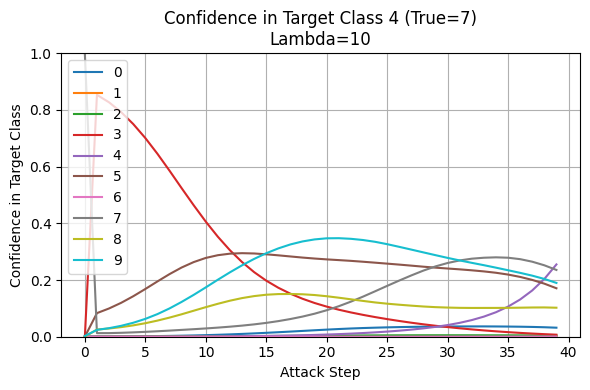

Found adversarial example for True=8, Target=0


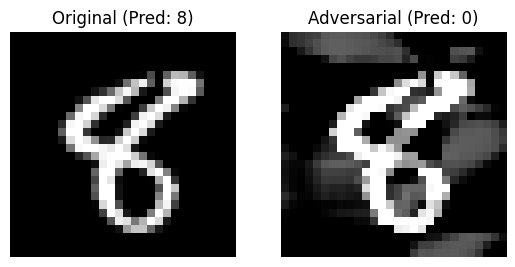

Found adversarial example for True=8, Target=9


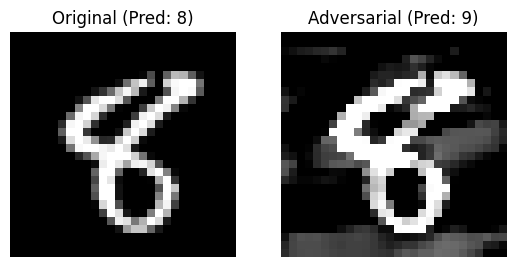

Found adversarial example for True=3, Target=0


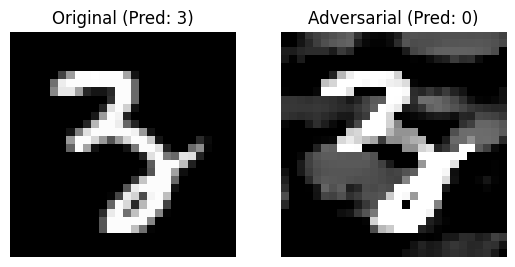

Found adversarial example for True=7, Target=1


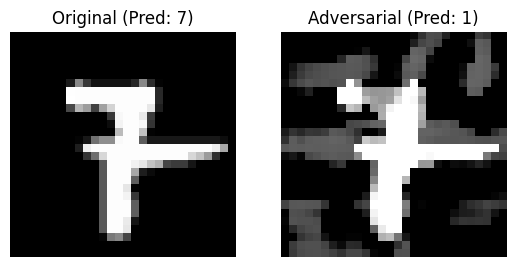

In [29]:
suc_cnt_4, trial_cnt_4 = adversarial_on_testset(10)

<ipython-input-30-fb6ce3414693>:1: RuntimeWarning: invalid value encountered in divide
  rates = suc_cnt_4/trial_cnt_4


<Axes: >

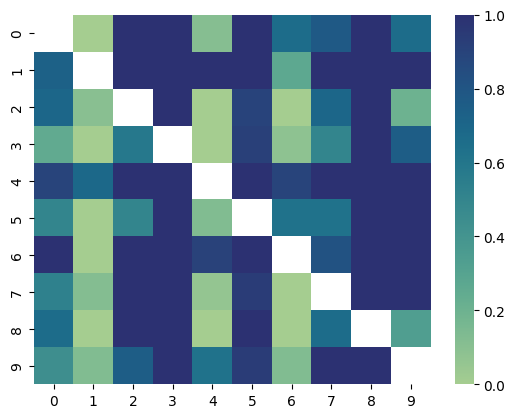

In [30]:
rates = suc_cnt_4/trial_cnt_4
sns.heatmap(rates,cmap="crest")

## Analiza wyników tasku 2

Ataki miały bardzo dobre skutki, niezależnie od prametru lambda, mapy ciepła wskazują, że ich dla zdecydowanej większości par klas były skuteczne. Oczywiście dokładniejsze przyjrzenie się im ukaże dalsze wnioski jak np. to, że trudno zmusić model do przyjęcia innej liczby jako jedynki. Skupmy się jednak na bardziej ogólnych wnioskach. Zwróćmy uwagę na wykresy (trzeba poprzesuwać wizualizacje z obrazkami powyżej). Widzimy w wielu przypadkach, że klasa żądana dopiero pod koniec osi kroków wychodzi na prowadzenie, jest to związane z niewielką liczbą kroków przy optymalizacji (40), co tym bardziej przekonuje nas, że ataki były udane. Miało to miejsce głównie dla mocnej regularyzacji która nie pozwalała na większe zmiany. Analiza wykresów i zdjęć ujawnia prawidłowość: Słabsza regularyzacja pozwala na dodanie do obrazu więcej szarych cieni, w ten sprosób bardziej utrudniając klasyfikację i wykresy pewności wykazują że p-stwo błędu (klasyfikacji jak w ataku) szybciej rośnie. W związku z tym obrazy utworzone przy większym wsp. lambda są niemal identyczne do oryginalnych z szarymi przebłyskami w pojedynczych miejscach. Jednak nawet, gdy jest ona mniejsza to obrazy są czytelne dla człowieka i widać oryginalną cyfrę.